# Install required packages for Google Colab

Install the TensorFlow Addons package containing the AdamW optimiser

In [ ]:
#!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 15.7 MB/s 


Install the Transformers package from Hugging Face containing the pre-trained BERT model

In [ ]:
#!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 16.0 MB/s 
     |████████████████████████████████| 6.6 MB 90.9 MB/s 
     |████████████████████████████████| 120 kB 84.2 MB/s 


Install the Keras Tuner package containing the Hyperband Tuner

In [ ]:
#!pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 15.7 MB/s 
     |████████████████████████████████| 1.6 MB 80.4 MB/s 


# Mount Google Drive and copy the required data
This section is only required for running the notebook in Google Colab Pro+. Copy all the required files from the personal Google Drive file to the local storage of the virtual machine.

In [ ]:
## Load the Drive helper and mount
#from google.colab import drive

## This requires authorisation
#drive.mount('/content/drive')

## Copy all the files from drive
## The Hate Speech Dataset
#!cp -r /content/drive/MyDrive/Colab_Notebooks/hate-speech-dataset-master/ /content/data
## The Word2Vec Embeddings file
#!cp -r /content/drive/MyDrive/Colab_Notebooks/word2vec-google-news-300.gz /content/data
## The GloVe Embeddings file
#!cp -r /content/drive/MyDrive/Colab_Notebooks/glove.6B.zip /content/data
## The ELMo Train and Test Tensors
#!cp -r /content/drive/MyDrive/Colab_Notebooks/Elmo_Data/ /content/data/Elmo_Data/
## The best-tuned Model
#!cp -r /content/drive/MyDrive/Colab_Notebooks/hyb_bert_tuned.keras /content/data/hyb_bert_tuned.keras
## The Twitter Hate Speech Datasets
#!cp -r /content/drive/MyDrive/Colab_Notebooks/hate-speech-twitter/ /content/data

## Change to folder
#%cd /content/data
#%ls /content/data

Mounted at /content/drive
/content/data
annotations_metadata.csv  hate-speech-twitter/  sampled_train/
Elmo_Data/                hyb_bert_tuned.keras  word2vec-google-news-300.gz
glove.6B.zip              sampled_test/


# Import the libraries

In [ ]:
# OS for file management
import os
# For data handling and EDA
import pandas as pd
import numpy as np
from collections import Counter
# For Visualisation
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px
# For text pre-processing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt') # NLTK resources for removing punctuation
nltk.download('stopwords') # NLTK resources for removing stopwords
nltk.download('words') # NLTK resources for english words
stop_words = set(stopwords.words('english')) # set English stopwords
# For NLP and ML
# Scikit-Learn libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
from sklearn.svm import LinearSVC
from sklearn.manifold import TSNE
# Keras libraries
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences # If the below is not working
#from keras.utils import pad_sequences # If the above is not working
from keras import Model
from keras.models import load_model
from keras.layers import Dense, LSTM, Embedding, Dropout, Input, Flatten, Conv1D, MaxPooling1D, Concatenate, Bidirectional
from keras.initializers import Constant, RandomUniform
from keras.utils.vis_utils import plot_model # Keras visualisation library
# TensorFlow
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import tensorflow_addons
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from gensim.models import KeyedVectors
# For ELMo
import tensorflow_hub as hub
# For Bert
from transformers import BertTokenizer
from transformers import TFBertModel
import torch
import keras_tuner as kt
# RandomUnderSampler from Imbalanced learn
from imblearn.under_sampling import RandomUnderSampler
# Set random seeds
import random
seed_value = 5
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
torch.manual_seed(seed_value)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


# Hate Speech Dataset from a White Supremacy Forum - Balanced Subset
The dataset chosen for this research is the Hate Speech Dataset from a White Supremacy Forum, introduced in (de Gibert et al., 2018). According to the authors, "A random set of forum posts have been sampled from several subforums and split into sentences. The sentences have been manually labelled as containing hate speech or not, according to certain annotation guidelines."

The experiments of this research will be based on a balanced subset of labelled sentences, which have already been provided by the authors in the sampled_train and sampled_test folders. According to the authors, "All the sentences labelled as hate have been collected, and an equivalent number of noHate sentences have been randomly sampled, summing up 2k labelled sentences. From this amount, 80% was used for training and the remaining 20% for testing." Each sentence was saved as a separate text file.

The files include sentences that required additional context during manual annotation, which will provide an extra challenge for the models that will be tested and will prove the importance of introducing more recent input methods that attempt to understand text context.

## Load the provided sampled_train and sampled_test dataset from txt files
The annotations_metadata.csv file contains the label information of each text file name and will be used to load and map the sentences with their labels. The text files will be loaded into two Pandas DataFrames, one for the training data and one for the test data.

**Load the *annotations_metadata* file into a Pandas DataFrame and view the first five rows**

In [ ]:
# Load the annotations metadata csv to a pandas dataframe
annot_df = pd.read_csv("annotations_metadata.csv")
# View the first five rows
annot_df.head(5)

,file_id,user_id,subforum_id,num_contexts,label
0,12834217_1,572066,1346,0,noHate
1,12834217_2,572066,1346,0,noHate
2,12834217_3,572066,1346,0,noHate
3,12834217_4,572066,1346,0,hate
4,12834217_5,572066,1346,0,noHate


The DataFrame has five columns: file_id (the name of the text file), user_id (the unique ID of the user that created the forum post), subforum_id (the unique ID of the forum each sentence belongs), num_contexts (sentence information related to the Relation class), and label (the class each sentence belongs to).

**View the unique sentence labels**

In [ ]:
# View unique labels
annot_df.label.unique()

array(['noHate', 'hate', 'idk/skip', 'relation'], dtype=object)

The sentences are classified into four unique labels: *noHate* (the sentence does not contain hate speech content), *hate* (the sentence contains hate speech content), *idk/skip* (non-English sentences), and *relation* (sentences that belong in a forum post that contains other hate speech sentences).

This research will experiment with a binary classification problem, predicting if a sentence classifies as Hate Speech or No Hate Speech. For this reason, rows with idk/skip and relation labels will be dropped. Furthermore, the columns user_id, subforum_id, and num_contexts will also be dropped, since only the file_id and label columns are required. A new column named sentence will be created containing each sentence.

**Drop rows with idk/skip and relation labels**

In [ ]:
# Keep sentences classified only as noHate and hate
annot_df = annot_df[(annot_df['label'] != 'relation') & (annot_df['label'] != 'idk/skip')]
# Reset index
annot_df = annot_df.reset_index(drop=True)

**Drop the columns user_id, subforum_id, and num_contexts and create new column sentence**

In [ ]:
# Keep only the columns file id and label
annot_df.drop(columns=['user_id','subforum_id','num_contexts'], inplace=True)
# Add new empty column to insert the message
annot_df['sentence']=''

**Load the sampled train and test text files from their corresponding folder**

In [ ]:
# Load the sampled_train txt files
# Create a copy of the annotation dataframe, train_df
train_df = annot_df.copy()
# Loop through all rows (for every filename)
for i in range(len(train_df['file_id'])):
    # Get current filename
    filename = train_df['file_id'][i]
    try: # Use try because we load from a subset of all text files
        # Open the file and read the contents
        with open('sampled_train/' +filename +'.txt') as f:
            contents= f.read()
        f.close()
        # Add contents of the current file to the sentence column
        train_df['sentence'][i]=contents
    except: # If the file is not in the folder
        pass # Move to the next filename

# Load the sampled_test txt files
# Create a copy of the annotation dataframe, test_df
test_df = annot_df.copy()
# Loop through all rows (for every filename)
for i in range(len(test_df['file_id'])):
    # Get current filename
    filename = test_df['file_id'][i]
    try: # Use try because we load from a subset of all text files
        # Open the file and read the contents
        with open('sampled_test/' +filename +'.txt') as f:
            contents= f.read()
        f.close()
        # Add contents of the current file to the sentence column
        test_df['sentence'][i]=contents
    except: # If the file is not in the folder
        pass # Move to the next filename

**Drop file_id column and rows where the sentence is an empty string**

In [ ]:
# Drop file id since it's not required anymore
train_df.drop(columns=['file_id'],inplace=True) # Train DataFrame
test_df.drop(columns=['file_id'],inplace=True) # Test DataFrame

# Drop rows where 'sentence' is an empty string - Train DataFrame
# Get index
idx = train_df[train_df['sentence'] == ''].index
# Drop rows based on index
train_df.drop(index=idx, inplace=True)

# Drop rows where 'sentence' is an empty string - Test DataFrame
# Get index
idx = test_df[test_df['sentence'] == ''].index
# Drop rows based on index
test_df.drop(index=idx, inplace=True)

# Reset index
train_df = train_df.reset_index(drop=True) # Train DataFrame
test_df = test_df.reset_index(drop=True) # Test DataFrame

### EDA and Text Pre-Processing

#### Generate WordCloud - Train Data

**Sentences Classified as Hate Speech**

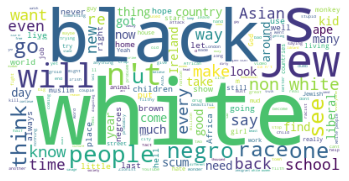

In [ ]:
# WordCloud for sentences classified as hate
wc_hate_tr = WordCloud(background_color='white').generate(' '.join(train_df['sentence'][train_df['label']=='hate']))
# Generate plot
plt.imshow(wc_hate_tr)
plt.axis("off")
plt.show()

**Sentences Classified as no Hate Speech**

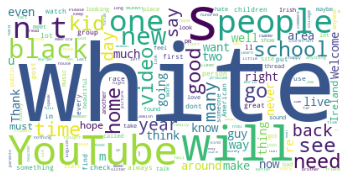

In [ ]:
# WordCloud for sentences classified as noHate
wc_noHate_tr = WordCloud(background_color='white').generate(' '.join(train_df['sentence'][train_df['label']=='noHate']))
# Generate plot
plt.imshow(wc_noHate_tr)
plt.axis("off")
plt.show()

#### Generate WordCloud - Test Data

**Sentences Classified as Hate Speech**

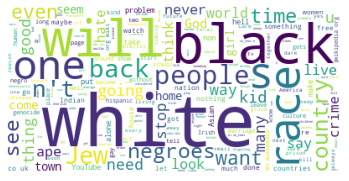

In [ ]:
# WordCloud for sentences classified as hate
wc_hate_tst = WordCloud(background_color='white').generate(' '.join(test_df['sentence'][test_df['label']=='hate']))
# Generate plot
plt.imshow(wc_hate_tst)
plt.axis("off")
plt.show()

**Sentences Classified as no Hate Speech**

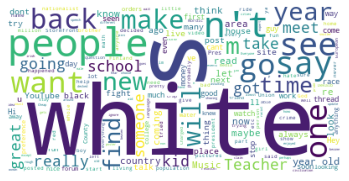

In [ ]:
# WordCloud for sentences classified as noHate
wc_noHate_tst = WordCloud(background_color='white').generate(' '.join(test_df['sentence'][test_df['label']=='noHate']))
# Generate plot
plt.imshow(wc_noHate_tst)
plt.axis("off")
plt.show()

The above WordClouds show the most common words found in sentences classified as Hate Speech and No Hate Speech, with both train and test subsets having similar results. 

Words like "black", "white", "Jew", "Asian", "negro", "race", and "ape", are a few of the most common words found in the WordCloud of Hate Sentences, words that are often found in hate speech language. On the other hand, while words like "black" or "white" also appear in the WordCloud of No Hate Sentences, we can assume that their meaning is not hate speech related, as there are among other seemingly "innocent" words like "YouTube", "school", "people", "time", "good" and others.

#### Plot Class Distribution using a Pie Chart

**Train Subset**

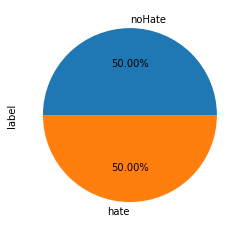

In [ ]:
# Plot the class distribution - Train
plot_tr = train_df.label.value_counts().plot(kind='pie',autopct='%1.2f%%')

**Test Subset**

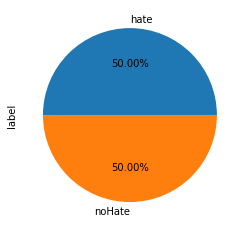

In [ ]:
# Plot the class distribution - Test
plot_tst = test_df.label.value_counts().plot(kind='pie',autopct='%1.2f%%')

#### Text Pre-Processing using NLTK
According to their paper, the authors conducted their experiments without doing any heavy text pre-processing on the sentences. To recreate their published results, a similar approach will be taken, applying only very basic pre-processing, like lowercasing and removing punctuation and non-alpha characters.

A new "clean_sentence" column will be created for both train and test subsets, containing each processed sentence. This will be done by using NLTK and applying a lambda function to the "sentence" column.

**Use NLTK to keep English alpha words**

In [ ]:
# Train Subset
# Create new column and apply pre-processing
train_df['clean_sentence'] = train_df.sentence.apply(
    lambda text: 
        " ".join(
            word.lower() for word in word_tokenize(text) if word.isalpha()
        )
)
# Test Subset
# Create new column and apply pre-processing
test_df['clean_sentence'] = test_df.sentence.apply(
    lambda text: 
        " ".join(
            word.lower() for word in word_tokenize(text) if word.isalpha()
        )
)

**Drop rows where the *clean_sentence* is an empty string**

In [ ]:
# Drop rows where 'clean_sentence' is an empty string - Train DataFrame
# Get index
idx = train_df[train_df['clean_sentence'] == ''].index
# Drop rows based on index
train_df.drop(index=idx, inplace=True)

# Drop rows where 'clean_sentence' is an empty string - Test DataFrame
# Get index
idx = test_df[test_df['clean_sentence'] == ''].index
# Drop rows based on index
test_df.drop(index=idx, inplace=True)

# Reset index
train_df = train_df.reset_index(drop=True) # Train DataFrame
test_df = test_df.reset_index(drop=True) # Test DataFrame

## Recreating Paper Results
The purpose of this section is to attempt to recreate the results reported in the paper, use them as a benchmarking tool and compare them with the results of this research.

In the paper, the below three algorithms were used for Hate Speech Classification:

- Support Vector Machines (SVM) over Bag-of-Words vectors. Word-count-based vectors were computed and fed into a Python Scikit-learn LinearSVM classifier to separate Hate and NoHate instances
- Convolutional Neural Networks (CNN). The implementation was a simplified version using a single input channel of randomly initialized word embeddings
- Recurrent Neural Networks with Long Short-term Memory (LSTM). An LSTM layer of size 128 over word embeddings of size 300

All the hyperparameters were left to the usual values reported in the literature. No hyperparameter tuning was performed. More comprehensive experimentation and research were left for future work.

### Support Vector Machine (SVM)

#### Bag-of-Words Vectors
Bag-of-words is a simple word representation model that creates fixed-sized vectors from arbitrary text. This is done by defining a vocabulary, a set of all words found in the given documents and counting how many times each word appears. The general idea of bag-of-words in a linguistic context can be found in (Harris, 1954). Although bag-of-words is a relatively basic model, it is widely used for text classification tasks due to its simplicity and how inexpensive to compute it is.

For the creation of the Bag-of-Words model, CountVectorizer will be used. The first step is to create the vocabulary, which will be created using only the train subset, to avoid leaking the test data to the SVM model.

The implementation below was based on scikit-learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [ ]:
# Instantiate Count Vectorizer
vectorizer = CountVectorizer()

# Create the vocabulary using the train subset
vectorizer.fit(train_df.clean_sentence.to_list())


# Transform train sample to document-term matrix
X_train_mat = vectorizer.transform(train_df.clean_sentence.to_list())
# Create a Pandas DataFrame from the document-term matrix
X_train_df = pd.DataFrame(X_train_mat.toarray(), columns=vectorizer.get_feature_names_out())

# Transform test sample to document-term matrix
X_test_mat = vectorizer.transform(test_df.clean_sentence.to_list())
# Create a Pandas DataFrame from the document-term matrix
X_test_df = pd.DataFrame(X_test_mat.toarray(),columns=vectorizer.get_feature_names_out())

#### Build and Train the SVM Model

In [ ]:
# Instatiate SVC
svm = LinearSVC()
# Fit training data
svm.fit(X_train_df, train_df.label)
# Get predictions on test data
svm_pred = svm.predict(X_test_df)

#### Test the SVM Model and get Performance Metrics

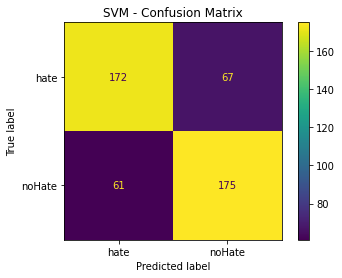

SVM Hate Precision:0.74 SVM No Hate Precision:0.72
SVM Hate Recall:0.72 SVM No Hate Recall:0.74
SVM Hate F1 Score:0.73 SVM No Hate F1 Score:0.73
SVM Hate Accuracy:0.72 SVM No Hate Accuracy:0.74
SVM Overall Accuracy:0.73


In [ ]:
# Create Confusion Matrix
cm = confusion_matrix(test_df.label, svm_pred, labels=svm.classes_)
# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()
plt.title('SVM - Confusion Matrix') # Set Title
plt.show()

# Calculate Precision and Recall Scores
pc_scr = np.ndarray.round(precision_score(test_df.label, svm_pred, average=None),2)
rc_scr = np.ndarray.round(recall_score(test_df.label, svm_pred, average=None),2)
# Print Precision and Recall Scores
print("SVM Hate Precision:"+str(pc_scr[0])+" SVM No Hate Precision:"
+str(pc_scr[1])+"\nSVM Hate Recall:"+str(rc_scr[0])
+" SVM No Hate Recall:"+str(rc_scr[1]))
# Calculate the F1 Scores
f1_scr = np.ndarray.round(f1_score(test_df.label, svm_pred, average=None),2)
# Print F1 Scores
print("SVM Hate F1 Score:"+str(f1_scr[0])+" SVM No Hate F1 Score:"+str(f1_scr[1]))
# Calculate Accuracy
class_acc = (cm.diagonal()/cm.sum(axis=1)).round(2) # Class Accuracy
all_acc = round(accuracy_score(test_df.label, svm_pred),2) # Overall Accuracy
# Print Accuracy
print("SVM Hate Accuracy:"+str(class_acc[0])+" SVM No Hate Accuracy:"
+str(class_acc[1])+"\nSVM Overall Accuracy:"+str(all_acc))

The Bag-of-Words SVM Model does a fair job in correctly classifying both classes, having an overall accuracy of 73%, an accuracy of 72% for the Hate Class, and 74% for the No Hate Class.

The results are in line with the original SVM results reported in the paper, which returned an overall accuracy of 71%, 69% for the Hate Class, and 73% for the No Hate Class. There is a small difference between returned and reported results which could be due to the different pre-processing techniques that were applied to the dataset before training.

### Convolutional Neural Network (CNN)

The authors of the paper have provided a GitHub repository which includes code for a simplified implementation of Kim's Convolutional Neural Networks for Sentence Classification paper, CNN-rand, written in Tensorflow.

The code below is my implementation of the above, written in Keras.

#### Dataset Preparation
The dataset must be prepared before it is used on the CNN Model. First, a vocabulary needs to be created to tokenize the text into number sequences. Second, all sequences must be padded to the same length. Finally, the train and test subset labels have to be one hot encoded.

In [ ]:
# Get the length of each sentence
sent_len = [len(sent.split(" ")) for sent in train_df.clean_sentence.to_list()]
# Print the max length
print('The max sentence length is '+ str(max(sent_len)))

The max sentence length is 323


In [ ]:
# Set max sentence length to max length
max_sent_len = max(sent_len)
# Instantiate keras Tokenizer with out of vocabulary token (oov) equal to 'UNK'
tokenizer = Tokenizer(oov_token='UNK')
# Create a vocabulary using the train subset
tokenizer.fit_on_texts(train_df.clean_sentence.to_list())

# Convert train subset to list of sequences
X_train_cnn = tokenizer.texts_to_sequences(train_df.clean_sentence.to_list())
# Pad sequences to the same length
X_train_cnn = pad_sequences(X_train_cnn, maxlen=max_sent_len, dtype='float32')

# Convert test to sequences
X_test_cnn = tokenizer.texts_to_sequences(test_df.clean_sentence.to_list())
# Pad examples to the same length
X_test_cnn = pad_sequences(X_test_cnn, maxlen=max_sent_len, dtype='float32')

# one hot encode train labels
y_train_cnn = pd.get_dummies(train_df.label).values.astype('float32')

# one hot encode test labels
y_test_cnn = pd.get_dummies(test_df.label).values.astype('float32')

#### Set up Hyperparameters

In [ ]:
# Percentage of the training data to use for validation
val_pct = 0.1
# The size of the embedding layer (Output dimension)
embedding_dim = 128
# Number of filters per filter size
num_filters = 128
# Dropout keep probability
dropout_prob = 0.5
# Batch Size
batch_size = 64
# Number of training epochs
num_epochs = 100

#### Build the Model

In [ ]:
# Set up parameters for Keras layers
sequence_length = X_train_cnn.shape[1] # Length of input sequences
input_shape = (sequence_length,) # Shape of the Input layer
vocab_size = len(tokenizer.word_index) + 1 # The input dimension of the embedding layer 
num_classes = y_train_cnn.shape[1] # Number of classes for the output layer

# Print layer information
print("Sequence Length: {}".format(sequence_length))
print("Input Shape: {}".format(input_shape))
print("Vocabulary Size: {}".format(vocab_size))
print("Embedding Size: {}".format(embedding_dim))
print("Number of Classes: {}".format(num_classes))

# Create Keras Model Layers
# The Input Layer
inputLayer = Input(shape=input_shape, dtype='float32', name='InputLayer')
# One Embedding Layer with randomly initialized word embeddings
embLayer = Embedding(vocab_size, embedding_dim,
                     embeddings_initializer=RandomUniform(seed=seed_value),
                     input_length=sequence_length, name='EmbeddingLayer',
                     trainable=False)(inputLayer)
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer1')(embLayer)
# Three pairs of Convolution and Pool layers, each one flattened
# First Pair, with kernel size 3
pairOneLayer = Conv1D(num_filters, 3, activation='relu',
                      name='ConvLayer1')(dropLayer) # Convolution Layer
pairOneLayer = MaxPooling1D(name='PoolLayer1')(pairOneLayer) # Pooling Layer
pairOneLayer = Flatten(name='FlattenLayer1')(pairOneLayer) # Flatten Layer
# Second Pair, with kernel size 4
pairTwoLayer = Conv1D(num_filters, 4, activation='relu',
                      name='ConvLayer2')(dropLayer) # Convolution Layer
pairTwoLayer = MaxPooling1D(name='PoolLayer2')(pairTwoLayer) # Pooling Layer
pairTwoLayer = Flatten(name='FlattenLayer2')(pairTwoLayer) # Flatten Layer
# Third Pair, with kernel size 5
pairThreeLayer = Conv1D(num_filters, 5, activation='relu',
                      name='ConvLayer3')(dropLayer) # Convolution Layer
pairThreeLayer = MaxPooling1D(name='PoolLayer3')(pairThreeLayer) # Pooling Layer
pairThreeLayer = Flatten(name='FlattenLayer3')(pairThreeLayer) # Flatten Layer
# Concatenate the three pairs
concLayer = Concatenate(name='ConcatLayer')([pairOneLayer,pairTwoLayer,pairThreeLayer])
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer2')(concLayer)
# The Output layer
outputLayer = Dense(num_classes, activation='softmax', name='OutputLayer')(dropLayer)

# Group layers into the Model object
cnn_model = Model(inputLayer, outputLayer)
# Print model summary
cnn_model.summary()

Sequence Length: 323
Input Shape: (323,)
Vocabulary Size: 5549
Embedding Size: 128
Number of Classes: 2
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 323)]        0           []                               
                                                                                                  
 EmbeddingLayer (Embedding)     (None, 323, 128)     710272      ['InputLayer[0][0]']             
                                                                                                  
 DropoutLayer1 (Dropout)        (None, 323, 128)     0           ['EmbeddingLayer[0][0]']         
                                                                                                  
 ConvLayer1 (Conv1D)            (None, 321, 128)     49280       ['DropoutLayer1[0][0]'

The Neural Network uses an input layer, one embedding layer of randomly initialized word embeddings, and one dropout layer to avoid overfitting. Three pairs of Convolution and Pooling layers, one for each kernel size of 3, 4 and 5, are used to capture the semantic patterns of each sentence, which are then concatenated together. Finally, a second dropout layer is added followed by a dense output layer that classifies each sentence.

#### Visualise the CNN Model
The Keras model can be visualised using the plot_model function from Keras Visualisation Utilities. Visualising the model is a good practice as it helps to confirm layers' order and shapes.

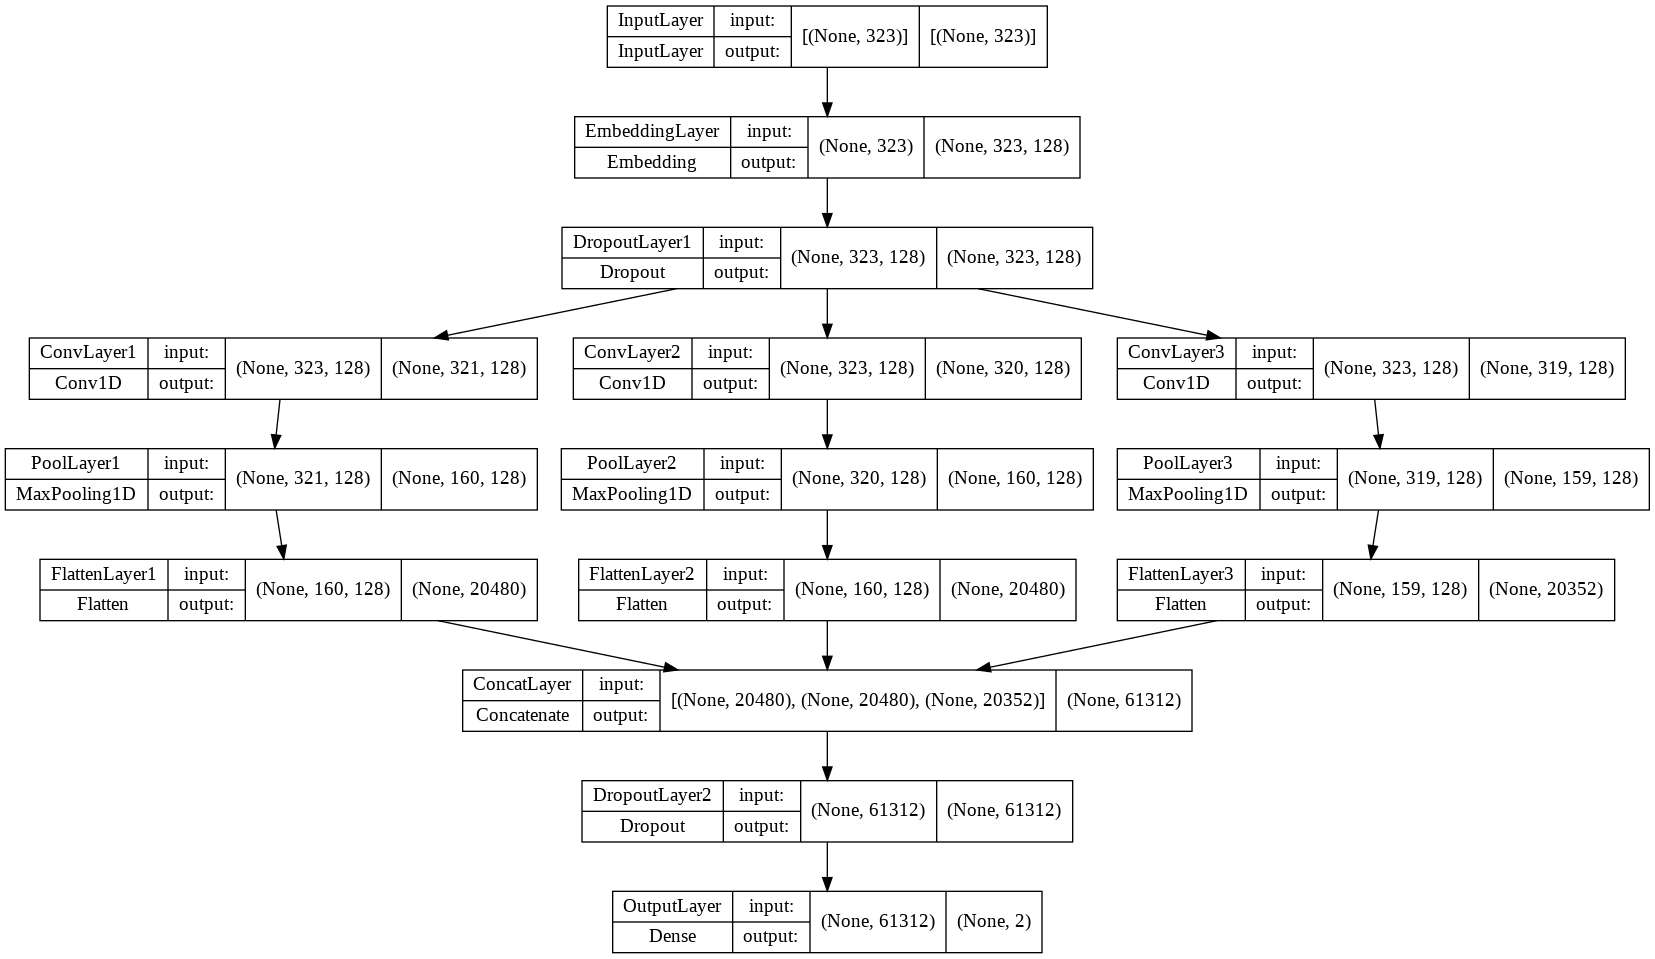

In [ ]:
# Plot the model
plot_model(cnn_model, show_shapes=True, show_layer_names=True)

#### Train the CNN Model
The model will be compiled choosing Adam as the preferred optimizer with a learning rate of 1e-3, Categorical Crossentropy as a loss function and Accuracy as a performance metric. The model is then trained on the training subset, saving the training history to be used for plotting performance metrics.

**Train the Model**

In [ ]:
# Specify optimizer, loss function, and performance metrics
cnn_model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy', metrics=['acc'])

# Train the model and store the history
cnn_history = cnn_model.fit(X_train_cnn, y_train_cnn, batch_size=batch_size,
                            epochs=num_epochs, validation_split=val_pct)

Epoch 1/100
27/27 [==============================] - 1s 17ms/step - loss: 0.6810 - acc: 0.5844 - val_loss: 0.6548 - val_acc: 0.6178
Epoch 2/100
27/27 [==============================] - 0s 10ms/step - loss: 0.6467 - acc: 0.6316 - val_loss: 0.6451 - val_acc: 0.6178
Epoch 3/100
27/27 [==============================] - 0s 10ms/step - loss: 0.6301 - acc: 0.6439 - val_loss: 0.6439 - val_acc: 0.6387
Epoch 4/100
27/27 [==============================] - 0s 10ms/step - loss: 0.6203 - acc: 0.6527 - val_loss: 0.6587 - val_acc: 0.6283
Epoch 5/100
27/27 [==============================] - 0s 10ms/step - loss: 0.6018 - acc: 0.6801 - val_loss: 0.6373 - val_acc: 0.6230
Epoch 6/100
27/27 [==============================] - 0s 10ms/step - loss: 0.5930 - acc: 0.6877 - val_loss: 0.6566 - val_acc: 0.6492
Epoch 7/100
27/27 [==============================] - 0s 10ms/step - loss: 0.5829 - acc: 0.6935 - val_loss: 0.6336 - val_acc: 0.6230
Epoch 8/100
27/27 [==============================] - 0s 10ms/step - loss: 0.

#### Plot the model's training history
Using the training history dictionary, the accuracy and loss can be plotted to observe the model's performance during training.

**Load the training and validation accuracy and loss from the training history**

In [ ]:
# Load the history dictionary
cnn_hist_dict = cnn_history.history
# Store the performance metrics
cnn_acc = cnn_hist_dict['acc'] # Accuracy
cnn_val_acc = cnn_hist_dict['val_acc'] # Validation Accuracy
cnn_loss = cnn_hist_dict['loss'] # Loss
cnn_val_loss = cnn_hist_dict['val_loss'] # Validation Loss
# Get the number of epochs
epochs = range(1, len(cnn_acc) + 1)

**Plot training and validation loss**

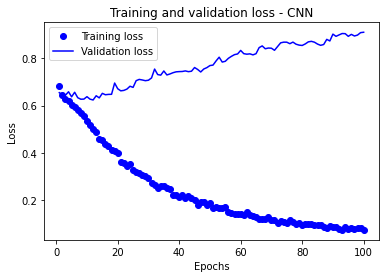

In [ ]:
# Training and validation loss
plt.plot(epochs, cnn_loss, 'bo', label='Training loss') # Training Loss
plt.plot(epochs, cnn_val_loss, 'b', label='Validation loss') # Validation Loss
# Set title and labels
plt.title('Training and validation loss - CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

**Plot training and validation accuracy**

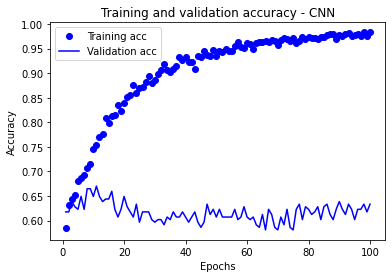

In [ ]:
# Clear current figure
plt.clf()
# Training and validation accuracy
plt.plot(epochs, cnn_acc, 'bo', label='Training acc') # Training Accuracy
plt.plot(epochs, cnn_val_acc, 'b', label='Validation acc') # Validation Accuracy
# Set title and labels
plt.title('Training and validation accuracy - CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

#### Test the CNN model get Performance Metrics
The trained model will be tested on the test subset, measuring its performance using the Confusion Matrix, Precision, Recall, Accuracy, and F1 Score.

Evaluate on test data


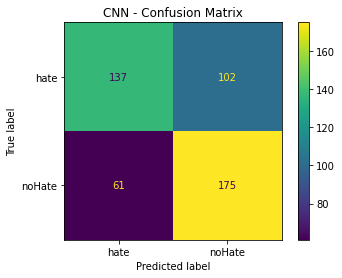

CNN Hate Precision:0.69 CNN No Hate Precision:0.63
CNN Hate Recall:0.57 CNN No Hate Recall:0.74
CNN Hate F1 Score:0.63 CNN No Hate F1 Score:0.68
CNN Hate Accuracy:0.57 CNN No Hate Accuracy:0.74
CNN Overall Accuracy:0.66


In [ ]:
# Evaluate the model on the test subset
print("Evaluate on test data")
# Store the predictions
cnn_pred = cnn_model.predict(X_test_cnn)
# Convert pred to boolean
y_pred_bool = np.argmax(cnn_pred, axis=1)
# Convert the categorical label to numeric
y_test_cnn_num = test_df.label.replace(['hate','noHate'],[0,1]).astype('float32')

# Print the Confusion Matrix
cm = confusion_matrix(y_test_cnn_num, y_pred_bool) # Calculate CM
# Generate CM Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['hate', 'noHate']) # Generate CM Display
disp.plot()
plt.title('CNN - Confusion Matrix') # Set Title
# Show the plot
plt.show()

# Calculate Precision and Recall Scores
pc_scr = np.ndarray.round(precision_score(y_test_cnn_num, y_pred_bool, average=None),2)
rc_scr = np.ndarray.round(recall_score(y_test_cnn_num, y_pred_bool, average=None),2)
# Print Precision and Recall Scores
print("CNN Hate Precision:"+str(pc_scr[0])+" CNN No Hate Precision:"
+str(pc_scr[1])+"\nCNN Hate Recall:"+str(rc_scr[0])
+" CNN No Hate Recall:"+str(rc_scr[1]))
# Calculate the F1 Scores
f1_scr = np.ndarray.round(f1_score(y_test_cnn_num, y_pred_bool, average=None),2)
# Print F1 Scores
print("CNN Hate F1 Score:"+str(f1_scr[0])+" CNN No Hate F1 Score:"+str(f1_scr[1]))
# Calculate Accuracy
class_acc = (cm.diagonal()/cm.sum(axis=1)).round(2) # Class Accuracy
all_acc = round(accuracy_score(y_test_cnn_num, y_pred_bool),2) # Overall Accuracy
# Print Accuracy
print("CNN Hate Accuracy:"+str(class_acc[0])+" CNN No Hate Accuracy:"
+str(class_acc[1])+"\nCNN Overall Accuracy:"+str(all_acc))

The CNN model with randomly initialized word embeddings does a fair job in correctly classifying No Hate sentences but performs poorly when it comes to classifying Hate sentences, having an overall accuracy of 66%, a Hate accuracy of 57%, and a No Hate accuracy of 74%. 

The randomly initialized word embeddings fail to capture the content of the sentences that contain Hate Speech. Since the model is unable to distinguish the different meanings of the two classes, it misclassifies almost half of them as No Hate.

The results are in line with the original CNN results reported in the paper, which returned an overall accuracy of 66%, 55% for the Hate Class, and 79% for the No Hate Class. There is a small difference between returned and reported results which could be due to the different pre-processing techniques that were applied to the dataset before training and the randomness of the initialized word embeddings. 

### Long Short-Term Memory (LSTM)

#### Dataset Preparation
Similar to the CNN steps, the dataset needs to be prepared before it is used on the LSTM Model. There is an important difference regarding sequence padding. Initially, post-padding was used, similarly to the CNN model. However, the LSTM performance was negatively affected, classifying all sentences into the hate class only, returning an accuracy of 50%. The LSTM model works only with pre-padding, since post-padding adds noise to the sequences, preventing the model from learning.

In [ ]:
# Get the length of each sentence
sent_len = [len(sent.split(" ")) for sent in train_df.clean_sentence.to_list()]
# Print the max sentence length
print('The max sentence length is '+ str(max(sent_len)))

The max sentence length is 323


In [ ]:
# Set max sentence length to max sent len
max_sent_len = max(sent_len)
# Instantiate keras Tokenizer with out of vocabulary token (oov) equal to UNK
tokenizer = Tokenizer(oov_token='UNK')
# Create a vocabulary using the train subset
tokenizer.fit_on_texts(train_df.clean_sentence.to_list())

# Convert train subset to list of sequences
X_train_lstm = tokenizer.texts_to_sequences(train_df.clean_sentence.to_list())
# Pad sequences to the same length
X_train_lstm = pad_sequences(X_train_lstm, maxlen=max_sent_len, dtype='float32',
                            padding='pre')

# Convert test to sequences
X_test_lstm = tokenizer.texts_to_sequences(test_df.clean_sentence.to_list())
# Pad examples to the same length
X_test_lstm = pad_sequences(X_test_lstm, maxlen=max_sent_len, dtype='float32',
                           padding='pre')

# one hot encode train labels
y_train_lstm = pd.get_dummies(train_df.label).values.astype('float32')

# one hot encode test labels
y_test_lstm = pd.get_dummies(test_df.label).values.astype('float32')

#### Set up Hyperparameters

In [ ]:
# Percentage of the training data to use for validation
val_pct = 0.1
# The size of the embedding layer (Output dimension)
embedding_dim = 300
# The units of the LSTM layer (dimension)
lstm_dim = 128
# Dropout keep probability
dropout_prob = 0.5
# Batch Size
batch_size = 32
# Number of training epochs
num_epochs = 50

#### Build the model

In [ ]:
# Set up parameters for Keras layers
sequence_length = X_train_lstm.shape[1] # Length of input sequences
input_shape = (sequence_length,) # Shape of the Input layer
vocab_size = len(tokenizer.word_index) + 1 # The input dimension of the embedding layer 
num_classes = y_train_lstm.shape[1] # Number of classes for the output layer

# Print layer information
print("Sequence Length: {}".format(sequence_length))
print("Input Shape: {}".format(input_shape))
print("Vocabulary Size: {}".format(vocab_size))
print("Embedding Size: {}".format(embedding_dim))
print("Number of Classes: {}".format(num_classes))

# Create Keras Model Layers
# The Input Layer
inputLayer = Input(shape=input_shape, dtype='float32', name='InputLayer')
# One Embedding Layer with randomly initialized word embeddings
embLayer = Embedding(vocab_size, embedding_dim,
                     embeddings_initializer=RandomUniform(seed=seed_value),
                     input_length=sequence_length,name='EmbeddingLayer',
                     trainable=False)(inputLayer)
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer1')(embLayer)
# One LSTM Layer of size 128
lstmLayer = LSTM(lstm_dim,name='LSTMLayer')(dropLayer)
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer2')(lstmLayer)
# The Output layer
outputLayer = Dense(num_classes, activation='softmax', name='OutputLayer')(dropLayer)

# Group layers into the Model object
lstm_model = Model(inputLayer, outputLayer)
# Print model summary
lstm_model.summary()

Sequence Length: 323
Input Shape: (323,)
Vocabulary Size: 5549
Embedding Size: 300
Number of Classes: 2
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 323)]             0         
                                                                 
 EmbeddingLayer (Embedding)  (None, 323, 300)          1664700   
                                                                 
 DropoutLayer1 (Dropout)     (None, 323, 300)          0         
                                                                 
 LSTMLayer (LSTM)            (None, 128)               219648    
                                                                 
 DropoutLayer2 (Dropout)     (None, 128)               0         
                                                                 
 OutputLayer (Dense)         (None, 2)                 258       
                    

The Neural Network uses an input layer, one embedding layer of randomly initialized word embeddings, and one dropout layer to avoid overfitting. A single LSTM layer is then placed, capable of predicting the long sequences of data like sentences. Finally, a second dropout layer is added followed by a dense output layer that classifies each sentence.

#### Visualise the LSTM Model
The Keras model can be visualised using the plot_model function from Keras Visualisation Utilities. Visualising the model is a good practice as it helps to confirm layers' order and shapes.

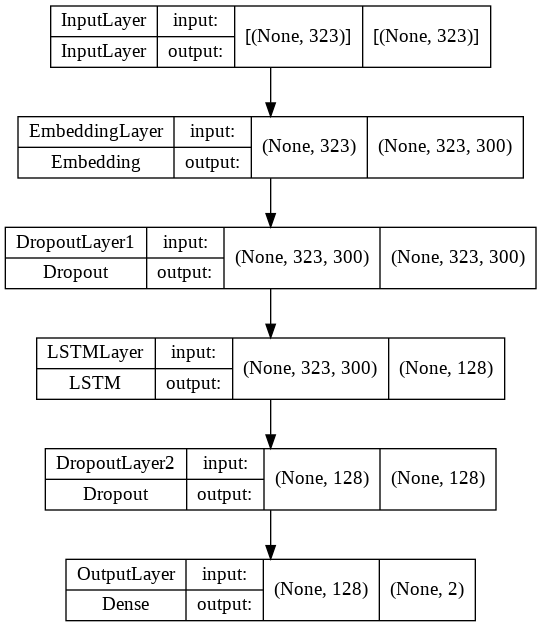

In [ ]:
# Plot the model
plot_model(lstm_model, show_shapes=True, show_layer_names=True)

#### Train the LSTM Model
The model will be compiled choosing Adam as the preferred optimize with a learning rate of 5e-5, Categorical Crossentropy as a loss function and Accuracy as a performance metric. The model is then trained on the train subset, saving the training history to be used for plotting performance metrics.

**Train the Model**

In [ ]:
# Specify loss function, optimizer, and performance metrics
lstm_model.compile(optimizer=Adam(learning_rate=5e-5),
                  loss='categorical_crossentropy', metrics=['acc'])

# Train the model and store the history
lstm_history = lstm_model.fit(X_train_lstm, y_train_lstm, batch_size=batch_size,
                            epochs=num_epochs, validation_split=val_pct)

Epoch 1/50
54/54 [==============================] - 4s 27ms/step - loss: 0.6904 - acc: 0.5324 - val_loss: 0.6863 - val_acc: 0.6073
Epoch 2/50
54/54 [==============================] - 1s 18ms/step - loss: 0.6815 - acc: 0.5779 - val_loss: 0.6750 - val_acc: 0.5969
Epoch 3/50
54/54 [==============================] - 1s 18ms/step - loss: 0.6677 - acc: 0.5733 - val_loss: 0.6569 - val_acc: 0.5864
Epoch 4/50
54/54 [==============================] - 1s 18ms/step - loss: 0.6569 - acc: 0.6124 - val_loss: 0.6482 - val_acc: 0.6335
Epoch 5/50
54/54 [==============================] - 1s 19ms/step - loss: 0.6438 - acc: 0.6276 - val_loss: 0.6458 - val_acc: 0.6335
Epoch 6/50
54/54 [==============================] - 1s 18ms/step - loss: 0.6366 - acc: 0.6457 - val_loss: 0.6395 - val_acc: 0.6335
Epoch 7/50
54/54 [==============================] - 1s 18ms/step - loss: 0.6347 - acc: 0.6381 - val_loss: 0.6372 - val_acc: 0.6440
Epoch 8/50
54/54 [==============================] - 1s 20ms/step - loss: 0.6319 - a

#### Plot the model's training history
Using the training history dictionary, the accuracy and loss can be plotted to observe the model's performance during training.

**Load the training and validation accuracy and loss from the training history**

In [ ]:
# Load the history dictionary
lstm_hist_dict = lstm_history.history
# Store the performance metrics
lstm_acc = lstm_hist_dict['acc'] # Accuracy
lstm_val_acc = lstm_hist_dict['val_acc'] # Validation Accuracy
lstm_loss = lstm_hist_dict['loss'] # Loss
lstm_val_loss = lstm_hist_dict['val_loss'] # Validation Loss
# Get the number of epochs
epochs = range(1, len(lstm_acc) + 1)

**Plot training and validation loss**

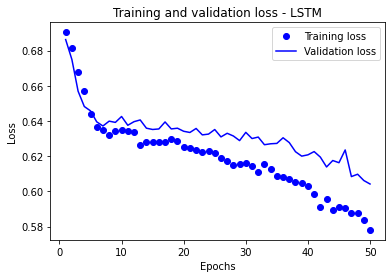

In [ ]:
# Training and validation loss
plt.plot(epochs, lstm_loss, 'bo', label='Training loss') # Training Loss
plt.plot(epochs, lstm_val_loss, 'b', label='Validation loss') # Validation Loss
# Set title and labels
plt.title('Training and validation loss - LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

**Plot training and validation accuracy**

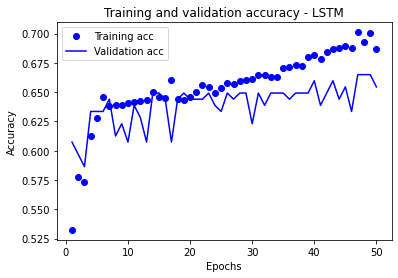

In [ ]:
# Clear current figure
plt.clf()
# Training and validation accuracy
plt.plot(epochs, lstm_acc, 'bo', label='Training acc') # Training Accuracy
plt.plot(epochs, lstm_val_acc, 'b', label='Validation acc') # Validation Accuracy
# Set title and labels
plt.title('Training and validation accuracy - LSTM')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

#### Test the LSTM model get Performance Metrics
The trained model will be tested on the test subset, measuring its performance using the Confusion Matrix, Precision, Recall, Accuracy, and F1 Score.

Evaluate on test data


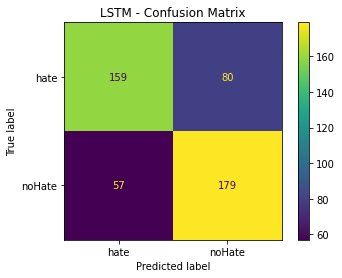

LSTM Hate Precision:0.74 LSTM No Hate Precision:0.69
LSTM Hate Recall:0.67 LSTM No Hate Recall:0.76
LSTM Hate F1 Score:0.7 LSTM No Hate F1 Score:0.72
LSTM Hate Accuracy:0.67 LSTM No Hate Accuracy:0.76
LSTM Overall Accuracy:0.71


In [ ]:
# Evaluate the model on the test subset
print("Evaluate on test data")
# Store the predictions 
lstm_pred = lstm_model.predict(X_test_lstm)
# Convert pred to boolean
y_pred_bool = np.argmax(lstm_pred, axis=1)
# Convert the categorical label to numeric
y_test_lstm_num = test_df.label.replace(['hate','noHate'],[0,1]).astype('float32')

# Print the Confusion Matrix
cm = confusion_matrix(y_test_lstm_num, y_pred_bool) # Calculate CM
# Generate CM Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['hate', 'noHate']) # Generate CM Display
disp.plot()
plt.title('LSTM - Confusion Matrix') # Set Title
# Show the plot
plt.show()

# Calculate Precision and Recall Scores
pc_scr = np.ndarray.round(precision_score(y_test_lstm_num, y_pred_bool, average=None),2)
rc_scr = np.ndarray.round(recall_score(y_test_lstm_num, y_pred_bool, average=None),2)
# Print Precision and Recall Scores
print("LSTM Hate Precision:"+str(pc_scr[0])+" LSTM No Hate Precision:"
+str(pc_scr[1])+"\nLSTM Hate Recall:"+str(rc_scr[0])
+" LSTM No Hate Recall:"+str(rc_scr[1]))
# Calculate the F1 Scores
f1_scr = np.ndarray.round(f1_score(y_test_lstm_num, y_pred_bool, average=None),2)
# Print F1 Scores
print("LSTM Hate F1 Score:"+str(f1_scr[0])+" LSTM No Hate F1 Score:"+str(f1_scr[1]))
# Calculate Accuracy
class_acc = (cm.diagonal()/cm.sum(axis=1)).round(2) # Class Accuracy
all_acc = round(accuracy_score(y_test_lstm_num, y_pred_bool),2) # Overall Accuracy
# Print Accuracy
print("LSTM Hate Accuracy:"+str(class_acc[0])+" LSTM No Hate Accuracy:"
+str(class_acc[1])+"\nLSTM Overall Accuracy:"+str(all_acc))

The LSTM model with randomly initialized word embeddings does a fair job in correctly classifying Hate and No Hate sentences, having an overall accuracy of 71%, a Hate accuracy of 67%, and a No Hate accuracy of 76%.

Despite utilizing randomly initialized word embeddings like the CNN model, the LSTM model does a better job in identifying, storing, and remembering the important words of each class, being able to better distinguish them, compared to CNN.

The results are in line with the original LSTM results reported in the paper, which returned an overall accuracy of 73%, 71% for the Hate Class, and 75% for the No Hate Class. Similarly, the small difference between returned and reported results could be due to the different pre-processing techniques that were applied to the dataset before training and the randomness of the initialized word embeddings.

## Pre-Trained Word Embeddings and the Use of Context
The purpose of this research is to experiment with contextualised pre-trained word embedding models.

This section will attempt to answer the question "To what extent contextualised word embedding methods improve hate speech detection?" by introducing pre-trained word embeddings to the above models, replacing the traditional bag-of-word model used in the SVM model and the random word embeddings used in both the CNN and LSTM models.

First, the experiments will be done using context-independent models (i.e. Word2vec and GloVe). The performance will then be compared with the performance of context-dependent models (i.e. ELMo and BERT).

### Context Independent Word Embeddings - Word2Vec
The Word2Vec method introduced in (Mikolov, Yih and Zweig, 2013) was an attempt to make the neural-network-based training of the embedding more efficient. Instead of representing words as a word count, the model learns and represents the words’ relationships by placing them in a continuous vector space. As stated by Mikolov, Yih, and Zweig in their paper, “We find that these representations are surprisingly good at capturing syntactic and semantic regularities in language and that each relationship is characterized by a relation-specific vector offset. This allows vector-oriented reasoning based on the offsets between words.”

The below implementation was inspired by the Keras tutorial on pre-trained embeddings: https://keras.io/examples/nlp/pretrained_word_embeddings/

#### Create a vocabulary index

The first step is to index the vocabulary found in the dataset, by using Keras' Tokenizer.

The max sentence length is 323


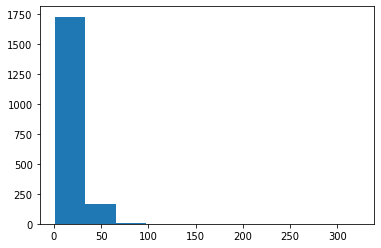

In [ ]:
# Get the length of all sentences
sent_len = [len(sent.split(" ")) for sent in train_df.clean_sentence.to_list()]
# Histogram on the sentences length
len_hist=plt.hist(sent_len)
# Print the max sentence length
print('The max sentence length is '+ str(max(sent_len)))

It is common practice to pad all sentences to the max sentence length. However, the above histogram shows that the majority of the sentences have a length between 0 and 50, with a few sentences going up to 100. Therefore, the max sentence length used for applying padding will change to 100.

In [ ]:
# Set max sentence length to 100
max_sent_len = 100
# Instantiate keras Tokenizer with out of vocabulary token (oov) equal to UNK
tokenizer = Tokenizer(oov_token='UNK')
# Create a vocabulary using the train subset
tokenizer.fit_on_texts(train_df.clean_sentence.to_list())

**Get a dictionary with each word to its index**

In [ ]:
# Get word index
word_idx = tokenizer.word_index

**Checking that the dictionary works, using a test sentence**

In [ ]:
test = ["i", "like", "every", "person", "in", "the", "world"]
[word_idx[w] for w in test]

[6, 32, 95, 164, 8, 2, 147]

#### Load the Word2Vec pre-trained word embeddings

Download the Pre-trained word and phrase vectors trained on part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases.

In [ ]:
# Download pre-trained vectors from gensim
#import gensim.downloader
#w2v_vectors = gensim.downloader.load('word2vec-google-news-300')  # load pre-trained word-vectors from gensim-data

# Load vectors directly from the file
w2v_vectors = KeyedVectors.load_word2vec_format('word2vec-google-news-300.gz', binary=True)

The next step is to create a corresponding embedding matrix that can be used in the Keras Embedding layer. Entry at index i is the pre-trained vector for the word of index i in the vectorizer's vocabulary.

In [ ]:
# Embedding matrix for keras embedding layer
embedding_dim = 300 # dimension of word2vec vectors used
num_tokens = len(word_idx) + 1

# Create the embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
# Go through every word in the word/idx dictionary
for word, i in word_idx.items():
    # Get word's vector representation from the w2v vectors
    try: # If vector is not none (the word exists)
      embedding_vector = w2v_vectors.get_vector(word)
      # Store word's index and its vector representation
      embedding_matrix[i] = embedding_vector
    except:
        pass

**Check how many words from the vocabulary are not found in the pre-trained vectors**

In [ ]:
# Counter for missing words
missing_words = 0
# For every word_vector in the matrix
for word_vector in embedding_matrix:
  # If the mean is zero
  if word_vector.mean() == 0:
    missing_words+=1 # Counter
# Show number of missing words minus 1 for the OOV token
print(str(missing_words - 1) + " words from the vocabulary are missing from the Pre-Trained Word2Vec vectors.")

494 words from the vocabulary are missing from the Pre-Trained Word2Vec vectors.


The matrix can now be loaded into a Keras Embedding layer, with the trainable flag equal to False, to avoid updating it during the training.

#### Prepare the train and test subsets for training

First, the list-of-strings data must be converted to NumPy arrays of integer indices.

In [ ]:
# Convert train subset to list of sequences
X_train_w2v = tokenizer.texts_to_sequences(train_df.clean_sentence.to_list())
# Pad sequences to the same length
X_train_w2v = pad_sequences(X_train_w2v, maxlen=max_sent_len, dtype='float32',
                            padding='pre')

# Convert test to sequences
X_test_w2v = tokenizer.texts_to_sequences(test_df.clean_sentence.to_list())
# Pad examples to the same length
X_test_w2v = pad_sequences(X_test_w2v, maxlen=max_sent_len, dtype='float32',
                           padding='pre')



# one hot encode train labels
y_train_w2v = pd.get_dummies(train_df.label).values.astype('float32')
# Convert the categorical label to numeric
y_train_w2v_num = train_df.label.replace(['hate','noHate'],[0,1]).astype('float32')

# one hot encode test labels
y_test_w2v = pd.get_dummies(test_df.label).values.astype('float32')
# Convert the categorical label to numeric
y_test_w2v_num = test_df.label.replace(['hate','noHate'],[0,1]).astype('float32')

#### Test the Support Vector Machine Model with the Word2Vec embeddings

**Map the embedding matrix vectors to the train and test data**

Unlike the Keras Deep Learning Networks, the Scikit-learn LinearSVC model does not incorporate an embedding layer. Therefore, the mapping to the train and test data has to be applied manually.

In [ ]:
# Initialize empty lists for train and test data
X_train_svm_w2v = []
X_test_svm_w2v = []

# Map embedding matrix to the train subset
for sent_array in X_train_w2v.astype('int32'): # For every sentence
  temp_list = [] # Initialize list to store sent vectors
  for element in sent_array: # For every element
    # Append the element's token
    temp_list.append(embedding_matrix[element].tolist())
  # Append the sentence's vector
  X_train_svm_w2v.append(temp_list)
# Transform to numpy array
X_train_svm_w2v = np.asarray(X_train_svm_w2v, dtype='float32')
# Reduce dimension
X_train_svm_w2v = np.mean(X_train_svm_w2v, axis=1)

# Map embedding matrix to the test subset
for sent_array in X_test_w2v.astype('int32'): # For every sentence
  temp_list = [] # Initialize list to store sent vectors
  for element in sent_array: # For every element
    # Append the element's token
    temp_list.append(embedding_matrix[element].tolist())
  # Append the sentence's vector
  X_test_svm_w2v.append(temp_list)
# Transform to numpy array
X_test_svm_w2v = np.asarray(X_test_svm_w2v, dtype='float32')
# Reduce dimension
X_test_svm_w2v = np.mean(X_test_svm_w2v, axis=1)

**Create and train the SVM model**

In [ ]:
# Instatiate SVC
svm_w2v = LinearSVC()
# Fit training data
svm_w2v.fit(X_train_svm_w2v, y_train_w2v_num)
# Get prediction on test data
svm_w2v_pred = svm_w2v.predict(X_test_svm_w2v)

**Test the SVM Model and get Performance Metrics**

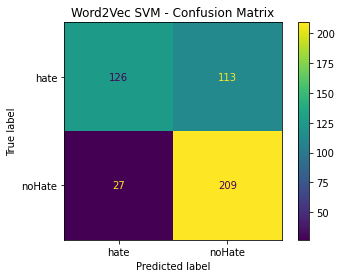

W2V SVM Hate Precision:0.82 W2V SVM No Hate Precision:0.65
W2V SVM Hate Recall:0.53 W2V SVM No Hate Recall:0.89
W2V SVM Hate F1 Score:0.64 W2V SVM No Hate F1 Score:0.75
W2V SVM Hate Accuracy:0.53 W2V SVM No Hate Accuracy:0.89
W2V SVM Overall Accuracy:0.71


In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_test_w2v_num, svm_w2v_pred, labels=svm_w2v.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['hate','noHate'])
disp.plot()
plt.title('Word2Vec SVM - Confusion Matrix') # Set Title
plt.show()

# Calculate Precision and Recall Scores
pc_scr = np.ndarray.round(precision_score(y_test_w2v_num, svm_w2v_pred, average=None),2)
rc_scr = np.ndarray.round(recall_score(y_test_w2v_num, svm_w2v_pred, average=None),2)
# Print Precision and Recall Scores
print("W2V SVM Hate Precision:"+str(pc_scr[0])+" W2V SVM No Hate Precision:"
+str(pc_scr[1])+"\nW2V SVM Hate Recall:"+str(rc_scr[0])
+" W2V SVM No Hate Recall:"+str(rc_scr[1]))
# Calculate the F1 Scores
f1_scr = np.ndarray.round(f1_score(y_test_w2v_num, svm_w2v_pred, average=None),2)
# Print F1 Scores
print("W2V SVM Hate F1 Score:"+str(f1_scr[0])+" W2V SVM No Hate F1 Score:"+str(f1_scr[1]))
# Calculate Accuracy
class_acc = (cm.diagonal()/cm.sum(axis=1)).round(2) # Class Accuracy
all_acc = round(accuracy_score(y_test_w2v_num, svm_w2v_pred),2) # Overall Accuracy
# Print Accuracy
print("W2V SVM Hate Accuracy:"+str(class_acc[0])+" W2V SVM No Hate Accuracy:"
+str(class_acc[1])+"\nW2V SVM Overall Accuracy:"+str(all_acc))

Using Word2Vec embeddings with SVM greatly improved the model's ability to correctly classify No Hate Sentences, compared to the Bag-of-Words SVM model. However, the Word2Vec embeddings hurt the model's ability to correctly classify Hate sentences. The model returned an overall accuracy of 71%, a Hate accuracy of 53%, and a No Hate accuracy of 89%.

Unlike Deep Learning Neural Networks, traditional Machine Learning models like SVM, cannot handle three-dimensional data. The embedding vectors had to be averaged to maintain the dimensionality that works with SVM, losing the spatial features of the Word2Vec vectors.

#### Test the Convolutional Neural Network Model with the Word2Vec embeddings

**Set up Hyperparameters**

In [ ]:
# Percentage of the training data to use for validation
val_pct = 0.1
# Number of filters per filter size
num_filters = 100
# Dropout keep probability
dropout_prob = 0.2
# Batch Size
batch_size = 64
# Number of training epochs
num_epochs = 90

**Build the Model**

In [ ]:
# Set up parameters for Keras layers
sequence_length = X_train_w2v.shape[1] # Length of input sequences
input_shape = (sequence_length,) # Shape of the Input layer
vocab_size = num_tokens # The input dimension of the embedding layer 
num_classes = y_train_w2v.shape[1] # Number of classes for the output layer

# Print layer information
print("Sequence Length: {}".format(sequence_length))
print("Input Shape: {}".format(input_shape))
print("Vocabulary Size: {}".format(vocab_size))
print("Embedding Size: {}".format(embedding_dim))
print("Number of Classes: {}".format(num_classes))

# Create Keras Model Layers
# The Input Layer
inputLayer = Input(shape=input_shape, dtype='float32', name='InputLayer')
# One Embedding Layer with Word2Vec word embeddings
embLayer = Embedding(vocab_size, embedding_dim,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=sequence_length, 
                     trainable=False, name='EmbeddingLayer')(inputLayer)
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer1')(embLayer)
# Three pairs of Convolution and Pool layers, each one flattened
# First Pair, with kernel size 3
pairOneLayer = Conv1D(num_filters, 3, activation='relu',
                      name='ConvLayer1')(dropLayer) # Convolution Layer
pairOneLayer = MaxPooling1D(name='PoolLayer1')(pairOneLayer) # Pooling Layer
pairOneLayer = Flatten(name='FlattenLayer1')(pairOneLayer) # Flatten Layer
# Second Pair, with kernel size 4
pairTwoLayer = Conv1D(num_filters, 4, activation='relu',
                      name='ConvLayer2')(dropLayer) # Convolution Layer
pairTwoLayer = MaxPooling1D(name='PoolLayer2')(pairTwoLayer) # Pooling Layer
pairTwoLayer = Flatten(name='FlattenLayer2')(pairTwoLayer) # Flatten Layer
# Third Pair, with kernel size 5
pairThreeLayer = Conv1D(num_filters, 5, activation='relu',
                      name='ConvLayer3')(dropLayer) # Convolution Layer
pairThreeLayer = MaxPooling1D(name='PoolLayer3')(pairThreeLayer) # Pooling Layer
pairThreeLayer = Flatten(name='FlattenLayer3')(pairThreeLayer) # Flatten Layer
# Concatenate the three pairs
concLayer = Concatenate(name='ConcatLayer')([pairOneLayer,pairTwoLayer,pairThreeLayer])
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer2')(concLayer)
# The Output layer
outputLayer = Dense(num_classes, activation='softmax', name='OutputLayer')(dropLayer)

# Group layers into the Model object
cnn_w2v_model = Model(inputLayer, outputLayer)
# Print model summary
cnn_w2v_model.summary()

Sequence Length: 100
Input Shape: (100,)
Vocabulary Size: 5549
Embedding Size: 300
Number of Classes: 2
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 EmbeddingLayer (Embedding)     (None, 100, 300)     1664700     ['InputLayer[0][0]']             
                                                                                                  
 DropoutLayer1 (Dropout)        (None, 100, 300)     0           ['EmbeddingLayer[0][0]']         
                                                                                                  
 ConvLayer1 (Conv1D)            (None, 98, 100)      90100       ['DropoutLayer1[0][0]'] 

**Visualise the CNN Model**

The Keras model can be visualised using the plot_model function from Keras Visualisation Utilities. Visualising the model is a good practice as it helps to confirm layers' order and shapes.

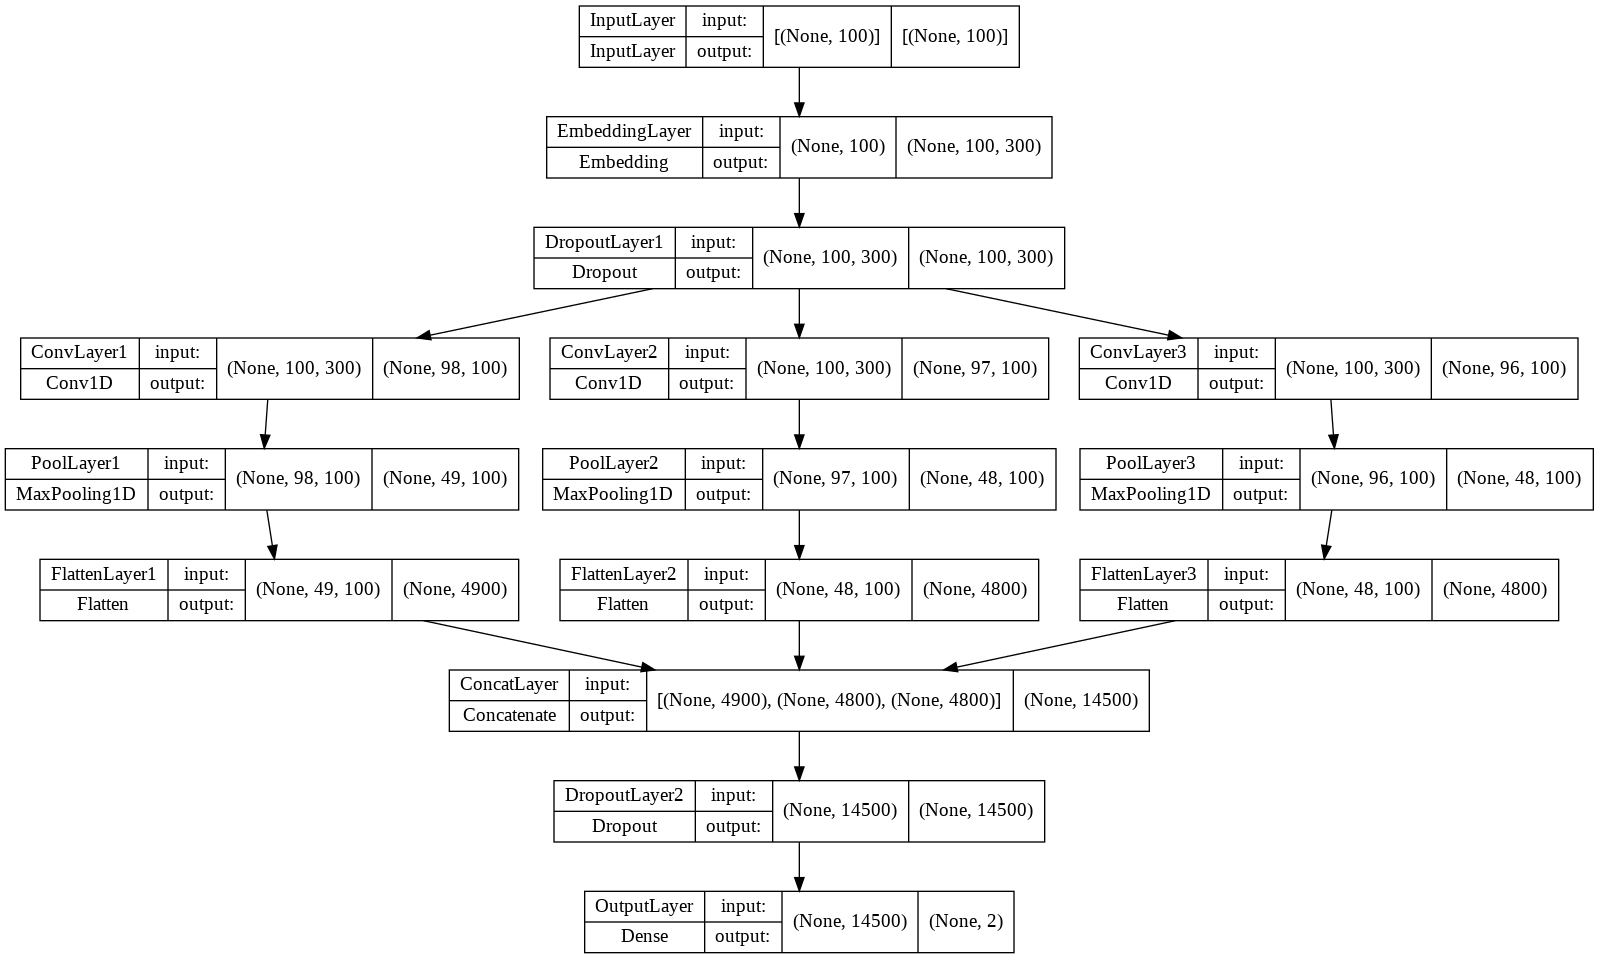

In [ ]:
# Plot the model
plot_model(cnn_w2v_model, show_shapes=True, show_layer_names=True)

**Set up a Learning Rate Scheduler and train the CNN Model**

The model will be compiled choosing Adam as the preferred optimizer with a Learning Rate Scheduler, Categorical Crossentropy as a loss function and Accuracy as a performance metric. The model is then trained on the training subset, saving the training history to be used for plotting performance metrics.

A higher learning rate will be used first to avoid getting "stuck" at a local minimum which will then start decaying exponentially to minimize the movement and find the optimal value.

In [ ]:
# Set up a Learning Rate Exponential Decay Schedule
epoch_steps = X_train_w2v.shape[0] * (1-val_pct) / batch_size # the number of steps of each epoch
total_steps = epoch_steps * num_epochs # Total training steps
decay_steps = total_steps * 0.05 # The decay steps
initial_lr = 0.00005 # Starting learning rate
decay_rate = 0.8 # The decaying rate
# Set LearningRateScheduler
lr_schedule = ExponentialDecay(initial_learning_rate=initial_lr,
                               decay_steps=decay_steps, decay_rate=decay_rate,
                               staircase=True)

In [ ]:
# Train the Model
# Specify loss function, optimizer, and performance metrics
cnn_w2v_model.compile(optimizer=Adam(learning_rate = lr_schedule),
                  loss='categorical_crossentropy', metrics=['acc'])

# Train the model and store the history
cnn_w2v_history = cnn_w2v_model.fit(X_train_w2v, y_train_w2v, batch_size=batch_size,
                            epochs=num_epochs, validation_split=val_pct)

Epoch 1/90
27/27 [==============================] - 13s 24ms/step - loss: 0.6825 - acc: 0.5406 - val_loss: 0.6836 - val_acc: 0.5445
Epoch 2/90
27/27 [==============================] - 0s 8ms/step - loss: 0.6680 - acc: 0.6165 - val_loss: 0.6756 - val_acc: 0.6126
Epoch 3/90
27/27 [==============================] - 0s 8ms/step - loss: 0.6574 - acc: 0.6492 - val_loss: 0.6678 - val_acc: 0.6545
Epoch 4/90
27/27 [==============================] - 0s 8ms/step - loss: 0.6453 - acc: 0.6661 - val_loss: 0.6626 - val_acc: 0.6597
Epoch 5/90
27/27 [==============================] - 0s 8ms/step - loss: 0.6347 - acc: 0.6766 - val_loss: 0.6567 - val_acc: 0.6492
Epoch 6/90
27/27 [==============================] - 0s 7ms/step - loss: 0.6270 - acc: 0.6719 - val_loss: 0.6517 - val_acc: 0.6492
Epoch 7/90
27/27 [==============================] - 0s 8ms/step - loss: 0.6180 - acc: 0.6836 - val_loss: 0.6476 - val_acc: 0.6545
Epoch 8/90
27/27 [==============================] - 0s 8ms/step - loss: 0.6099 - acc: 0.

**Plot the model's training history**

Using the training history dictionary, the accuracy and loss can be plotted to observe the model's performance during training.

**Load the training and validation accuracy and loss from the training history**

In [ ]:
# Load the history dictionary
cnn_w2v_hist_dict = cnn_w2v_history.history
# Store the performance metrics
cnn_w2v_acc = cnn_w2v_hist_dict['acc'] # Accuracy
cnn_w2v_val_acc = cnn_w2v_hist_dict['val_acc'] # Validation Accuracy
cnn_w2v_loss = cnn_w2v_hist_dict['loss'] # Loss
cnn_w2v_val_loss = cnn_w2v_hist_dict['val_loss'] # Validation Loss
# Get the number of epochs
epochs = range(1, len(cnn_w2v_acc) + 1)

**Plot training and validation loss**

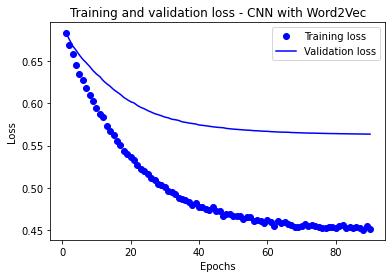

In [ ]:
# Training and validation loss
plt.plot(epochs, cnn_w2v_loss, 'bo', label='Training loss') # Training Loss
plt.plot(epochs, cnn_w2v_val_loss, 'b', label='Validation loss') # Validation Loss
# Set title and labels
plt.title('Training and validation loss - CNN with Word2Vec')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

**Plot training and validation accuracy**

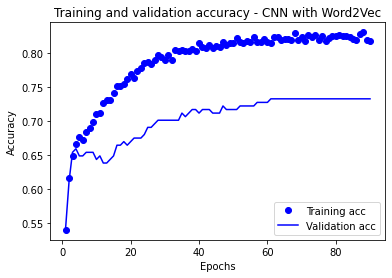

In [ ]:
# Clear current figure
plt.clf()
# Training and validation accuracy
plt.plot(epochs, cnn_w2v_acc, 'bo', label='Training acc') # Training Accuracy
plt.plot(epochs, cnn_w2v_val_acc, 'b', label='Validation acc') # Validation Accuracy
# Set title and labels
plt.title('Training and validation accuracy - CNN with Word2Vec')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

**Test the CNN model**

The trained model will be tested on the test subset, measuring its performance using the Confusion Matrix, Precision, Recall, Accuracy, and F1 Score.

Evaluate on test data


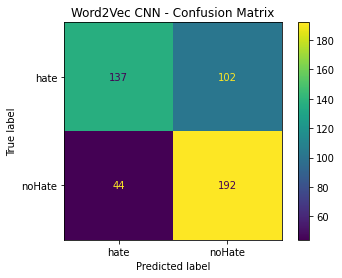

W2V CNN Hate Precision:0.76 W2V CNN No Hate Precision:0.65
W2V CNN Hate Recall:0.57 W2V CNN No Hate Recall:0.81
W2V CNN Hate F1 Score:0.65 W2V CNN No Hate F1 Score:0.72
W2V CNN Hate Accuracy:0.57 W2V CNN No Hate Accuracy:0.81
W2V CNN Overall Accuracy:0.69


In [ ]:
# Evaluate the model on the test subset
print("Evaluate on test data")
# Store the predictions 
cnn_w2v_pred = cnn_w2v_model.predict(X_test_w2v)
# Convert pred to boolean
y_pred_bool_w2v = np.argmax(cnn_w2v_pred, axis=1)

# Print the Confusion Matrix
cm = confusion_matrix(y_test_w2v_num, y_pred_bool_w2v) # Calculate CM
# Generate CM Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['hate', 'noHate']) # Generate CM Display
disp.plot()
plt.title('Word2Vec CNN - Confusion Matrix') # Set Title
# Show the plot
plt.show()

# Calculate Precision and Recall Scores
pc_scr = np.ndarray.round(precision_score(y_test_w2v_num, y_pred_bool_w2v, average=None),2)
rc_scr = np.ndarray.round(recall_score(y_test_w2v_num, y_pred_bool_w2v, average=None),2)
# Print Precision and Recall Scores
print("W2V CNN Hate Precision:"+str(pc_scr[0])+" W2V CNN No Hate Precision:"
+str(pc_scr[1])+"\nW2V CNN Hate Recall:"+str(rc_scr[0])
+" W2V CNN No Hate Recall:"+str(rc_scr[1]))
# Calculate the F1 Scores
f1_scr = np.ndarray.round(f1_score(y_test_w2v_num, y_pred_bool_w2v, average=None),2)
# Print F1 Scores
print("W2V CNN Hate F1 Score:"+str(f1_scr[0])+" W2V CNN No Hate F1 Score:"+str(f1_scr[1]))
# Calculate Accuracy
class_acc = (cm.diagonal()/cm.sum(axis=1)).round(2) # Class Accuracy
all_acc = round(accuracy_score(y_test_w2v_num, y_pred_bool_w2v),2) # Overall Accuracy
# Print Accuracy
print("W2V CNN Hate Accuracy:"+str(class_acc[0])+" W2V CNN No Hate Accuracy:"
+str(class_acc[1])+"\nW2V CNN Overall Accuracy:"+str(all_acc))

Using Word2Vec embeddings with CNN improved overall the model's ability to correctly classify both Hate and No Hate sentences, compared to the CNN model with randomly initialized word embeddings. Although the model correctly classified the vast majority of No Hate sentences, the model still had a hard time recognizing Hate sentences, having an overall accuracy of 69%, a Hate accuracy of 57%, and a No Hate accuracy of 81%.

#### Test the Long Short-Term Memory Model with the Word2Vec embeddings

**Set up Hyperparameters**

In [ ]:
# Percentage of the training data to use for validation
val_pct = 0.1
# The units of the LSTM layer (dimension)
lstm_dim = 128
# Dropout keep probability
dropout_prob = 0.2
# Batch Size
batch_size = 64
# Number of training epochs
num_epochs = 100

**Build the model**

In [ ]:
# Set up parameters for Keras layers
sequence_length = X_train_w2v.shape[1] # Length of input sequences
input_shape = (sequence_length,) # Shape of the Input layer
vocab_size = num_tokens # The input dimension of the embedding layer 
num_classes = y_train_w2v.shape[1] # Number of classes for the output layer

# Print layer information
print("Sequence Length: {}".format(sequence_length))
print("Input Shape: {}".format(input_shape))
print("Vocabulary Size: {}".format(vocab_size))
print("Embedding Size: {}".format(embedding_dim))
print("Number of Classes: {}".format(num_classes))

# Create Keras Model Layers
# The Input Layer
inputLayer = Input(shape=input_shape, dtype='float32', name='InputLayer')
# One Embedding Layer with Word2Vec word embeddings
embLayer = Embedding(vocab_size, embedding_dim,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=sequence_length, 
                     trainable=False, name='EmbeddingLayer')(inputLayer)
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer1')(embLayer)
# One LSTM Layer of size 128
lstmLayer = LSTM(lstm_dim,name='LSTMLayer')(dropLayer)
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer2')(lstmLayer)
# The Output layer
outputLayer = Dense(num_classes, activation='softmax', name='OutputLayer')(dropLayer)

# Group layers into the Model object
lstm_w2v_model = Model(inputLayer, outputLayer)
# Print model summary
lstm_w2v_model.summary()

Sequence Length: 100
Input Shape: (100,)
Vocabulary Size: 5549
Embedding Size: 300
Number of Classes: 2
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 100)]             0         
                                                                 
 EmbeddingLayer (Embedding)  (None, 100, 300)          1664700   
                                                                 
 DropoutLayer1 (Dropout)     (None, 100, 300)          0         
                                                                 
 LSTMLayer (LSTM)            (None, 128)               219648    
                                                                 
 DropoutLayer2 (Dropout)     (None, 128)               0         
                                                                 
 OutputLayer (Dense)         (None, 2)                 258       
                     

**Visualise the LSTM Model**

The Keras model can be visualised using the plot_model function from Keras Visualisation Utilities. Visualising the model is a good practice as it helps to confirm layers' order and shapes.

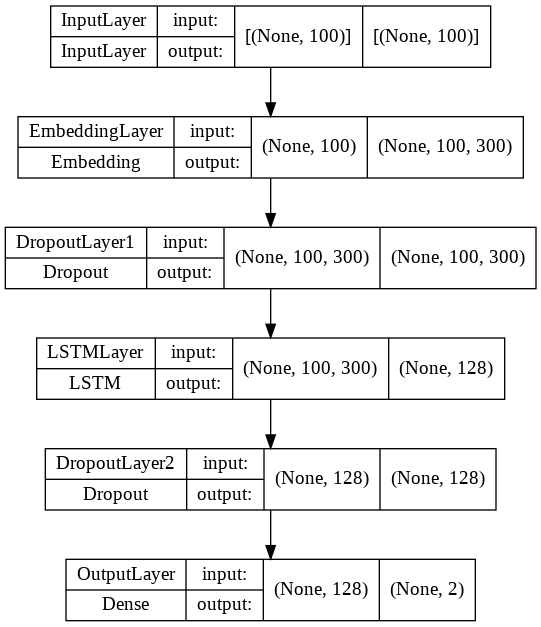

In [ ]:
# Plot the model
plot_model(lstm_w2v_model, show_shapes=True, show_layer_names=True)

**Set up a Learning Rate Scheduler and train the LSTM Model**

The model will be compiled choosing Adam as the preferred optimizer with a Learning Rate Scheduler, Categorical Crossentropy as a loss function and Accuracy as a performance metric. The model is then trained on the training subset, saving the training history to be used for plotting performance metrics.

Similarly, a higher learning rate will be used first to avoid getting "stuck" at a local minimum which will then start decaying exponentially to minimize the movement and find the optimal value.

In [ ]:
# Set up a Learning Rate Exponential Decay Schedule
epoch_steps = X_train_w2v.shape[0] * (1-val_pct) / batch_size # the number of steps of each epoch
total_steps = epoch_steps * num_epochs # Total training steps
decay_steps = total_steps * 0.05 # The decay steps
initial_lr = 0.0001 # Starting learning rate
decay_rate = 0.8 # The decaying rate
# Set LearningRateScheduler
lr_schedule = ExponentialDecay(initial_learning_rate=initial_lr,
                               decay_steps=decay_steps, decay_rate=decay_rate,
                               staircase=True)

In [ ]:
# Train the Model
# Specify loss function, optimizer, and performance metrics
lstm_w2v_model.compile(optimizer=Adam(learning_rate=lr_schedule),
                  loss='categorical_crossentropy', metrics=['acc'])

# Train the model and store the history
lstm_w2v_history = lstm_w2v_model.fit(X_train_w2v, y_train_w2v, batch_size=batch_size,
                            epochs=num_epochs, validation_split=val_pct)

Epoch 1/100
27/27 [==============================] - 3s 28ms/step - loss: 0.6840 - acc: 0.5738 - val_loss: 0.6816 - val_acc: 0.5759
Epoch 2/100
27/27 [==============================] - 0s 9ms/step - loss: 0.6636 - acc: 0.6165 - val_loss: 0.6673 - val_acc: 0.6126
Epoch 3/100
27/27 [==============================] - 0s 9ms/step - loss: 0.6374 - acc: 0.6818 - val_loss: 0.6417 - val_acc: 0.6806
Epoch 4/100
27/27 [==============================] - 0s 9ms/step - loss: 0.5955 - acc: 0.7361 - val_loss: 0.5962 - val_acc: 0.7173
Epoch 5/100
27/27 [==============================] - 0s 9ms/step - loss: 0.5624 - acc: 0.7350 - val_loss: 0.5823 - val_acc: 0.7330
Epoch 6/100
27/27 [==============================] - 0s 9ms/step - loss: 0.5390 - acc: 0.7513 - val_loss: 0.5641 - val_acc: 0.7539
Epoch 7/100
27/27 [==============================] - 0s 9ms/step - loss: 0.5223 - acc: 0.7624 - val_loss: 0.5560 - val_acc: 0.7330
Epoch 8/100
27/27 [==============================] - 0s 9ms/step - loss: 0.5049 - 

**Plot the model's training history**

Using the training history dictionary, the accuracy and loss can be plotted to observe the model's performance during training.

**Load the training and validation accuracy and loss from the training history**

In [ ]:
# Load the history dictionary
lstm_w2v_hist_dict = lstm_w2v_history.history
# Store the performance metrics
lstm_w2v_acc = lstm_w2v_hist_dict['acc'] # Accuracy
lstm_w2v_val_acc = lstm_w2v_hist_dict['val_acc'] # Validation Accuracy
lstm_w2v_loss = lstm_w2v_hist_dict['loss'] # Loss
lstm_w2v_val_loss = lstm_w2v_hist_dict['val_loss'] # Validation Loss
# Get the number of epochs
epochs = range(1, len(lstm_w2v_acc) + 1)

**Plot training and validation loss**

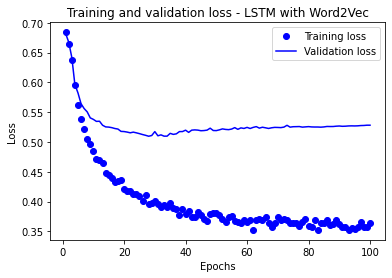

In [ ]:
# Training and validation loss
plt.plot(epochs, lstm_w2v_loss, 'bo', label='Training loss') # Training Loss
plt.plot(epochs, lstm_w2v_val_loss, 'b', label='Validation loss') # Validation Loss
# Set title and labels
plt.title('Training and validation loss - LSTM with Word2Vec')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

**Plot training and validation accuracy**

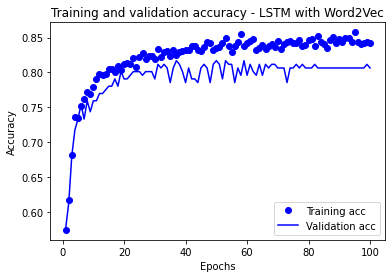

In [ ]:
# Clear current figure
plt.clf()
# Training and validation accuracy
plt.plot(epochs, lstm_w2v_acc, 'bo', label='Training acc') # Training Accuracy
plt.plot(epochs, lstm_w2v_val_acc, 'b', label='Validation acc') # Validation Accuracy
# Set title and labels
plt.title('Training and validation accuracy - LSTM with Word2Vec')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

**Test the LSTM model**

The trained model will be tested on the test subset, measuring its performance using the Confusion Matrix, Precision, Recall, Accuracy, and F1 Score.

Evaluate on test data


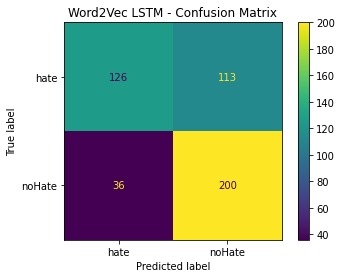

W2V LSTM Hate Precision:0.78 W2V LSTM No Hate Precision:0.64
W2V LSTM Hate Recall:0.53 W2V LSTM No Hate Recall:0.85
W2V LSTM Hate F1 Score:0.63 W2V LSTM No Hate F1 Score:0.73
W2V LSTM Hate Accuracy:0.53 W2V LSTM No Hate Accuracy:0.85
W2V LSTM Overall Accuracy:0.69


In [ ]:
# Evaluate the model on the test subset
print("Evaluate on test data")
# Store the predictions
lstm_w2v_pred = lstm_w2v_model.predict(X_test_w2v)
# Convert pred to boolean
y_pred_bool_w2v = np.argmax(lstm_w2v_pred, axis=1)

# Print the Confusion Matrix
cm = confusion_matrix(y_test_w2v_num, y_pred_bool_w2v) # Calculate CM
# Generate CM Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['hate', 'noHate']) # Generate CM Display
disp.plot()
plt.title('Word2Vec LSTM - Confusion Matrix') # Set Title
# Show the plot
plt.show()

# Calculate Precision and Recall Scores
pc_scr = np.ndarray.round(precision_score(y_test_w2v_num, y_pred_bool_w2v, average=None),2)
rc_scr = np.ndarray.round(recall_score(y_test_w2v_num, y_pred_bool_w2v, average=None),2)
# Print Precision and Recall Scores
print("W2V LSTM Hate Precision:"+str(pc_scr[0])+" W2V LSTM No Hate Precision:"
+str(pc_scr[1])+"\nW2V LSTM Hate Recall:"+str(rc_scr[0])
+" W2V LSTM No Hate Recall:"+str(rc_scr[1]))
# Calculate the F1 Scores
f1_scr = np.ndarray.round(f1_score(y_test_w2v_num, y_pred_bool_w2v, average=None),2)
# Print F1 Scores
print("W2V LSTM Hate F1 Score:"+str(f1_scr[0])+" W2V LSTM No Hate F1 Score:"+str(f1_scr[1]))
# Calculate Accuracy
class_acc = (cm.diagonal()/cm.sum(axis=1)).round(2) # Class Accuracy
all_acc = round(accuracy_score(y_test_w2v_num, y_pred_bool_w2v),2) # Overall Accuracy
# Print Accuracy
print("W2V LSTM Hate Accuracy:"+str(class_acc[0])+" W2V LSTM No Hate Accuracy:"
+str(class_acc[1])+"\nW2V LSTM Overall Accuracy:"+str(all_acc))

Using Word2Vec embeddings with LSTM greatly improved the model's ability to correctly classify No Hate sentences, compared to the LSTM model with randomly initialized word embeddings. However, it hurt the model's ability in recognizing Hate sentences, classifying correctly only half of them. 

The model returned an overall accuracy of 69%, a Hate accuracy of 53%, and a No Hate accuracy of 85%.

#### Word2Vec Embeddings Visualisation using t-SNE

The Word2Vec embeddings and the similarity between objects will be visualised using the t-SNE method. This method takes a group of high-dimensional word vectors and compresses them down to two-dimensional coordinate pairs. Ideally, similar words will be close together on the plane, while dissimilar words will have a longer distance between them.

The top fifty most common words found in hate and no Hate sentences will be visualised in a two-dimensional plane, using colour to distinguish them based on their label.

In [ ]:
# Get hate speech sentences
hate_sentences = train_df[train_df['label']=='hate'].clean_sentence.to_list()
# Get noHate speech sentences
nohate_sentences = train_df[train_df['label']=='noHate'].clean_sentence.to_list()

clean_hate_words = [] # List to store clean hate words
clean_nohate_words = [] # List to store clean no hate words

# Store the words in a list
for sent in hate_sentences: # Hate Speech words
# Go through every word found in hate speech sentences
  for word in word_tokenize(sent):
    if word.isalpha() and word not in stop_words:
      clean_hate_words.append(word)
for sent in nohate_sentences: # no Hate Speech words
# Go through every word found in nohate speech sentences
  for word in word_tokenize(sent):
    if word.isalpha() and word not in stop_words:
      clean_nohate_words.append(word)

# Instantiate Counter
h_counter = Counter(clean_hate_words) # Hate Speech
nh_counter = Counter(clean_nohate_words) # No Hate Speech

# Get the 50 most common words
# Hate Speech Words
mc_hate_words = h_counter.most_common(50)
clean_hate_words = [] # Reset list of hate words
for i in range(len(mc_hate_words)): # Go through the top 50 most common words
  clean_hate_words.append(mc_hate_words[i][0]) # Store the word
# No Hate Speech Words
mc_nohate_words = nh_counter.most_common(50)
clean_nohate_words = [] # Reset list of no hate words
for i in range(len(mc_nohate_words)): # Go through the top 50 most common words
  clean_nohate_words.append(mc_nohate_words[i][0]) # Store the word

# Get Word Vectors
# Hate Speech Words 
hate_vectors = [] # List to store w2v vectors
hate_label = [] # List to store word labels
hate_class = len(clean_hate_words)*['hate'] # Create Class for Hate Vectors
# For every hate word
for word in clean_hate_words:
    try: # If word is in w2v vocabulary
      wv = w2v_vectors.get_vector(word) # Get vector
      hate_vectors.append(wv) # Store vector
      hate_label.append(word) # Store the word
    except: # If word not in vocabulary
      pass # Continue
# NoHate Speech Words 
nohate_vectors = [] # List to store w2v vectors
nohate_label = [] # List to store word labels
nohate_class = len(clean_nohate_words)*['noHate'] # Create Class for noHate Vectors
# For every nohate word
for word in clean_nohate_words:
    try: # If word is in w2v vocabulary
      wv = w2v_vectors.get_vector(word) # Get vector
      nohate_vectors.append(wv) # Store vector
      nohate_label.append(word) # Store the word
    except: # If word not in vocabulary
      pass # Continue

# Instantiate TSNE
tsne_model = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=seed_value)
# Get new vectors
new_vectors = tsne_model.fit_transform(np.array(hate_vectors+nohate_vectors))

# Create a DataFrame containing each word and its coordinates and its class
wordvc_df = pd.concat([pd.DataFrame(new_vectors, columns=['X','Y']),pd.DataFrame(hate_label+nohate_label, columns=['Word']),
                       pd.DataFrame(hate_class+nohate_class, columns=['Class'])], axis=1)

# Change label of duplicates to Both to indicate that the word is found in both classes
idx = wordvc_df[wordvc_df.duplicated(subset=['Word'], keep=False)].index
wordvc_df.loc[idx,'Class'] = "both"
# Remove duplicate
wordvc_df = wordvc_df.drop_duplicates(subset=['Word'], keep='first')

# Create Scatter Plot
fig = px.scatter(wordvc_df, x='X', y='Y', color='Class', text='Word',
                 color_discrete_sequence=['green','red','blue'],
                 title='Word2Vec Word Embeddings')
fig.show() # Show Scatter

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



The scatterplot above shows that the majority of the words that belong to no Hate sentences are closer together and placed towards the middle of the plane. Word2Vec was able to capture the context of a few no Hate words, like youtube and video, or country and world. Although these examples highlight the advantage of using pre-trained over randomly initialised word embeddings, there are still a few words that seem like they are placed randomly in the two-dimensional plane (e.g. children and kids, or year with years). 

Offensive words that are found in hate sentences (e.g. black, blacks, negro, white) are placed together, however, while the words jew and Jews are grouped together, they are placed further away from the other group of hate speech-related words.

### Context Independent Word Embeddings - GloVe
The Global Vectors for Word Representation, or GloVe for short, is an unsupervised learning algorithm for obtaining vector representations for words. It was introduced in (Pennington, Socher and Manning, 2014) as an extension to the Word2Vec method. As stated by Pennington, Socher, and Manning in their paper, “The result is a new global log-bilinear regression model that combines the advantages of the two major model families in the literature: global matrix factorization and local context window methods”. GloVe maps words into a meaningful vector space where the distance between words is related to semantic similarity (Abad et al., 2016). According to the original paper, it outperforms other models on word analogy, word similarity, and named entity recognition tasks.

The below implementation was inspired by the Keras tutorial on pre-trained embeddings: https://keras.io/examples/nlp/pretrained_word_embeddings/

#### Create a vocabulary index

The first step is to index the vocabulary found in the dataset, by using Keras' Tokenizer.

The max sentence length is 323


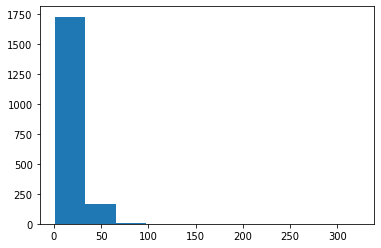

In [ ]:
# Get the length of each sentence
sent_len = [len(sent.split(" ")) for sent in train_df.clean_sentence.to_list()]
# Histogram on the sentences length
len_hist=plt.hist(sent_len)
# Print the max sentence length
print('The max sentence length is '+ str(max(sent_len)))

It is common practice to pad all sentences to the max sentence length. However, the above histogram shows that the majority of the sentences have a length between 0 and 50, with a few sentences going up to 100. Therefore, the max sentence length used for applying padding will change to 100.

In [ ]:
# Set max sentence length to 100
max_sent_len = 100
# Instantiate keras Tokenizer with out of vocabulary token (oov) equal to UNK
tokenizer = Tokenizer(oov_token='UNK')
# Create a vocabulary using the train subset
tokenizer.fit_on_texts(train_df.clean_sentence.to_list())

**Get a dictionary with each word to its index**

In [ ]:
# Get word index
word_idx = tokenizer.word_index

**Checking that the dictionary works, using a test sentence**

In [ ]:
test = ["i", "like", "every", "person", "in", "the", "world"]
[word_idx[w] for w in test]

[6, 32, 95, 164, 8, 2, 147]

#### Load the GloVe pre-trained word embeddings

Download the GloVe word embeddings and use the 200-dimensional vectors to create a dictionary mapping each word to its NumPy vector representation. The vectors were pre-trained on the combined Wikipedia 2014 + Gigaword 5th Edition corpora (6B tokens, 400K vocabulary size).

In [ ]:
# Download glove embeddings
#!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip # Unzip
# Create the dictionary mapping words to vector representations
# Create an empty dictionary
emb_idx = {}
# Open glove text file 
with open('glove.6B.200d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1) # get word and vector coefs
        coefs = np.fromstring(coefs, "f", sep=" ") # transform to numpy array
        emb_idx[word] = coefs # store word and array of coefs to the dictionary

The next step is to create a corresponding embedding matrix that can be used in the Keras Embedding layer. Entry at index i is the pre-trained vector for the word of index i in the vectorizer's vocabulary.

In [ ]:
# Embedding matrix for keras embedding layer
embedding_dim = 200 # dimension of glove vectors used
num_tokens = len(word_idx) + 1

# Create the embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
# Go through every word in the word/idx dictionary
for word, i in word_idx.items():
    # Get word's vector representation from the emb dictionary
    embedding_vector = emb_idx.get(word)
    # If vector is not none (the word exists)
    if embedding_vector is not None:
        # Store word's index and its vector representation
        embedding_matrix[i] = embedding_vector
    else:
        pass

**Check how many words from the vocabulary are not found in the pre-trained vectors**

In [ ]:
# Counter for missing words
missing_words = 0
# For every word_vector in the matrix
for word_vector in embedding_matrix:
  # If the mean is zero
  if word_vector.mean() == 0:
    missing_words+=1 # Counter
# Show number of missing words minus 1 for the OOV token
print(str(missing_words - 1) + " words from the vocabulary are missing from the Pre-Trained GloVe vectors.")

313 words from the vocabulary are missing from the Pre-Trained GloVe vectors.


The matrix can now be loaded into a Keras Embedding layer, with the trainable flag equal to False, to avoid updating it during the training.

#### Prepare the train and test subsets for training

First, the list-of-strings data must be converted to NumPy arrays of integer indices.

In [ ]:
# Convert train subset to list of sequences
X_train_glv = tokenizer.texts_to_sequences(train_df.clean_sentence.to_list())
# Pad sequences to the same length
X_train_glv = pad_sequences(X_train_glv, maxlen=max_sent_len, dtype='float32',
                            padding='pre')

# Convert test to sequences
X_test_glv = tokenizer.texts_to_sequences(test_df.clean_sentence.to_list())
# Pad examples to the same length
X_test_glv = pad_sequences(X_test_glv, maxlen=max_sent_len, dtype='float32',
                           padding='pre')



# one hot encode train labels
y_train_glv = pd.get_dummies(train_df.label).values.astype('float32')
# Convert the categorical label to numeric
y_train_glv_num = train_df.label.replace(['hate','noHate'],[0,1])

# one hot encode test labels
y_test_glv = pd.get_dummies(test_df.label).values.astype('float32')
# Convert the categorical label to numeric
y_test_glv_num = test_df.label.replace(['hate','noHate'],[0,1])

#### Test the Support Vector Machine Model with the GloVe embeddings

**Map the embedding matrix vectors to the train and test data**

Unlike the Keras Deep Learning Networks, the Scikit-learn LinearSVC model does not incorporate an embedding layer. Therefore, the mapping to the train and test data has to be applied manually.

In [ ]:
# Initialize empty lists for train and test data
X_train_svm_glv = []
X_test_svm_glv = []

# Map embedding matrix to the train subset
for sent_array in X_train_glv.astype('int32'): # For every sentence
  temp_list = [] # Initialize list to store sent vectors
  for element in sent_array: # For every element
    # Append the element's token
    temp_list.append(embedding_matrix[element].tolist())
  # Append the sentence's vector
  X_train_svm_glv.append(temp_list)
# Transform to numpy array
X_train_svm_glv = np.asarray(X_train_svm_glv, dtype='float32')
# Reduce dimension
X_train_svm_glv = np.mean(X_train_svm_glv, axis=1)

# Map embedding matrix to the test subset
for sent_array in X_test_glv.astype('int32'): # For every sentence
  temp_list = [] # Initialize list to store sent vectors
  for element in sent_array: # For every element
    # Append the element's token
    temp_list.append(embedding_matrix[element].tolist())
  # Append the sentence's vector
  X_test_svm_glv.append(temp_list)
# Transform to numpy array
X_test_svm_glv = np.asarray(X_test_svm_glv, dtype='float32')
# Reduce dimension
X_test_svm_glv = np.mean(X_test_svm_glv, axis=1)

**Create and train the SVM model**

In [ ]:
# Instatiate SVC
svm_glv = LinearSVC()
# Fit training data
svm_glv.fit(X_train_svm_glv, y_train_glv_num)
# Get prediction on test data
svm_glv_pred = svm_glv.predict(X_test_svm_glv)

**Test the SVM Model and get Performance Metrics**

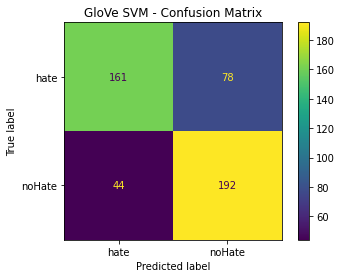

GLV SVM Hate Precision:0.79 GLV SVM No Hate Precision:0.71
GLV SVM Hate Recall:0.67 GLV SVM No Hate Recall:0.81
GLV SVM Hate F1 Score:0.73 GLV SVM No Hate F1 Score:0.76
GLV SVM Hate Accuracy:0.67 GLV SVM No Hate Accuracy:0.81
GLV SVM Overall Accuracy:0.74


In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_test_glv_num, svm_glv_pred, labels=svm_glv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['hate','noHate'])
disp.plot()
plt.title('GloVe SVM - Confusion Matrix') # Set Title
plt.show()

# Calculate Precision and Recall Scores
pc_scr = np.ndarray.round(precision_score(y_test_glv_num, svm_glv_pred, average=None),2)
rc_scr = np.ndarray.round(recall_score(y_test_glv_num, svm_glv_pred, average=None),2)
# Print Precision and Recall Scores
print("GLV SVM Hate Precision:"+str(pc_scr[0])+" GLV SVM No Hate Precision:"
+str(pc_scr[1])+"\nGLV SVM Hate Recall:"+str(rc_scr[0])
+" GLV SVM No Hate Recall:"+str(rc_scr[1]))
# Calculate the F1 Scores
f1_scr = np.ndarray.round(f1_score(y_test_glv_num, svm_glv_pred, average=None),2)
# Print F1 Scores
print("GLV SVM Hate F1 Score:"+str(f1_scr[0])+" GLV SVM No Hate F1 Score:"+str(f1_scr[1]))
# Calculate Accuracy
class_acc = (cm.diagonal()/cm.sum(axis=1)).round(2) # Class Accuracy
all_acc = round(accuracy_score(y_test_glv_num, svm_glv_pred),2) # Overall Accuracy
# Print Accuracy
print("GLV SVM Hate Accuracy:"+str(class_acc[0])+" GLV SVM No Hate Accuracy:"
+str(class_acc[1])+"\nGLV SVM Overall Accuracy:"+str(all_acc))

Using GloVe embeddings with SVM improved the model's ability to correctly classify No Hate Sentences, compared to the Bag-of-Words SVM model. However, the GloVe SVM model misclassified more Hate Sentences than the BoW SVM one. The model returned an overall accuracy of 74%, a Hate accuracy of 67%, and a No Hate accuracy of 81%. 

Unlike Deep Learning Neural Networks, traditional Machine Learning models like SVM, cannot handle three-dimensional data. The embedding vectors had to be averaged to maintain the dimensionality that works with SVM, losing the spatial features of the GloVe vectors.

#### Test the Convolutional Neural Network Model with the GloVe embeddings

**Set up hyperparameters**

In [ ]:
# Percentage of the training data to use for validation
val_pct = 0.1
# Number of filters per filter size
num_filters = 100
# Dropout keep probability
dropout_prob = 0.2
# Batch Size
batch_size = 64
# Number of training epochs
num_epochs = 100

**Build the model**

In [ ]:
# Set up parameters for Keras layers
sequence_length = X_train_glv.shape[1] # Length of input sequences
input_shape = (sequence_length,) # Shape of the Input layer
vocab_size = num_tokens # The input dimension of the embedding layer 
num_classes = y_train_glv.shape[1] # Number of classes for the output layer

# Print layer information
print("Sequence Length: {}".format(sequence_length))
print("Input Shape: {}".format(input_shape))
print("Vocabulary Size: {}".format(vocab_size))
print("Embedding Size: {}".format(embedding_dim))
print("Number of Classes: {}".format(num_classes))

# Create Keras Model Layers
# The Input Layer
inputLayer = Input(shape=input_shape, dtype='float32', name='InputLayer')
# One Embedding Layer with GloVe word embeddings
embLayer = Embedding(vocab_size, embedding_dim,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=sequence_length, 
                     trainable=False, name='EmbeddingLayer')(inputLayer)
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer1')(embLayer)
# Three pairs of Convolution and Pool layers, each one flattened
# First Pair, with kernel size 3
pairOneLayer = Conv1D(num_filters, 3, activation='relu',
                      name='ConvLayer1')(dropLayer) # Convolution Layer
pairOneLayer = MaxPooling1D(name='PoolLayer1')(pairOneLayer) # Pooling Layer
pairOneLayer = Flatten(name='FlattenLayer1')(pairOneLayer) # Flatten Layer
# Second Pair, with kernel size 4
pairTwoLayer = Conv1D(num_filters, 4, activation='relu',
                      name='ConvLayer2')(dropLayer) # Convolution Layer
pairTwoLayer = MaxPooling1D(name='PoolLayer2')(pairTwoLayer) # Pooling Layer
pairTwoLayer = Flatten(name='FlattenLayer2')(pairTwoLayer) # Flatten Layer
# Third Pair, with kernel size 5
pairThreeLayer = Conv1D(num_filters, 5, activation='relu',
                      name='ConvLayer3')(dropLayer) # Convolution Layer
pairThreeLayer = MaxPooling1D(name='PoolLayer3')(pairThreeLayer) # Pooling Layer
pairThreeLayer = Flatten(name='FlattenLayer3')(pairThreeLayer) # Flatten Layer
# Concatenate the three pairs
concLayer = Concatenate(name='ConcatLayer')([pairOneLayer,pairTwoLayer,pairThreeLayer])
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer2')(concLayer)
# The Output layer
outputLayer = Dense(num_classes, activation='softmax', name='OutputLayer')(dropLayer)

# Group layers into the Model object
cnn_glv_model = Model(inputLayer, outputLayer)
# Print model summary
cnn_glv_model.summary()

Sequence Length: 100
Input Shape: (100,)
Vocabulary Size: 5549
Embedding Size: 200
Number of Classes: 2
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 EmbeddingLayer (Embedding)     (None, 100, 200)     1109800     ['InputLayer[0][0]']             
                                                                                                  
 DropoutLayer1 (Dropout)        (None, 100, 200)     0           ['EmbeddingLayer[0][0]']         
                                                                                                  
 ConvLayer1 (Conv1D)            (None, 98, 100)      60100       ['DropoutLayer1[0][0]'

**Visualise the CNN Model**

The Keras model can be visualised using the plot_model function from Keras Visualisation Utilities. Visualising the model is a good practice as it helps to confirm layers' order and shapes.

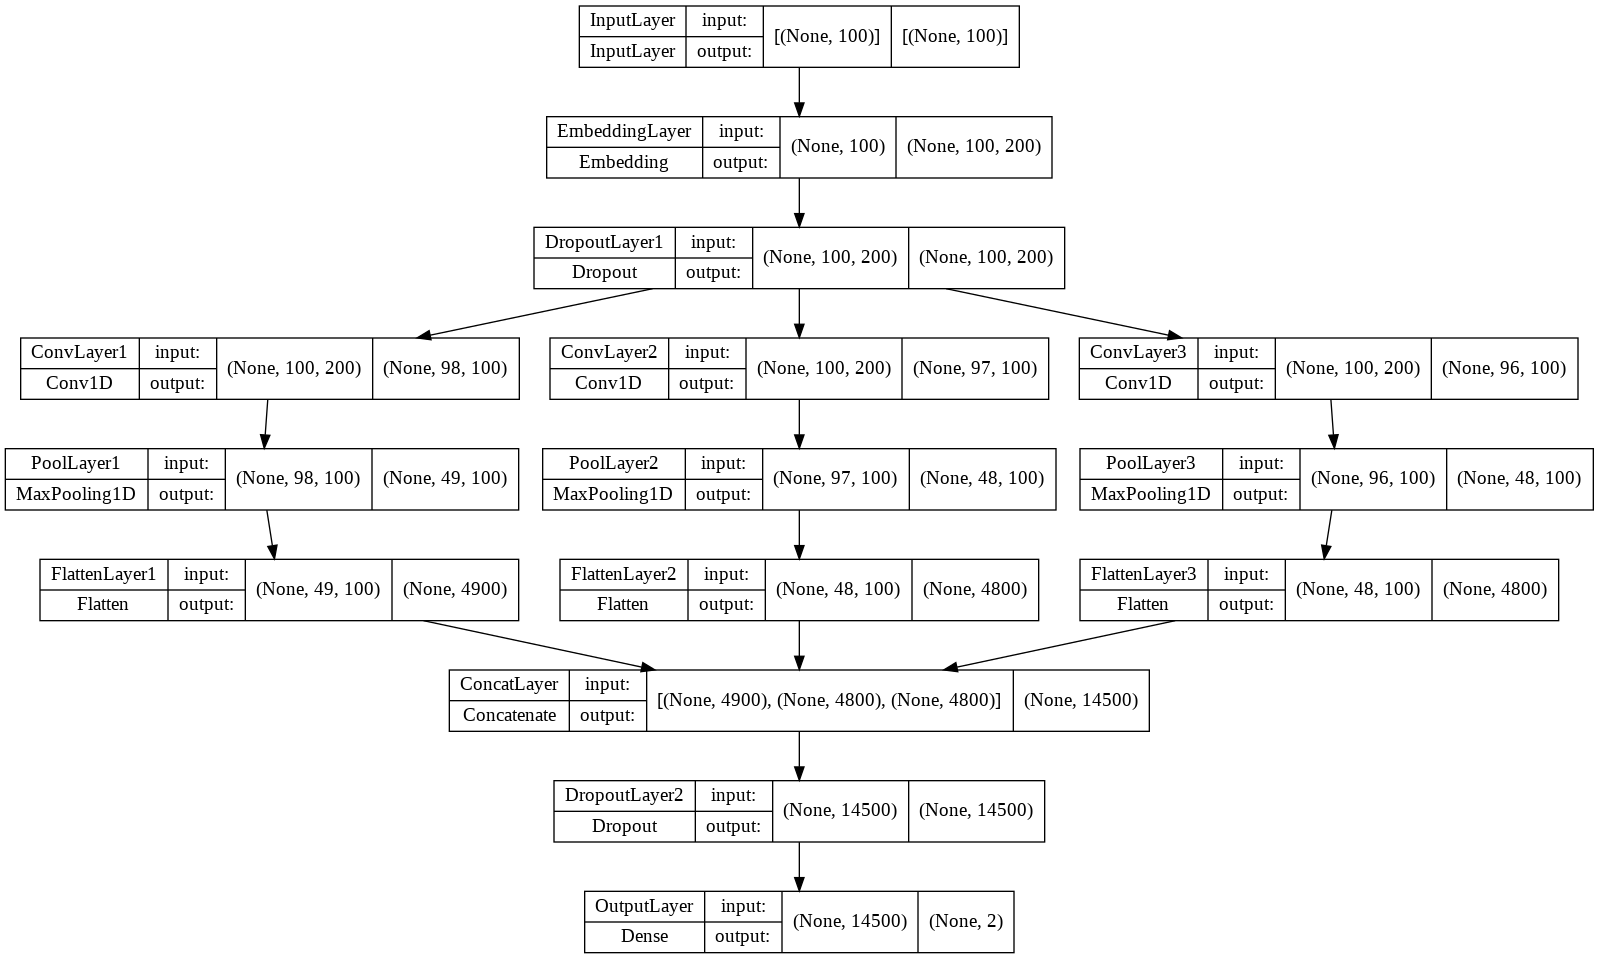

In [ ]:
# Plot the model
plot_model(cnn_glv_model, show_shapes=True, show_layer_names=True)

**Set up a Learning Rate Scheduler and train the CNN Model**

The model will be compiled choosing Adam as the preferred optimizer with a Learning Rate Scheduler, Categorical Crossentropy as a loss function and Accuracy as a performance metric. The model is then trained on the training subset, saving the training history to be used for plotting performance metrics.

Similarly, a higher learning rate will be used first to avoid getting "stuck" at a local minimum which will then start decaying exponentially to minimize the movement and find the optimal value.

In [ ]:
# Set up a Learning Rate Exponential Decay Schedule
epoch_steps = X_train_glv.shape[0] * (1-val_pct) / batch_size # the number of steps of each epoch
total_steps = epoch_steps * num_epochs # Total training steps
decay_steps = total_steps * 0.05 # The decay steps
initial_lr = 0.00006 # Starting learning rate
decay_rate = 0.85 # The decaying rate
# Set LearningRateScheduler
lr_schedule = ExponentialDecay(initial_learning_rate=initial_lr,
                               decay_steps=decay_steps, decay_rate=decay_rate,
                               staircase=True)

In [ ]:
# Train the Model
# Specify loss function, optimizer, and performance metrics
cnn_glv_model.compile(optimizer=Adam(learning_rate = lr_schedule),
                  loss='categorical_crossentropy', metrics=['acc'])

# Train the model and store the history
cnn_glv_history = cnn_glv_model.fit(X_train_glv, y_train_glv, batch_size=batch_size,
                            epochs=num_epochs, validation_split=val_pct)

Epoch 1/100
27/27 [==============================] - 1s 23ms/step - loss: 0.6737 - acc: 0.6089 - val_loss: 0.6794 - val_acc: 0.6230
Epoch 2/100
27/27 [==============================] - 0s 6ms/step - loss: 0.6509 - acc: 0.6404 - val_loss: 0.6598 - val_acc: 0.6283
Epoch 3/100
27/27 [==============================] - 0s 6ms/step - loss: 0.6353 - acc: 0.6550 - val_loss: 0.6502 - val_acc: 0.6230
Epoch 4/100
27/27 [==============================] - 0s 6ms/step - loss: 0.6139 - acc: 0.6900 - val_loss: 0.6439 - val_acc: 0.6230
Epoch 5/100
27/27 [==============================] - 0s 6ms/step - loss: 0.6061 - acc: 0.6848 - val_loss: 0.6404 - val_acc: 0.6492
Epoch 6/100
27/27 [==============================] - 0s 6ms/step - loss: 0.5947 - acc: 0.7023 - val_loss: 0.6300 - val_acc: 0.6283
Epoch 7/100
27/27 [==============================] - 0s 6ms/step - loss: 0.5798 - acc: 0.7210 - val_loss: 0.6251 - val_acc: 0.6387
Epoch 8/100
27/27 [==============================] - 0s 6ms/step - loss: 0.5668 - 

**Plot the model's training history**

Using the training history dictionary, the accuracy and loss can be plotted to observe the model's performance during training.

**Load the training and validation accuracy and loss from the training history**

In [ ]:
# Load the history dictionary
cnn_glv_hist_dict = cnn_glv_history.history
# Store the performance metrics
cnn_glv_acc = cnn_glv_hist_dict['acc'] # Accuracy
cnn_glv_val_acc = cnn_glv_hist_dict['val_acc'] # Validation Accuracy
cnn_glv_loss = cnn_glv_hist_dict['loss'] # Loss
cnn_glv_val_loss = cnn_glv_hist_dict['val_loss'] # Validation Loss
# Get the number of epochs
epochs = range(1, len(cnn_glv_acc) + 1)

**Plot training and validation loss**

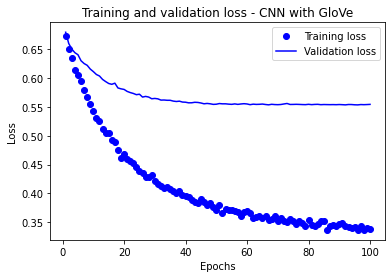

In [ ]:
# Training and validation loss
plt.plot(epochs, cnn_glv_loss, 'bo', label='Training loss') # Training Loss
plt.plot(epochs, cnn_glv_val_loss, 'b', label='Validation loss') # Validation Loss
# Set title and labels
plt.title('Training and validation loss - CNN with GloVe')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

**Plot training and validation accuracy**

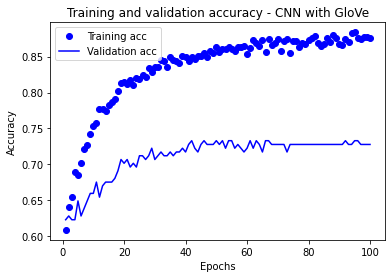

In [ ]:
# Clear current figure
plt.clf()
# Training and validation accuracy
plt.plot(epochs, cnn_glv_acc, 'bo', label='Training acc') # Training Accuracy
plt.plot(epochs, cnn_glv_val_acc, 'b', label='Validation acc') # Validation Accuracy
# Set title and labels
plt.title('Training and validation accuracy - CNN with GloVe')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

**Test the CNN model**

The trained model will be tested on the test subset, measuring its performance using the Confusion Matrix, Precision, Recall, Accuracy, and F1 Score.

Evaluate on test data


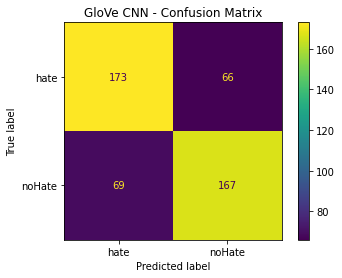

GLV CNN Hate Precision:0.71 GLV CNN No Hate Precision:0.72
GLV CNN Hate Recall:0.72 GLV CNN No Hate Recall:0.71
GLV CNN Hate F1 Score:0.72 GLV CNN No Hate F1 Score:0.71
GLV CNN Hate Accuracy:0.72 GLV CNN No Hate Accuracy:0.71
GLV CNN Overall Accuracy:0.72


In [ ]:
# Evaluate the model on the test subset
print("Evaluate on test data")
# Store the predictions 
cnn_glv_pred = cnn_glv_model.predict(X_test_glv)
# Convert pred to boolean
y_pred_bool_glv = np.argmax(cnn_glv_pred, axis=1)

# Print the Confusion Matrix
cm = confusion_matrix(y_test_glv_num, y_pred_bool_glv) # Calculate CM
# Generate CM Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['hate', 'noHate']) # Generate CM Display
disp.plot()
plt.title('GloVe CNN - Confusion Matrix') # Set Title
# Show the plot
plt.show()

# Calculate Precision and Recall Scores
pc_scr = np.ndarray.round(precision_score(y_test_glv_num, y_pred_bool_glv, average=None),2)
rc_scr = np.ndarray.round(recall_score(y_test_glv_num, y_pred_bool_glv, average=None),2)
# Print Precision and Recall Scores
print("GLV CNN Hate Precision:"+str(pc_scr[0])+" GLV CNN No Hate Precision:"
+str(pc_scr[1])+"\nGLV CNN Hate Recall:"+str(rc_scr[0])
+" GLV CNN No Hate Recall:"+str(rc_scr[1]))
# Calculate the F1 Scores
f1_scr = np.ndarray.round(f1_score(y_test_glv_num, y_pred_bool_glv, average=None),2)
# Print F1 Scores
print("GLV CNN Hate F1 Score:"+str(f1_scr[0])+" GLV CNN No Hate F1 Score:"+str(f1_scr[1]))
# Calculate Accuracy
class_acc = (cm.diagonal()/cm.sum(axis=1)).round(2) # Class Accuracy
all_acc = round(accuracy_score(y_test_glv_num, y_pred_bool_glv),2) # Overall Accuracy
# Print Accuracy
print("GLV CNN Hate Accuracy:"+str(class_acc[0])+" GLV CNN No Hate Accuracy:"
+str(class_acc[1])+"\nGLV CNN Overall Accuracy:"+str(all_acc))

Using GloVe embeddings with CNN improved overall the model's ability to correctly classify both Hate and No Hate sentences, compared to the CNN model with randomly initialized word embeddings. Although the model's performance in classifying No Hate sentences did not change, its ability to recognise and classify Hate sentences improved greatly. The model returned an overall accuracy of 72%, a Hate accuracy of 72%, and a No Hate accuracy of 71%.

#### Test the Long Short-Term Memory model with the GloVe embeddings

**Set up Hyperparameters**

In [ ]:
# Percentage of the training data to use for validation
val_pct = 0.1
# The units of the LSTM layer (dimension)
lstm_dim = 128
# Dropout keep probability
dropout_prob = 0.2
# Batch Size
batch_size = 64
# Number of training epochs
num_epochs = 150

**Build the Model**

In [ ]:
# Set up parameters for Keras layers
sequence_length = X_train_glv.shape[1] # Length of input sequences
input_shape = (sequence_length,) # Shape of the Input layer
vocab_size = num_tokens # The input dimension of the embedding layer 
num_classes = y_train_glv.shape[1] # Number of classes for the output layer

# Print layer information
print("Sequence Length: {}".format(sequence_length))
print("Input Shape: {}".format(input_shape))
print("Vocabulary Size: {}".format(vocab_size))
print("Embedding Size: {}".format(embedding_dim))
print("Number of Classes: {}".format(num_classes))

# Create Keras Model Layers
# The Input Layer
inputLayer = Input(shape=input_shape, dtype='float32', name='InputLayer')
# One Embedding Layer with GloVe word embeddings
embLayer = Embedding(vocab_size, embedding_dim,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=sequence_length, 
                     trainable=False, name='EmbeddingLayer')(inputLayer)
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer1')(embLayer)
# One LSTM Layer of size 128
lstmLayer = LSTM(lstm_dim,name='LSTMLayer')(dropLayer)
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer2')(lstmLayer)
# The Output layer
outputLayer = Dense(num_classes, activation='softmax', name='OutputLayer')(dropLayer)

# Group layers into the Model object
lstm_glv_model = Model(inputLayer, outputLayer)
# Print model summary
lstm_glv_model.summary()

Sequence Length: 100
Input Shape: (100,)
Vocabulary Size: 5549
Embedding Size: 200
Number of Classes: 2
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 100)]             0         
                                                                 
 EmbeddingLayer (Embedding)  (None, 100, 200)          1109800   
                                                                 
 DropoutLayer1 (Dropout)     (None, 100, 200)          0         
                                                                 
 LSTMLayer (LSTM)            (None, 128)               168448    
                                                                 
 DropoutLayer2 (Dropout)     (None, 128)               0         
                                                                 
 OutputLayer (Dense)         (None, 2)                 258       
                     

**Visualise the LSTM Model**

The Keras model can be visualised using the plot_model function from Keras Visualisation Utilities. Visualising the model is a good practice as it helps to confirm layers' order and shapes.

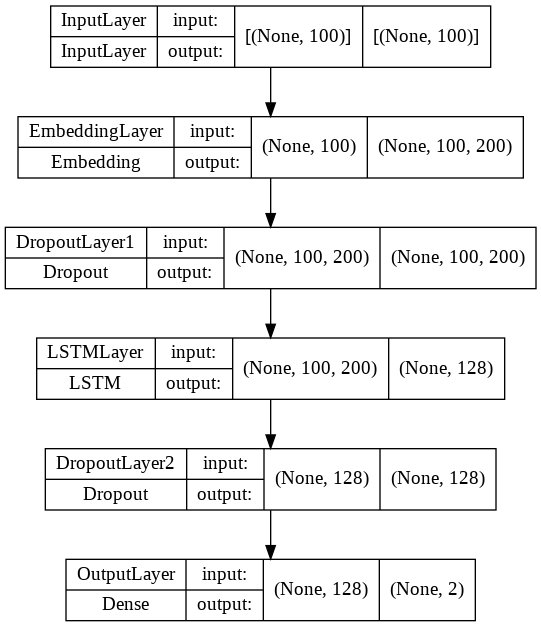

In [ ]:
# Plot the model
plot_model(lstm_glv_model, show_shapes=True, show_layer_names=True)

**Set up a Learning Rate Scheduler and train the LSTM Model**

The model will be compiled choosing Adam as the preferred optimizer with a Learning Rate Scheduler, Categorical Crossentropy as a loss function and Accuracy as a performance metric. The model is then trained on the training subset, saving the training history to be used for plotting performance metrics.

Similarly, a higher learning rate will be used first to avoid getting "stuck" at a local minimum which will then start decaying exponentially to minimize the movement and find the optimal value.

In [ ]:
# Set up a Learning Rate Exponential Decay Schedule
epoch_steps = X_train_glv.shape[0] * (1-val_pct) / batch_size # the number of steps of each epoch
total_steps = epoch_steps * num_epochs # Total training steps
decay_steps = total_steps * 0.05 # The decay steps
initial_lr = 0.0001 # Starting learning rate
decay_rate = 0.8 # The decaying rate
# Set LearningRateScheduler
lr_schedule = ExponentialDecay(initial_learning_rate=initial_lr,
                               decay_steps=decay_steps, decay_rate=decay_rate,
                               staircase=True)

In [ ]:
# Train the Model
# Specify loss function, optimizer, and performance metrics
lstm_glv_model.compile(optimizer=Adam(learning_rate=lr_schedule),
                  loss='categorical_crossentropy', metrics=['acc'])

# Train the model and store the history
lstm_glv_history = lstm_glv_model.fit(X_train_glv, y_train_glv, batch_size=batch_size,
                            epochs=num_epochs, validation_split=val_pct)

Epoch 1/150
27/27 [==============================] - 2s 27ms/step - loss: 0.6918 - acc: 0.5359 - val_loss: 0.6768 - val_acc: 0.5707
Epoch 2/150
27/27 [==============================] - 0s 9ms/step - loss: 0.6599 - acc: 0.6118 - val_loss: 0.6541 - val_acc: 0.6492
Epoch 3/150
27/27 [==============================] - 0s 9ms/step - loss: 0.6325 - acc: 0.6643 - val_loss: 0.6323 - val_acc: 0.6754
Epoch 4/150
27/27 [==============================] - 0s 9ms/step - loss: 0.6021 - acc: 0.7081 - val_loss: 0.6052 - val_acc: 0.7016
Epoch 5/150
27/27 [==============================] - 0s 9ms/step - loss: 0.5761 - acc: 0.7093 - val_loss: 0.5970 - val_acc: 0.7173
Epoch 6/150
27/27 [==============================] - 0s 9ms/step - loss: 0.5473 - acc: 0.7391 - val_loss: 0.5924 - val_acc: 0.7173
Epoch 7/150
27/27 [==============================] - 0s 9ms/step - loss: 0.5396 - acc: 0.7449 - val_loss: 0.5628 - val_acc: 0.7120
Epoch 8/150
27/27 [==============================] - 0s 9ms/step - loss: 0.5153 - 

**Plot the model's training history**

Using the training history dictionary, the accuracy and loss can be plotted to observe the model's performance during training.

**Load the training and validation accuracy and loss from the training history**

In [ ]:
# Load the history dictionary
lstm_glv_hist_dict = lstm_glv_history.history
# Store the performance metrics
lstm_glv_acc = lstm_glv_hist_dict['acc'] # Accuracy
lstm_glv_val_acc = lstm_glv_hist_dict['val_acc'] # Validation Accuracy
lstm_glv_loss = lstm_glv_hist_dict['loss'] # Loss
lstm_glv_val_loss = lstm_glv_hist_dict['val_loss'] # Validation Loss
# Get the number of epochs
epochs = range(1, len(lstm_glv_acc) + 1)

**Plot training and validation loss**

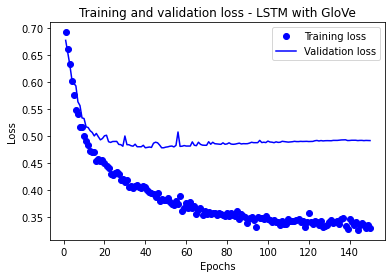

In [ ]:
# Training and validation loss
plt.plot(epochs, lstm_glv_loss, 'bo', label='Training loss') # Training Loss
plt.plot(epochs, lstm_glv_val_loss, 'b', label='Validation loss') # Validation Loss
# Set title and labels
plt.title('Training and validation loss - LSTM with GloVe')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

**Plot training and validation accuracy**

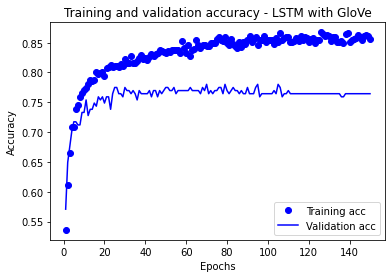

In [ ]:
# Clear current figure
plt.clf()
# Training and validation accuracy
plt.plot(epochs, lstm_glv_acc, 'bo', label='Training acc') # Training Accuracy
plt.plot(epochs, lstm_glv_val_acc, 'b', label='Validation acc') # Validation Accuracy
# Set title and labels
plt.title('Training and validation accuracy - LSTM with GloVe')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

**Test the LSTM model**

The trained model will be tested on the test subset, measuring its performance using the Confusion Matrix, Precision, Recall, Accuracy, and F1 Score.

Evaluate on test data


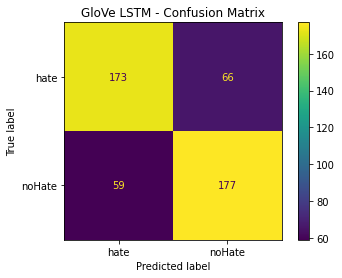

GLV LSTM Hate Precision:0.75 GLV LSTM No Hate Precision:0.73
GLV LSTM Hate Recall:0.72 GLV LSTM No Hate Recall:0.75
GLV LSTM Hate F1 Score:0.73 GLV LSTM No Hate F1 Score:0.74
GLV LSTM Hate Accuracy:0.72 GLV LSTM No Hate Accuracy:0.75
GLV LSTM Overall Accuracy:0.74


In [ ]:
# Evaluate the model on the test subset
print("Evaluate on test data")
# Store the predictions 
lstm_glv_pred = lstm_glv_model.predict(X_test_glv)
# Convert pred to boolean
y_pred_bool_glv = np.argmax(lstm_glv_pred, axis=1)

# Print the Confusion Matrix
cm = confusion_matrix(y_test_glv_num, y_pred_bool_glv) # Calculate CM
# Generate CM Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['hate', 'noHate']) # Generate CM Display
disp.plot()
plt.title('GloVe LSTM - Confusion Matrix') # Set Title
# Show the plot
plt.show()

# Calculate Precision and Recall Scores
pc_scr = np.ndarray.round(precision_score(y_test_glv_num, y_pred_bool_glv, average=None),2)
rc_scr = np.ndarray.round(recall_score(y_test_glv_num, y_pred_bool_glv, average=None),2)
# Print Precision and Recall Scores
print("GLV LSTM Hate Precision:"+str(pc_scr[0])+" GLV LSTM No Hate Precision:"
+str(pc_scr[1])+"\nGLV LSTM Hate Recall:"+str(rc_scr[0])
+" GLV LSTM No Hate Recall:"+str(rc_scr[1]))
# Calculate the F1 Scores
f1_scr = np.ndarray.round(f1_score(y_test_glv_num, y_pred_bool_glv, average=None),2)
# Print F1 Scores
print("GLV LSTM Hate F1 Score:"+str(f1_scr[0])+" GLV LSTM No Hate F1 Score:"+str(f1_scr[1]))
# Calculate Accuracy
class_acc = (cm.diagonal()/cm.sum(axis=1)).round(2) # Class Accuracy
all_acc = round(accuracy_score(y_test_glv_num, y_pred_bool_glv),2) # Overall Accuracy
# Print Accuracy
print("GLV LSTM Hate Accuracy:"+str(class_acc[0])+" GLV LSTM No Hate Accuracy:"
+str(class_acc[1])+"\nGLV LSTM Overall Accuracy:"+str(all_acc))

Using Pre-Trained GloVe embeddings with LSTM did not affect the model's ability to correctly classify No Hate sentences, compared to the LSTM model with randomly initialized word embeddings. However, the model was able to better understand the words that were related to hate speech, returning an overall accuracy of 74%, a Hate accuracy of 72%, and a No Hate accuracy of 75%.

#### GloVe Embeddings Visualisation using t-SNE
The GloVe embeddings and the similarity between objects will be visualised using the t-SNE method. This method takes a group of high-dimensional word vectors and compresses them down to two-dimensional coordinate pairs. Ideally, similar words will be close together on the plane, while dissimilar words will have a longer distance between them.

The top fifty most common words found in hate and no Hate sentences will be visualised in a two-dimensional plane, using colour to distinguish them based on their label.

In [ ]:
# Get hate speech sentences
hate_sentences = train_df[train_df['label']=='hate'].clean_sentence.to_list()
# Get noHate speech sentences
nohate_sentences = train_df[train_df['label']=='noHate'].clean_sentence.to_list()

clean_hate_words = [] # List to store clean hate words
clean_nohate_words = [] # List to store clean no hate words

# Store the words in a list
for sent in hate_sentences: # Hate Speech words
# Go through every word found in hate speech sentences
  for word in word_tokenize(sent):
    if word.isalpha() and word not in stop_words:
      clean_hate_words.append(word)
for sent in nohate_sentences: # no Hate Speech words
# Go through every word found in nohate speech sentences
  for word in word_tokenize(sent):
    if word.isalpha() and word not in stop_words:
      clean_nohate_words.append(word)

# Instantiate Counter
h_counter = Counter(clean_hate_words) # Hate Speech
nh_counter = Counter(clean_nohate_words) # No Hate Speech

# Get the 50 most common words
# Hate Speech Words
mc_hate_words = h_counter.most_common(50)
clean_hate_words = [] # Reset list of hate words
for i in range(len(mc_hate_words)): # Go through the top 50 most common words
  clean_hate_words.append(mc_hate_words[i][0]) # Store the word
# No Hate Speech Words
mc_nohate_words = nh_counter.most_common(50)
clean_nohate_words = [] # Reset list of no hate words
for i in range(len(mc_nohate_words)): # Go through the top 50 most common words
  clean_nohate_words.append(mc_nohate_words[i][0]) # Store the word

# Get Word Vectors
# Hate Speech Words 
hate_vectors = [] # List to store glove vectors
hate_label = [] # List to store word labels
hate_class = len(clean_hate_words)*['hate'] # Create Class for Hate Vectors
# For every hate word
for word in clean_hate_words:
    try: # If word is in glove vocabulary
      wv = emb_idx[word] # Get vector
      hate_vectors.append(wv) # Store vector
      hate_label.append(word) # Store the word
    except: # If word not in vocabulary
      pass # Continue
# NoHate Speech Words 
nohate_vectors = [] # List to store glove vectors
nohate_label = [] # List to store word labels
nohate_class = len(clean_nohate_words)*['noHate'] # Create Class for noHate Vectors
# For every nohate word
for word in clean_nohate_words:
    try: # If word is in glove vocabulary
      wv = emb_idx[word] # Get vector
      nohate_vectors.append(wv) # Store vector
      nohate_label.append(word) # Store the word
    except: # If word not in vocabulary
      pass # Continue

# Instantiate TSNE
tsne_model = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=seed_value)
# Get new vectors
new_vectors = tsne_model.fit_transform(np.array(hate_vectors+nohate_vectors))

# Create a DataFrame containing each word and its coordinates and its class
wordvc_df = pd.concat([pd.DataFrame(new_vectors, columns=['X','Y']),pd.DataFrame(hate_label+nohate_label, columns=['Word']),
                       pd.DataFrame(hate_class+nohate_class, columns=['Class'])], axis=1)

# Change label of duplicates to Both to indicate that the word is found in both classes
idx = wordvc_df[wordvc_df.duplicated(subset=['Word'], keep=False)].index
wordvc_df.loc[idx,'Class'] = "both"
# Remove duplicate
wordvc_df = wordvc_df.drop_duplicates(subset=['Word'], keep='first')

# Create Scatter Plot
fig = px.scatter(wordvc_df, x='X', y='Y', color='Class', text='Word',
                 color_discrete_sequence=['green','red','blue'],
                 title='GloVe Word Embeddings')
fig.show() # Show Scatter

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Similar to the Word2Vec visualisation, the scatterplot above shows that the majority of the words that belong to no Hate sentences are closer together and placed towards the middle of the plane. GloVe was able to capture the context of a few no Hate words, like youtube and video, or year and day. Although these examples highlight the advantage of using pre-trained over randomly initialised word embeddings, there are still a few words that seem like they are placed randomly in the two-dimensional plane (e.g. school and children, or children and kids).

There is a slight difference in the way offensive words were placed in the two-dimensional plane. Although words like white and black were grouped together, they were placed away from their plural versions and other offensive words found in hate speech sentences. However, GloVe was able to place together the words negro, Africa, and Jews indicating that it understood that these words are targeted toward a group of people.

### Context Dependent Word Embeddings - ELMo
Embeddings from Language Models is, as stated in (Peters et al., 2018), “a new type of deep contextualized word representation that models both (1) complex characteristics of word use (e.g., syntax and semantics), and (2) how these uses vary across linguistic contexts (i.e., to model polysemy)”. In their paper they show that ELMo can be added to existing models, achieving state-of-the-art across several NLP tasks. Unlike traditional word embeddings (e.g., GloVe), the ELMo vector assigned to a word is a function of the entire sentence containing that word. This means that the same words with different contexts can have different word vectors.

The ELMo model computes word vectors using a two-layer bidirectional LSTM model (biLSTM). Each layer has a forward pass and a backward pass. The raw text is passed as input for the first biLSTM layer. The forward pass contains information about a word and the context before the word. The backward pass contains information about a word and the context after the word. Information from both passes is then fed as input for the next biLSTM layer. The final word embedding is the weighted sum of the raw text and the vector outputs of the two biLSTM layers.

#### Load the Pre-Trained ELMo Model
The pre-trained ELMo model will be loaded from TensorFlow Hub, a library that contains many machine learning models that can be used for Transfer Learning. The model has been trained by Google on the 1 Billion Word Benchmark. Since ELMo is used only for its "raw" output, it will not be fine-tuned. This can be achieved by freezing its weights and setting trainable equal to False.

The model will be loaded using hub.Module, which only works when TensorFlow V2 behaviour is disabled, and can only be enabled again after restarting the runtime. Since TensorFlow 2 is required for the rest of the experiments, the ELMo Dataset preparation will be run once and then commented out. The prepared dataset will be loaded from files for the training of the models.

**Disable TF V2 Behavior to load the model with hub.Module**

**Requires Runtime restart to enable TF V2 again**

In [ ]:
# Import Tensorflow Compat
#import tensorflow.compat.v1 as tf
# Disable TF2 behavior to use hub.Module
#tf.disable_v2_behavior()
# Load Google's pre-trained ELMo model from TensorFlow Hub
#elmo_trained = hub.Module("https://tfhub.dev/google/elmo/3", trainable=False)

#### Prepare the dataset

Tokenize Train and Test data to Pad sequences to given max sent length

In [ ]:
# Get the length of all each sentence
#sent_len = [len(sent.split(" ")) for sent in train_df.clean_sentence.to_list()]
# Histogram on the sentences length
#len_hist=plt.hist(sent_len)
# Print the max sentence length
#print('The max sentence length is '+ str(max(sent_len)))

It is common practice to pad all sentences to the max sentence length. However, the above histogram shows that the majority of the sentences have a length between 0 and 50, with a few sentences going up to 100. Therefore, the max sentence length used for applying padding will change to 100.

In [ ]:
# Max sequence length
#max_sent_len = 100
# Batch size for creating elmo embeddings
#elmo_batch_size = 64
# Tokenize each sentence
#X_train_elmo = train_df.clean_sentence.apply(word_tokenize) # Training Data
#X_test_elmo = test_df.clean_sentence.apply(word_tokenize) # Test Data
# Pad Sequences to max length
#X_train_elmo = pad_sequences(X_train_elmo, maxlen=max_sent_len, dtype=object, value='<PAD>') # Train Data
#X_test_elmo = pad_sequences(X_test_elmo, maxlen=max_sent_len, dtype=object, value='<PAD>') # Test Data

# one hot encode train labels
y_train_elmo = pd.get_dummies(train_df.label).values.astype('float32')
# Convert the categorical label to numeric
y_train_elmo_num = train_df.label.replace(['hate','noHate'],[0,1]).astype('float32')

# one hot encode test labels
y_test_elmo = pd.get_dummies(test_df.label).values.astype('float32')
# Convert the categorical label to numeric
y_test_elmo_num = test_df.label.replace(['hate','noHate'],[0,1]).astype('float32')

**Define functions to create ELMo outputs to be fed to SVM and to Keras Models**

The functions were inspired by: https://www.analyticsvidhya.com/blog/2019/03/learn-to-use-elmo-to-extract-features-from-text/#:~:text=ELMo%20is%20a%20novel%20way,as%20well%20as%20the%20industry and were adjusted to work with this implementation.

In [ ]:
# Create inputs for SVM Model
def getElmoEmbeddings_svm(tokenized_text):
  elmo_output = elmo_trained(
      inputs={
          "tokens": tokenized_text,
          "sequence_len": tf.constant(len(tokenized_text)*[max_sent_len])
          }, 
      signature="tokens", as_dict=True)["elmo"]
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    # return average of ELMo features
    return sess.run(tf.reduce_mean(elmo_output,1))

# Create inputs for Keras Models
def getElmoEmbeddings_keras(tokenized_text):
  elmo_output = elmo_trained(
      inputs={
          "tokens": tokenized_text,
          "sequence_len": tf.constant(len(tokenized_text)*[max_sent_len])
          }, 
      signature="tokens", as_dict=True)["elmo"]
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    # return average of ELMo features
    return sess.run(elmo_output)

**Split Train and Test Data into batches to avoid running out of memory**

Because eager execution from TensorFlow 2 is disabled, the data has to be processed in batches to avoid running out of memory. This process took over 15 minutes in Google Colab Pro+. For this purpose, the files will be saved to Drive for easy loading.

In [ ]:
# Create batches of train data
#train_list = [X_train_elmo[i:i+batch_size] for i in range(0,X_train_elmo.shape[0],batch_size)]
# Create batches of test data
#test_list = [X_test_elmo[i:i+batch_size] for i in range(0,X_test_elmo.shape[0],batch_size)]

# Extract ELMo embeddings for Keras Models
#train_keras_elmo = [getElmoEmbeddings_keras(batched_sent) for batched_sent in train_list]
#test_keras_elmo = [getElmoEmbeddings_keras(batched_sent) for batched_sent in test_list]

# Extract ELMo embeddings for SVM Model
#train_svm_elmo = [getElmoEmbeddings_svm(batched_sent) for batched_sent in train_list]
#test_svm_elmo = [getElmoEmbeddings_svm(batched_sent) for batched_sent in test_list]

# Concatenate to an array
# For Keras Models
#X_train_elmo_keras = np.concatenate(train_keras_elmo, axis = 0)
#X_test_elmo_keras = np.concatenate(test_keras_elmo, axis = 0)
# For SVM Model
#X_train_elmo_svm = np.concatenate(train_svm_elmo, axis = 0)
#X_test_elmo_svm = np.concatenate(test_svm_elmo, axis = 0)

**Save the ELMo results to Google Drive so that they can be loaded fast and avoid long processing times**

In [ ]:
# Transform data PyTorch Tensors
# For Keras Models
# Train Data
#torch.save(torch.from_numpy(X_train_elmo_keras), 'X_train_elmo_keras.pt')
# Test Data
#torch.save(torch.from_numpy(X_test_elmo_keras), 'X_test_elmo_keras.pt')
# For SVM Models
# Train Data
#torch.save(torch.from_numpy(X_train_elmo_svm), 'X_train_elmo_svm.pt')
# Test Data
#torch.save(torch.from_numpy(X_test_elmo_svm), 'X_test_elmo_svm.pt')

# Copy ELMo Train and Test Tensors to Google Drive
#!cp -r /content/data/X_train_elmo_keras.pt /content/drive/MyDrive/Colab_Notebooks/Elmo_Data/X_train_elmo_keras.pt
#!cp -r /content/data/X_test_elmo_keras.pt /content/drive/MyDrive/Colab_Notebooks/Elmo_Data/X_test_elmo_keras.pt
#!cp -r /content/data/X_train_elmo_svm.pt /content/drive/MyDrive/Colab_Notebooks/Elmo_Data/X_train_elmo_svm.pt
#!cp -r /content/data/X_test_elmo_svm.pt /content/drive/MyDrive/Colab_Notebooks/Elmo_Data/X_test_elmo_svm.pt

**Load the Tensor datasets from file**

In [ ]:
# Load the four PyTorch Tensors and transform to numpy
X_train_elmo_keras=torch.load('Elmo_Data/X_train_elmo_keras.pt').numpy()
X_test_elmo_keras=torch.load('Elmo_Data/X_test_elmo_keras.pt').numpy()
X_train_elmo_svm=torch.load('Elmo_Data/X_train_elmo_svm.pt').numpy()
X_test_elmo_svm=torch.load('Elmo_Data/X_test_elmo_svm.pt').numpy()

####Test the Support Vector Machine Model with ELMo

**Create and Train the SVM Model**

In [ ]:
# Instatiate SVC
svm_elmo = LinearSVC(C=0.15)
# Fit training data
svm_elmo.fit(X_train_elmo_svm, y_train_elmo_num)
# Get prediction on test data
svm_elmo_pred = svm_elmo.predict(X_test_elmo_svm)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



**Test the SVM Model and get Performance Metrics**

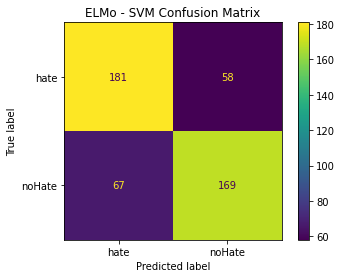

ELMo SVM Hate Precision:0.73 ELMo SVM No Hate Precision:0.74
ELMo SVM Hate Recall:0.76 ELMo SVM No Hate Recall:0.72
ELMo SVM Hate F1 Score:0.74 ELMo SVM No Hate F1 Score:0.73
ELMo SVM Hate Accuracy:0.76 ELMo SVM No Hate Accuracy:0.72
ELMo SVM Overall Accuracy:0.74


In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_test_elmo_num, svm_elmo_pred, labels=svm_elmo.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['hate','noHate'])
disp.plot()
plt.title('ELMo - SVM Confusion Matrix') # Set Title
plt.show()

# Calculate Precision and Recall Scores
pc_scr = np.ndarray.round(precision_score(y_test_elmo_num, svm_elmo_pred, average=None),2)
rc_scr = np.ndarray.round(recall_score(y_test_elmo_num, svm_elmo_pred, average=None),2)
# Print Precision and Recall Scores
print("ELMo SVM Hate Precision:"+str(pc_scr[0])+" ELMo SVM No Hate Precision:"
+str(pc_scr[1])+"\nELMo SVM Hate Recall:"+str(rc_scr[0])
+" ELMo SVM No Hate Recall:"+str(rc_scr[1]))
# Calculate the F1 Scores
f1_scr = np.ndarray.round(f1_score(y_test_elmo_num, svm_elmo_pred, average=None),2)
# Print F1 Scores
print("ELMo SVM Hate F1 Score:"+str(f1_scr[0])+" ELMo SVM No Hate F1 Score:"+str(f1_scr[1]))
# Calculate Accuracy
class_acc = (cm.diagonal()/cm.sum(axis=1)).round(2) # Class Accuracy
all_acc = round(accuracy_score(y_test_elmo_num, svm_elmo_pred),2) # Overall Accuracy
# Print Accuracy
print("ELMo SVM Hate Accuracy:"+str(class_acc[0])+" ELMo SVM No Hate Accuracy:"
+str(class_acc[1])+"\nELMo SVM Overall Accuracy:"+str(all_acc))

Using the output of ELMo with SVM improved the model's ability to correctly classify Hate Sentences, compared to the Bag-of-Words SVM model. Although its ability to classify No Hate sentences was slightly affected, the overall accuracy was increased. The model returned an overall accuracy of 74%, a Hate accuracy of 76%, and a No Hate accuracy of 72%.

Unlike Deep Learning Neural Networks, traditional Machine Learning models like SVM, cannot handle three-dimensional data. The embedding vectors had to be averaged to maintain the dimensionality that works with SVM, losing the spatial features of the ELMo vectors.

Furthermore, the fact that it takes a greater amount of time to pass the data through ELMo and use its output with SVM needs to be taken into consideration.

#### Test the Convolutional Neural Network Model with ELMo

**Set up Hyperparameters**

In [ ]:
# Set max sentence length to 150
max_sent_len = 100
# Percentage of the training data to use for validation
val_pct = 0.1
# Number of filters per filter size
num_filters = 100
# Dropout keep probability
dropout_prob = 0.2
# Batch Size
batch_size = 64
# Number of training epochs
num_epochs = 80

**Build the Model**

In [ ]:
# Set up parameters for Keras layers
sequence_length = X_train_elmo_keras.shape[1] # Length of input sequences
input_shape = (sequence_length,1024,) # Shape of the Input layer
num_classes = y_train_elmo.shape[1] # Number of classes for the output layer

# Print layer information
print("Sequence Length: {}".format(sequence_length))
print("Input Shape: {}".format(input_shape))
print("Number of Classes: {}".format(num_classes))

# Create Keras Model Layers with ELMo
inputLayer = Input(shape=input_shape, name='InputLayer')
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer1')(inputLayer)
# Three pairs of Convolution and Pool layers, each one flattened
# First Pair, with kernel size 3
pairOneLayer = Conv1D(num_filters, 3, activation='relu',
                      name='ConvLayer1')(dropLayer) # Convolution Layer
pairOneLayer = MaxPooling1D(name='PoolLayer1')(pairOneLayer) # Pooling Layer
pairOneLayer = Flatten(name='FlattenLayer1')(pairOneLayer) # Flatten Layer
# Second Pair, with kernel size 4
pairTwoLayer = Conv1D(num_filters, 4, activation='relu',
                      name='ConvLayer2')(dropLayer) # Convolution Layer
pairTwoLayer = MaxPooling1D(name='PoolLayer2')(pairTwoLayer) # Pooling Layer
pairTwoLayer = Flatten(name='FlattenLayer2')(pairTwoLayer) # Flatten Layer
# Third Pair, with kernel size 5
pairThreeLayer = Conv1D(num_filters, 5, activation='relu',
                      name='ConvLayer3')(dropLayer) # Convolution Layer
pairThreeLayer = MaxPooling1D(name='PoolLayer3')(pairThreeLayer) # Pooling Layer
pairThreeLayer = Flatten(name='FlattenLayer3')(pairThreeLayer) # Flatten Layer
# Concatenate the three pairs
concLayer = Concatenate(name='ConcatLayer')([pairOneLayer,pairTwoLayer,pairThreeLayer])
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer2')(concLayer)
# The Output layer
outputLayer = Dense(num_classes, activation='softmax', name='OutputLayer')(dropLayer)

# Group layers into the Model object
cnn_elmo_model = Model(inputLayer, outputLayer)
# Print model summary
cnn_elmo_model.summary()

Sequence Length: 100
Input Shape: (100, 1024)
Number of Classes: 2
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 100, 1024)]  0           []                               
                                                                                                  
 DropoutLayer1 (Dropout)        (None, 100, 1024)    0           ['InputLayer[0][0]']             
                                                                                                  
 ConvLayer1 (Conv1D)            (None, 98, 100)      307300      ['DropoutLayer1[0][0]']          
                                                                                                  
 ConvLayer2 (Conv1D)            (None, 97, 100)      409700      ['DropoutLayer1[0][0]']          
                         

**Visualise the CNN Model**

The Keras model can be visualised using the plot_model function from Keras Visualisation Utilities. Visualising the model is a good practice as it helps to confirm layers' order and shapes.

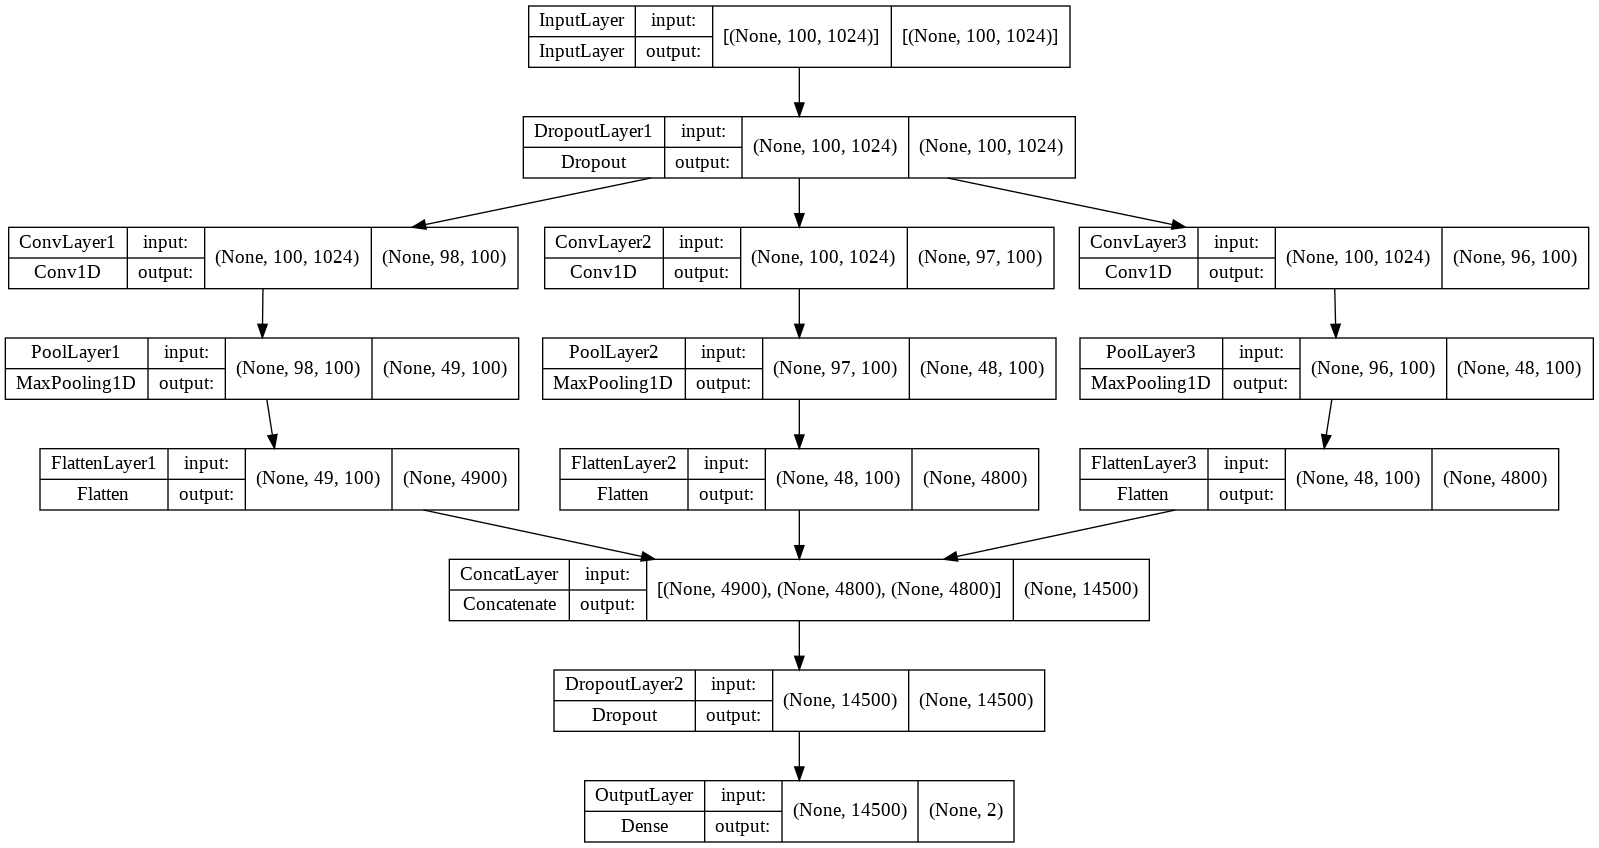

In [ ]:
# Plot the model
plot_model(cnn_elmo_model, show_shapes=True, show_layer_names=True)

**Train the CNN Model**

The model will be compiled using Adam with weight decay (AdamW) as the preferred optimizer, Categorical Crossentropy as a loss function and Accuracy as a performance metric. The model is then trained on the training subset, saving the training history to be used for plotting performance metrics.


In [ ]:
# Train the Model
# Specify loss function, optimizer, and performance metrics
cnn_elmo_model.compile(optimizer=AdamW(weight_decay=0.001, learning_rate=0.00006),
                  loss='categorical_crossentropy', metrics=['acc'])

# Train the model and store the history
cnn_elmo_history = cnn_elmo_model.fit(X_train_elmo_keras, y_train_elmo, batch_size=batch_size,
                            epochs=num_epochs, validation_split=val_pct)

Epoch 1/80
27/27 [==============================] - 2s 31ms/step - loss: 0.7268 - acc: 0.5972 - val_loss: 0.6282 - val_acc: 0.6073
Epoch 2/80
27/27 [==============================] - 1s 20ms/step - loss: 0.6179 - acc: 0.6573 - val_loss: 0.6048 - val_acc: 0.7068
Epoch 3/80
27/27 [==============================] - 1s 19ms/step - loss: 0.5622 - acc: 0.7034 - val_loss: 0.6115 - val_acc: 0.6545
Epoch 4/80
27/27 [==============================] - 1s 20ms/step - loss: 0.5219 - acc: 0.7402 - val_loss: 0.6168 - val_acc: 0.6492
Epoch 5/80
27/27 [==============================] - 1s 19ms/step - loss: 0.4942 - acc: 0.7706 - val_loss: 0.5725 - val_acc: 0.7225
Epoch 6/80
27/27 [==============================] - 1s 20ms/step - loss: 0.4730 - acc: 0.7793 - val_loss: 0.6316 - val_acc: 0.6492
Epoch 7/80
27/27 [==============================] - 1s 19ms/step - loss: 0.4688 - acc: 0.7793 - val_loss: 0.5893 - val_acc: 0.6754
Epoch 8/80
27/27 [==============================] - 1s 19ms/step - loss: 0.4218 - a

**Plot the model's training history**

Using the training history dictionary, the accuracy and loss can be plotted to observe the model's performance during training.

**Load the training and validation accuracy and loss from the training history**

In [ ]:
# Load the history dictionary
cnn_elmo_hist_dict = cnn_elmo_history.history
# Store the performance metrics
cnn_elmo_acc = cnn_elmo_hist_dict['acc'] # Accuracy
cnn_elmo_val_acc = cnn_elmo_hist_dict['val_acc'] # Validation Accuracy
cnn_elmo_loss = cnn_elmo_hist_dict['loss'] # Loss
cnn_elmo_val_loss = cnn_elmo_hist_dict['val_loss'] # Validation Loss
# Get the number of epochs
epochs = range(1, len(cnn_elmo_acc) + 1)

**Plot training and validation loss**

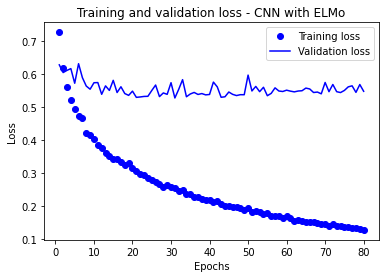

In [ ]:
# Training and validation loss
plt.plot(epochs, cnn_elmo_loss, 'bo', label='Training loss') # Training Loss
plt.plot(epochs, cnn_elmo_val_loss, 'b', label='Validation loss') # Validation Loss
# Set title and labels
plt.title('Training and validation loss - CNN with ELMo')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

**Plot training and validation accuracy**

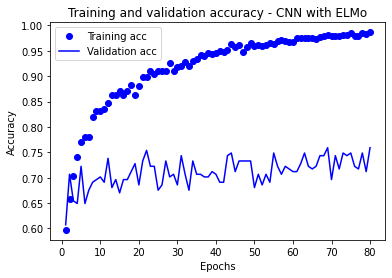

In [ ]:
# Clear current figure
plt.clf()
# Training and validation accuracy
plt.plot(epochs, cnn_elmo_acc, 'bo', label='Training acc') # Training Accuracy
plt.plot(epochs, cnn_elmo_val_acc, 'b', label='Validation acc') # Validation Accuracy
# Set title and labels
plt.title('Training and validation accuracy - CNN with ELMo')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

**Test the CNN model**

The trained model will be tested on the test subset, measuring its performance using the Confusion Matrix, Precision, Recall, Accuracy, and F1 Score.

Evaluate on test data


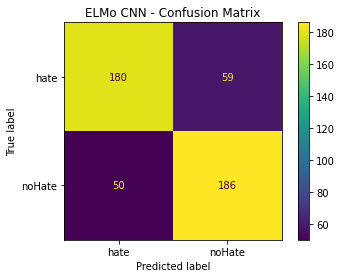

ELMo CNN Hate Precision:0.78 ELMo CNN No Hate Precision:0.76
ELMo CNN Hate Recall:0.75 ELMo CNN No Hate Recall:0.79
ELMo CNN Hate F1 Score:0.77 ELMo CNN No Hate F1 Score:0.77
ELMo CNN Hate Accuracy:0.75 ELMo CNN No Hate Accuracy:0.79
ELMo CNN Overall Accuracy:0.77


In [ ]:
# Evaluate the model on the test subset
print("Evaluate on test data")
# Store the predictions 
cnn_elmo_pred = cnn_elmo_model.predict(X_test_elmo_keras)
# Convert pred to boolean
y_pred_bool_elmo = np.argmax(cnn_elmo_pred, axis=1)

# Print the Confusion Matrix
cm = confusion_matrix(y_test_elmo_num, y_pred_bool_elmo) # Calculate CM
# Generate CM Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['hate', 'noHate']) # Generate CM Display
disp.plot()
plt.title('ELMo CNN - Confusion Matrix') # Set Title
# Show the plot
plt.show()

# Calculate Precision and Recall Scores
pc_scr = np.ndarray.round(precision_score(y_test_elmo_num, y_pred_bool_elmo, average=None),2)
rc_scr = np.ndarray.round(recall_score(y_test_elmo_num, y_pred_bool_elmo, average=None),2)
# Print Precision and Recall Scores
print("ELMo CNN Hate Precision:"+str(pc_scr[0])+" ELMo CNN No Hate Precision:"
+str(pc_scr[1])+"\nELMo CNN Hate Recall:"+str(rc_scr[0])
+" ELMo CNN No Hate Recall:"+str(rc_scr[1]))
# Calculate the F1 Scores
f1_scr = np.ndarray.round(f1_score(y_test_elmo_num, y_pred_bool_elmo, average=None),2)
# Print F1 Scores
print("ELMo CNN Hate F1 Score:"+str(f1_scr[0])+" ELMo CNN No Hate F1 Score:"+str(f1_scr[1]))
# Calculate Accuracy
class_acc = (cm.diagonal()/cm.sum(axis=1)).round(2) # Class Accuracy
all_acc = round(accuracy_score(y_test_elmo_num, y_pred_bool_elmo),2) # Overall Accuracy
# Print Accuracy
print("ELMo CNN Hate Accuracy:"+str(class_acc[0])+" ELMo CNN No Hate Accuracy:"
+str(class_acc[1])+"\nELMo CNN Overall Accuracy:"+str(all_acc))

Using the output of ELMo with CNN improved overall the model's ability to correctly classify both Hate and No Hate sentences, compared to the CNN model with randomly initialized word embeddings. Although the model's performance in classifying No Hate sentences improved slightly, its ability to recognise and classify Hate sentences greatly improved. The model returned an overall accuracy of 77%, a Hate accuracy of 75%, and a No Hate accuracy of 79%.

#### Test the Long Short-Term Memory model with ELMo

**Set up Hyperparameters**

In [ ]:
# Percentage of the training data to use for validation
val_pct = 0.1
# The units of the LSTM layer (dimension)
lstm_dim = 128
# Dropout keep probability
dropout_prob = 0.2
# Batch Size
batch_size = 64
# Number of training epochs
num_epochs = 80

**Build the Model**

In [ ]:
# Set up parameters for Keras layers
sequence_length = X_train_elmo_keras.shape[1] # Length of input sequences
input_shape = (sequence_length,1024,) # Shape of the Input layer
num_classes = y_train_elmo.shape[1] # Number of classes for the output layer

# Print layer information
print("Sequence Length: {}".format(sequence_length))
print("Input Shape: {}".format(input_shape))
print("Number of Classes: {}".format(num_classes))

# Create Keras Model Layers with ELMo
# The Input Layer
inputLayer = Input(shape=input_shape, name='InputLayer')
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer1')(inputLayer)
# One LSTM Layer of size 128
lstmLayer = LSTM(lstm_dim,name='LSTMLayer')(dropLayer)
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer2')(lstmLayer)
# The Output layer
outputLayer = Dense(num_classes, activation='softmax', name='OutputLayer')(dropLayer)

# Group layers into the Model object
lstm_elmo_model = Model(inputLayer, outputLayer)
# Print model summary
lstm_elmo_model.summary()

Sequence Length: 100
Input Shape: (100, 1024)
Number of Classes: 2
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 100, 1024)]       0         
                                                                 
 DropoutLayer1 (Dropout)     (None, 100, 1024)         0         
                                                                 
 LSTMLayer (LSTM)            (None, 128)               590336    
                                                                 
 DropoutLayer2 (Dropout)     (None, 128)               0         
                                                                 
 OutputLayer (Dense)         (None, 2)                 258       
                                                                 
Total params: 590,594
Trainable params: 590,594
Non-trainable params: 0
____________________________________________________

**Visualise the LSTM Model**

The Keras model can be visualised using the plot_model function from Keras Visualisation Utilities. Visualising the model is a good practice as it helps to confirm layers' order and shapes.

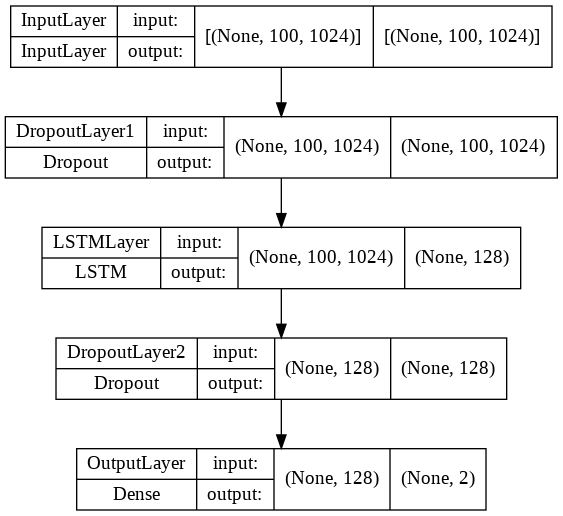

In [ ]:
# Plot the model
plot_model(lstm_elmo_model, show_shapes=True, show_layer_names=True)

**Train the LSTM Model**

The model gets compiled using Adam with weight decay (AdamW) as the preferred optimizer, Categorical Crossentropy as a loss function and Accuracy as a performance metric. The model is then trained on the training subset, saving the training history to be used for plotting performance metrics.


In [ ]:
# Train the Model
# Specify loss function, optimizer, and performance metrics
lstm_elmo_model.compile(optimizer=AdamW(weight_decay=0.001, learning_rate=0.0001),
                  loss='categorical_crossentropy', metrics=['acc'])

# Train the model and store the history
lstm_elmo_history = lstm_elmo_model.fit(X_train_elmo_keras, y_train_elmo, batch_size=batch_size,
                            epochs=num_epochs, validation_split=val_pct)

Epoch 1/80
27/27 [==============================] - 3s 38ms/step - loss: 0.6164 - acc: 0.6562 - val_loss: 0.5930 - val_acc: 0.6963
Epoch 2/80
27/27 [==============================] - 1s 19ms/step - loss: 0.5303 - acc: 0.7455 - val_loss: 0.5565 - val_acc: 0.7173
Epoch 3/80
27/27 [==============================] - 1s 20ms/step - loss: 0.4805 - acc: 0.7817 - val_loss: 0.5571 - val_acc: 0.6963
Epoch 4/80
27/27 [==============================] - 1s 20ms/step - loss: 0.4525 - acc: 0.7898 - val_loss: 0.5369 - val_acc: 0.7173
Epoch 5/80
27/27 [==============================] - 1s 19ms/step - loss: 0.4379 - acc: 0.8062 - val_loss: 0.5437 - val_acc: 0.6806
Epoch 6/80
27/27 [==============================] - 1s 20ms/step - loss: 0.4119 - acc: 0.8161 - val_loss: 0.5761 - val_acc: 0.6806
Epoch 7/80
27/27 [==============================] - 1s 20ms/step - loss: 0.3994 - acc: 0.8208 - val_loss: 0.5418 - val_acc: 0.6963
Epoch 8/80
27/27 [==============================] - 1s 20ms/step - loss: 0.3836 - a

**Plot the model's training history**

Using the training history dictionary, the accuracy and loss can be plotted to observe the model's performance during training.

**Load the training and validation accuracy and loss from the training history**

In [ ]:
# Load the history dictionary
lstm_elmo_hist_dict = lstm_elmo_history.history
# Store the performance metrics
lstm_elmo_acc = lstm_elmo_hist_dict['acc'] # Accuracy
lstm_elmo_val_acc = lstm_elmo_hist_dict['val_acc'] # Validation Accuracy
lstm_elmo_loss = lstm_elmo_hist_dict['loss'] # Loss
lstm_elmo_val_loss = lstm_elmo_hist_dict['val_loss'] # Validation Loss
# Get the number of epochs
epochs = range(1, len(lstm_elmo_acc) + 1)

**Plot training and validation loss**

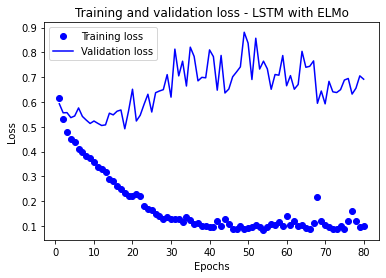

In [ ]:
# Training and validation loss
plt.plot(epochs, lstm_elmo_loss, 'bo', label='Training loss') # Training Loss
plt.plot(epochs, lstm_elmo_val_loss, 'b', label='Validation loss') # Validation Loss
# Set title and labels
plt.title('Training and validation loss - LSTM with ELMo')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

**Plot training and validation accuracy**

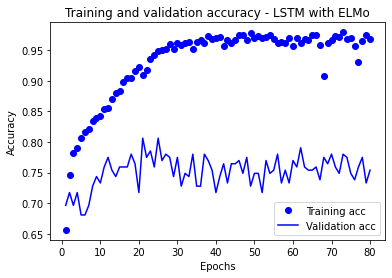

In [ ]:
# Clear current figure
plt.clf()
# Training and validation accuracy
plt.plot(epochs, lstm_elmo_acc, 'bo', label='Training acc') # Training Accuracy
plt.plot(epochs, lstm_elmo_val_acc, 'b', label='Validation acc') # Validation Accuracy
# Set title and labels
plt.title('Training and validation accuracy - LSTM with ELMo')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Enable the legend
plt.legend()
# Show the plot
plt.show()

**Test the LSTM model**

The trained model will be tested on the test subset, measuring its performance using the Confusion Matrix, Precision, Recall, Accuracy, and F1 Score.

Evaluate on test data


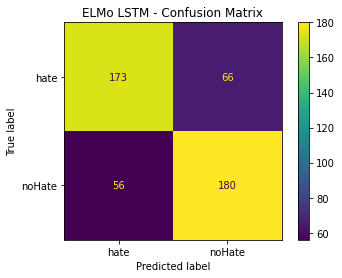

ELMo LSTM Hate Precision:0.76 ELMo LSTM No Hate Precision:0.73
ELMo LSTM Hate Recall:0.72 ELMo LSTM No Hate Recall:0.76
ELMo LSTM Hate F1 Score:0.74 ELMo LSTM No Hate F1 Score:0.75
ELMo LSTM Hate Accuracy:0.72 ELMo LSTM No Hate Accuracy:0.76
ELMo LSTM Overall Accuracy:0.74


In [ ]:
# Evaluate the model on the test subset
print("Evaluate on test data")
# Store the predictions 
lstm_elmo_pred = lstm_elmo_model.predict(X_test_elmo_keras)
# Convert pred to boolean
y_pred_bool_elmo = np.argmax(lstm_elmo_pred, axis=1)

# Print the Confusion Matrix
cm = confusion_matrix(y_test_elmo_num, y_pred_bool_elmo) # Calculate CM
# Generate CM Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['hate', 'noHate']) # Generate CM Display
disp.plot()
plt.title('ELMo LSTM - Confusion Matrix') # Set Title
# Show the plot
plt.show()

# Calculate Precision and Recall Scores
pc_scr = np.ndarray.round(precision_score(y_test_elmo_num, y_pred_bool_elmo, average=None),2)
rc_scr = np.ndarray.round(recall_score(y_test_elmo_num, y_pred_bool_elmo, average=None),2)
# Print Precision and Recall Scores
print("ELMo LSTM Hate Precision:"+str(pc_scr[0])+" ELMo LSTM No Hate Precision:"
+str(pc_scr[1])+"\nELMo LSTM Hate Recall:"+str(rc_scr[0])
+" ELMo LSTM No Hate Recall:"+str(rc_scr[1]))
# Calculate the F1 Scores
f1_scr = np.ndarray.round(f1_score(y_test_elmo_num, y_pred_bool_elmo, average=None),2)
# Print F1 Scores
print("ELMo LSTM Hate F1 Score:"+str(f1_scr[0])+" ELMo LSTM No Hate F1 Score:"+str(f1_scr[1]))
# Calculate Accuracy
class_acc = (cm.diagonal()/cm.sum(axis=1)).round(2) # Class Accuracy
all_acc = round(accuracy_score(y_test_elmo_num, y_pred_bool_elmo),2) # Overall Accuracy
# Print Accuracy
print("ELMo LSTM Hate Accuracy:"+str(class_acc[0])+" ELMo LSTM No Hate Accuracy:"
+str(class_acc[1])+"\nELMo LSTM Overall Accuracy:"+str(all_acc))

Using the output of ELMo with LSTM slightly improved its overall ability to correctly classify both Hate and No Hate sentences, compared to the LSTM model with randomly initialized word embeddings. The model returned an overall accuracy of 74%, a Hate accuracy of 72%, and a No Hate accuracy of 76%.

#### ELMo Embeddings Visualisation using t-SNE
The ELMo embeddings and the similarity between objects will be visualised using the t-SNE method. This method takes a group of high-dimensional word vectors and compresses them down to two-dimensional coordinate pairs. Ideally, similar words will be close together on the plane, while dissimilar words will have a longer distance between them.

The top fifty most common words found in hate and no Hate sentences will be visualised in a two-dimensional plane, using colour to distinguish them based on their label.

In [ ]:
# Get hate speech sentences
hate_sentences = train_df[train_df['label']=='hate'].clean_sentence.to_list()
# Get noHate speech sentences
nohate_sentences = train_df[train_df['label']=='noHate'].clean_sentence.to_list()

clean_hate_words = [] # List to store clean hate words
clean_nohate_words = [] # List to store clean no hate words

# Store the words in a list
for sent in hate_sentences: # Hate Speech words
# Go through every word found in hate speech sentences
  for word in word_tokenize(sent):
    if word.isalpha() and word not in stop_words:
      clean_hate_words.append(word)
for sent in nohate_sentences: # no Hate Speech words
# Go through every word found in nohate speech sentences
  for word in word_tokenize(sent):
    if word.isalpha() and word not in stop_words:
      clean_nohate_words.append(word)

# Instantiate Counter
h_counter = Counter(clean_hate_words) # Hate Speech
nh_counter = Counter(clean_nohate_words) # No Hate Speech

# Get the 50 most common words
# Hate Speech Words
mc_hate_words = h_counter.most_common(50)
clean_hate_words = [] # Reset list of hate words
for i in range(len(mc_hate_words)): # Go through the top 50 most common words
  clean_hate_words.append(mc_hate_words[i][0]) # Store the word
# No Hate Speech Words
mc_nohate_words = nh_counter.most_common(50)
clean_nohate_words = [] # Reset list of no hate words
for i in range(len(mc_nohate_words)): # Go through the top 50 most common words
  clean_nohate_words.append(mc_nohate_words[i][0]) # Store the word


# ELMO EMBEDDINGS PART
# Store hate vectors
hate_vectors = X_train_elmo_keras[train_df['label']=='hate']
# Store no hate vectors
nohate_vectors = X_train_elmo_keras[train_df['label']=='noHate']

# Hate word vectors
hate_wv = []
hate_words = []
for word in clean_hate_words: # For every top words
  for i in range(hate_vectors.shape[0]): # Start searching each sentence
    # Tokenize the ith sentence
    tok_sent = word_tokenize(train_df[train_df['label']=='hate'].clean_sentence.iloc[i])
    # If the word is found in the sentence
    if word in tok_sent:
      hate_words.append(word)
      # Get the index of the word in the sentence list
      idx = tok_sent.index(word)
      # Get the length of the sentence
      sent_len = len(tok_sent)
      # Get the ELMo vector
      # Because sentences are padded to 100, the actual words are located
      # in the end. Use slicing to find the word vector
      wv = hate_vectors[i][idx-sent_len]
      hate_wv.append(wv) # Append to the list
      break # Start looking for the next word
    else: # if the word is not found in the sentence
      continue # Move to the next sentence
hate_class = len(hate_words)*['hate'] # Create Class for Hate Vectors
hate_wv = np.asarray(hate_wv) # List to numpy

# no Hate word vectors
nohate_wv = []
nohate_words = []
for word in clean_nohate_words: # For every top words
  for i in range(nohate_vectors.shape[0]): # Start searching each sentence
    # Tokenize the ith sentence
    tok_sent = word_tokenize(train_df[train_df['label']=='noHate'].clean_sentence.iloc[i])
    # If the word is found in the sentence
    if word in tok_sent:
      nohate_words.append(word)
      # Get the index of the word in the sentence list
      idx = tok_sent.index(word)
      # Get the length of the sentence
      sent_len = len(tok_sent)
      # Get the ELMo vector
      # Because sentences are padded to 100, the actual words are located
      # in the end. Use slicing to find the word vector
      wv = nohate_vectors[i][idx-sent_len]
      nohate_wv.append(wv) # Append to the list
      break # Start looking for the next word
    else: # if the word is not found in the sentence
      continue # Move to the next sentence
nohate_class = len(nohate_words)*['noHate'] # Create Class for Hate Vectors
nohate_wv = np.asarray(nohate_wv) # List to numpy

# Instantiate TSNE
tsne_model = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=seed_value)
# Get new vectors
new_vectors = tsne_model.fit_transform(np.concatenate((hate_wv,nohate_wv), axis=0))

# Create a DataFrame containing each word and its coordinates and its class
wordvc_df = pd.concat([pd.DataFrame(new_vectors, columns=['X','Y']),pd.DataFrame(hate_words+nohate_words, columns=['Word']),
                       pd.DataFrame(hate_class+nohate_class, columns=['Class'])], axis=1)

# Change label of duplicates to Both to indicate that the word is found in both classes
idx = wordvc_df[wordvc_df.duplicated(subset=['Word'], keep=False)].index
wordvc_df.loc[idx,'Class'] = "both"
# Remove duplicate
wordvc_df = wordvc_df.drop_duplicates(subset=['Word'], keep='first')

# Create Scatter Plot
fig = px.scatter(wordvc_df, x='X', y='Y', color='Class', text='Word',
                 color_discrete_sequence=['green','red','blue'],
                 title='ELMo Word Embeddings')
fig.show() # Show Scatter

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



The scatterplot shows that the pre-trained ELMo word embeddings do a much better job at capturing the context of the words found in hate and no hate speech sentences, compared to the Word2Vec and GloVe word embeddings. While the majority of words were spread out in the Word2Vec and GloVe visualisations, here they are placed together in several mini-groups, based either on the meaning of the word or the type of the word.

Some of the groups that can be identified are:
- A group of words that come from hate speech sentences (e.g. negro, scum, jew, jews)
- A group containing the word country with africa and ireland
- A group of verbs (e.g. know, want, think, say)

This difference in the embeddings is also reflected in each of the models' accuracy since all three models that used ELMo word embeddings were able to outperform their Word2Vec and GloVe variations.

### Context Dependent Word Embeddings - BERT

Bidirectional Encoder Representations from Transformers, or BERT for short, is a pre-trained Transformer based deep learning model introduced in (Devlin et al., 2019), in which every output element is connected to every input element. The weights between the elements are dynamically calculated based on their connection. One of the main differences compared to the other methods is that the output of BERT also includes the model together with the vectors. As stated by Devlin et al. in their paper, “the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications”.


**The BERT model can be used in three different ways:**
1. It can be trained completely from scratch and used as a classifier itself
2. Its pre-trained word embeddings can be extracted and used in a Keras embedding layer, similar to the way GloVe and Word2Vec embeddings were used above
3. A pre-trained model can be fine-tuned using its output as input for a Deep Learning model

The purpose of this research is to determine whether the use of different input methods, like pre-trained contextualised word embeddings, improves or worsens a model's performance in text classification tasks. Therefore, a pre-trained BERT model will be fine-tuned and used as input for the above Deep Learning models. This is also known as Transfer Learning. The model that will be used is the BASE BERT model.

The code below was inspired by http://mccormickml.com/2019/07/22/BERT-fine-tuning/ and https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

#### Format the input and prepare the dataset
Because a pre-trained BERT model will be used, the data needs to be transformed in a format that BERT recognises and was trained on. More specifically, BERT requires:
- A special **separator [SEP]** token that marks the end of a sentence or the separation between two sentences
- A special **class [CLS]** token at the beginning of each text, used for classification tasks
- Tokens that comply with BERT's fixed vocabulary
- The **Token IDs** from BERT's tokenizer
- The **Mask IDs** to distinguish tokens from padding elements
- The **Segment IDs** to distinguish different sentences
- The **Positional Embeddings** that show each token's position within the sentence

All of the above requirements can be taken care of by using the tokenizer.encode_plus function from the transformers package.

**Tokenize Text according to BERT's requirements**

First, the Bert Tokenizer is loaded from the pre-trained BASE model.

In [ ]:
# Load the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, padding_side = 'left')

**Prepare the Train and Test subsets so that they can be fed to the BERT model**

The max sentence length is 323


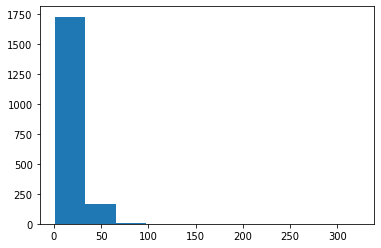

In [ ]:
# Get the length of all sentences
sent_len = [len(sent.split(" ")) for sent in train_df.clean_sentence.to_list()]
# Histogram on the sentences length
len_hist=plt.hist(sent_len)
# Print the max sentence length
print('The max sentence length is '+ str(max(sent_len)))

It is common practice to pad all sentences to the max sentence length. However, the above histogram shows that the majority of the sentences have a length between 0 and 50, with a few sentences going up to 100. Therefore, the max sentence length used for applying padding will change to 100.

In [ ]:
# Set max sentence length to 100 as before
max_sent_len = 100

# Prepare the Train subset
tr_input_ids = [] # encoded sentence list
tr_masks = [] # attention mask list
# For every sentence in the train dataframe
for sent in train_df.clean_sentence.to_list():
  tr_enc_dict = tokenizer.encode_plus(sent, # The sentence
                                   add_special_tokens = True, # [CLS] and [SEP]
                                   truncation = True, # Truncate sentences
                                   max_length = max_sent_len, # The max length
                                   padding='max_length', # Pad sentences
                                   return_attention_mask = True, # Attention Masks
                                   )
  # Add the encoded sentence to the list
  tr_input_ids.append(tr_enc_dict['input_ids'])
  # Add the attention mask
  tr_masks.append(tr_enc_dict['attention_mask'])

# Train feature matrix
tr_input_ids = np.array(tr_input_ids).astype('int32')
tr_masks = np.array(tr_masks).astype('int32')

# Prepare the Test subset
ts_input_ids = [] # encoded sentence list
ts_masks = [] # attention mask list
# For every sentence in the test dataframe
for sent in test_df.clean_sentence.to_list():
  ts_enc_dict = tokenizer.encode_plus(sent, # The sentence
                                   add_special_tokens = True, # [CLS] and [SEP]
                                   truncation = True, # Truncate sentences
                                   max_length = max_sent_len, # The max length
                                   padding='max_length', # Pad sentences
                                   return_attention_mask = True, # Attention Masks
                                   )
  # Add the encoded sentence to the list
  ts_input_ids.append(ts_enc_dict['input_ids'])
  # Add the attention mask
  ts_masks.append(ts_enc_dict['attention_mask'])

# Test feature matrix
ts_input_ids = np.array(ts_input_ids).astype('int32')
ts_masks = np.array(ts_masks).astype('int32')

# one hot encode train labels
y_train_bert = pd.get_dummies(train_df.label).values.astype('float32')
# Convert the categorical label to numeric
y_train_bert_num = train_df.label.replace(['hate','noHate'],[0,1]).astype('float32')

# one hot encode test labels
y_test_bert = pd.get_dummies(test_df.label).values.astype('float32')
# Convert the categorical label to numeric
y_test_bert_num = test_df.label.replace(['hate','noHate'],[0,1]).astype('float32')

#### Load the Pre-Trained BERT Model
The pre-trained BASE BERT model will be used, a smaller version which has 12 transformer blocks, a hidden layer size of 768, and 12 attention heads. Since BERT is used only for its "raw" output, it will not be fine-tuned. This can be achieved by freezing its weights and setting trainable equal to False.

In [ ]:
# Load the pre-trained model
bert_trained = TFBertModel.from_pretrained('bert-base-uncased')
# Freeze the weights
bert_trained.trainable = False

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


#### Test the Support Vector Machine Model with the BERT embeddings

**Pass the Train and Test data through BERT and get its embeddings to use as input for SVM**

In [ ]:
# Training Data
X_train_svm_bert = bert_trained.bert.embeddings(tr_input_ids,tr_masks).numpy()
# Reduce dimension
X_train_svm_bert = np.mean(X_train_svm_bert, axis=1)

# Test Data
X_test_svm_bert = bert_trained.bert.embeddings(ts_input_ids,ts_masks).numpy()
# Reduce dimension
X_test_svm_bert = np.mean(X_test_svm_bert, axis=1)

**Create and train the SVM model**

In [ ]:
# Instatiate SVC
svm_bert = LinearSVC(C=0.2)
# Fit training data
svm_bert.fit(X_train_svm_bert, y_train_bert_num)
# Get prediction on test data
svm_bert_pred = svm_bert.predict(X_test_svm_bert)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



**Test the SVM Model and get Performance Metrics**

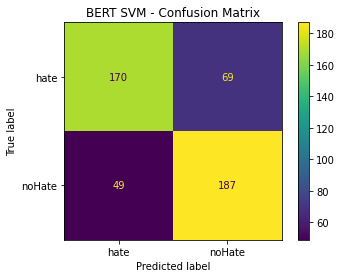

BERT SVM Hate Precision:0.78 BERT SVM No Hate Precision:0.73
BERT SVM Hate Recall:0.71 BERT SVM No Hate Recall:0.79
BERT SVM Hate F1 Score:0.74 BERT SVM No Hate F1 Score:0.76
BERT SVM Hate Accuracy:0.71 BERT SVM No Hate Accuracy:0.79
BERT SVM Overall Accuracy:0.75


In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_test_bert_num, svm_bert_pred, labels=svm_bert.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['hate','noHate'])
disp.plot()
plt.title('BERT SVM - Confusion Matrix') # Set Title
plt.show()

# Calculate Precision and Recall Scores
pc_scr = np.ndarray.round(precision_score(y_test_bert_num, svm_bert_pred, average=None),2)
rc_scr = np.ndarray.round(recall_score(y_test_bert_num, svm_bert_pred, average=None),2)
# Print Precision and Recall Scores
print("BERT SVM Hate Precision:"+str(pc_scr[0])+" BERT SVM No Hate Precision:"
+str(pc_scr[1])+"\nBERT SVM Hate Recall:"+str(rc_scr[0])
+" BERT SVM No Hate Recall:"+str(rc_scr[1]))
# Calculate the F1 Scores
f1_scr = np.ndarray.round(f1_score(y_test_bert_num, svm_bert_pred, average=None),2)
# Print F1 Scores
print("BERT SVM Hate F1 Score:"+str(f1_scr[0])+" BERT SVM No Hate F1 Score:"+str(f1_scr[1]))
# Calculate Accuracy
class_acc = (cm.diagonal()/cm.sum(axis=1)).round(2) # Class Accuracy
all_acc = round(accuracy_score(y_test_bert_num, svm_bert_pred),2) # Overall Accuracy
# Print Accuracy
print("BERT SVM Hate Accuracy:"+str(class_acc[0])+" BERT SVM No Hate Accuracy:"
+str(class_acc[1])+"\nBERT SVM Overall Accuracy:"+str(all_acc))

Using the output of BERT with SVM improved overall the model's accuracy, compared to the Bag-of-Words SVM model. Although its ability to classify Hate sentences was not affected, the model was able to correctly classify more No Hate sentences. The model returned an overall accuracy of 75%, a Hate accuracy of 71%, and a No Hate accuracy of 79%.

Unlike Deep Learning Neural Networks, traditional Machine Learning models like SVM, cannot handle three-dimensional data. The embedding vectors had to be averaged to maintain the dimensionality that works with SVM, losing the spatial features of the BERT vectors.

#### Test the Convolutional Neural Network Model with BERT

**Set up Hyperparameters**

In [ ]:
# Percentage of the training data to use for validation
val_pct = 0.1
# Number of filters per filter size
num_filters = 100
# Dropout keep probability
dropout_prob = 0.2
# Batch Size
batch_size = 32
# Number of training epochs
num_epochs = 4

**Build the Model**

In [ ]:
# Set up parameters for Keras layers
sequence_length = tr_input_ids.shape[1] # Length of input sequences
input_shape = (sequence_length,) # Shape of the Input layer
num_classes = y_train_bert.shape[1] # Number of classes for the output layer

# Print layer information
print("Sequence Length: {}".format(sequence_length))
print("Input Shape: {}".format(input_shape))
print("Number of Classes: {}".format(num_classes))

# Create Keras Model Layers with BERT 
# The Custom Input Layer
input_ids = Input(shape=input_shape, dtype='int32', name='InputIDs') # Layer for Input IDs
masks = Input(shape=input_shape, dtype='int32', name='MaskIDs') # Layer for Mask IDs
inputBert = [input_ids, masks] # Input for BERT Model
# The Bert Layer
bert_out = bert_trained(inputBert) # Pass data through Bert
bert_out = bert_out[0] # Get the last hidden layer
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer1')(bert_out)
# Three pairs of Convolution and Pool layers, each one flattened
# First Pair, with kernel size 3
pairOneLayer = Conv1D(num_filters, 3, activation='relu',
                      name='ConvLayer1')(dropLayer) # Convolution Layer
pairOneLayer = MaxPooling1D(name='PoolLayer1')(pairOneLayer) # Pooling Layer
pairOneLayer = Flatten(name='FlattenLayer1')(pairOneLayer) # Flatten Layer
# Second Pair, with kernel size 4
pairTwoLayer = Conv1D(num_filters, 4, activation='relu',
                      name='ConvLayer2')(dropLayer) # Convolution Layer
pairTwoLayer = MaxPooling1D(name='PoolLayer2')(pairTwoLayer) # Pooling Layer
pairTwoLayer = Flatten(name='FlattenLayer2')(pairTwoLayer) # Flatten Layer
# Third Pair, with kernel size 5
pairThreeLayer = Conv1D(num_filters, 5, activation='relu',
                      name='ConvLayer3')(dropLayer) # Convolution Layer
pairThreeLayer = MaxPooling1D(name='PoolLayer3')(pairThreeLayer) # Pooling Layer
pairThreeLayer = Flatten(name='FlattenLayer3')(pairThreeLayer) # Flatten Layer
# Concatenate the three pairs
concLayer = Concatenate(name='ConcatLayer')([pairOneLayer,pairTwoLayer,pairThreeLayer])
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer2')(concLayer)
# The Output layer
outputLayer = Dense(num_classes, activation='softmax', name='OutputLayer')(dropLayer)

# Group layers into the Model object
cnn_bert_model = Model(inputBert, outputLayer)
# Print model summary
cnn_bert_model.summary()

Sequence Length: 100
Input Shape: (100,)
Number of Classes: 2
Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputIDs (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 MaskIDs (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model_5 (TFBertModel)  TFBaseModelOutputWi  109482240   ['InputIDs[0][0]',               
                                thPoolingAndCrossAt               'MaskIDs[0][0]']                
                                tentions(last_hidde                                               
                             

**Visualise the CNN Model**

The Keras model can be visualised using the plot_model function from Keras Visualisation Utilities. Visualising the model is a good practice as it helps to confirm layers' order and shapes.

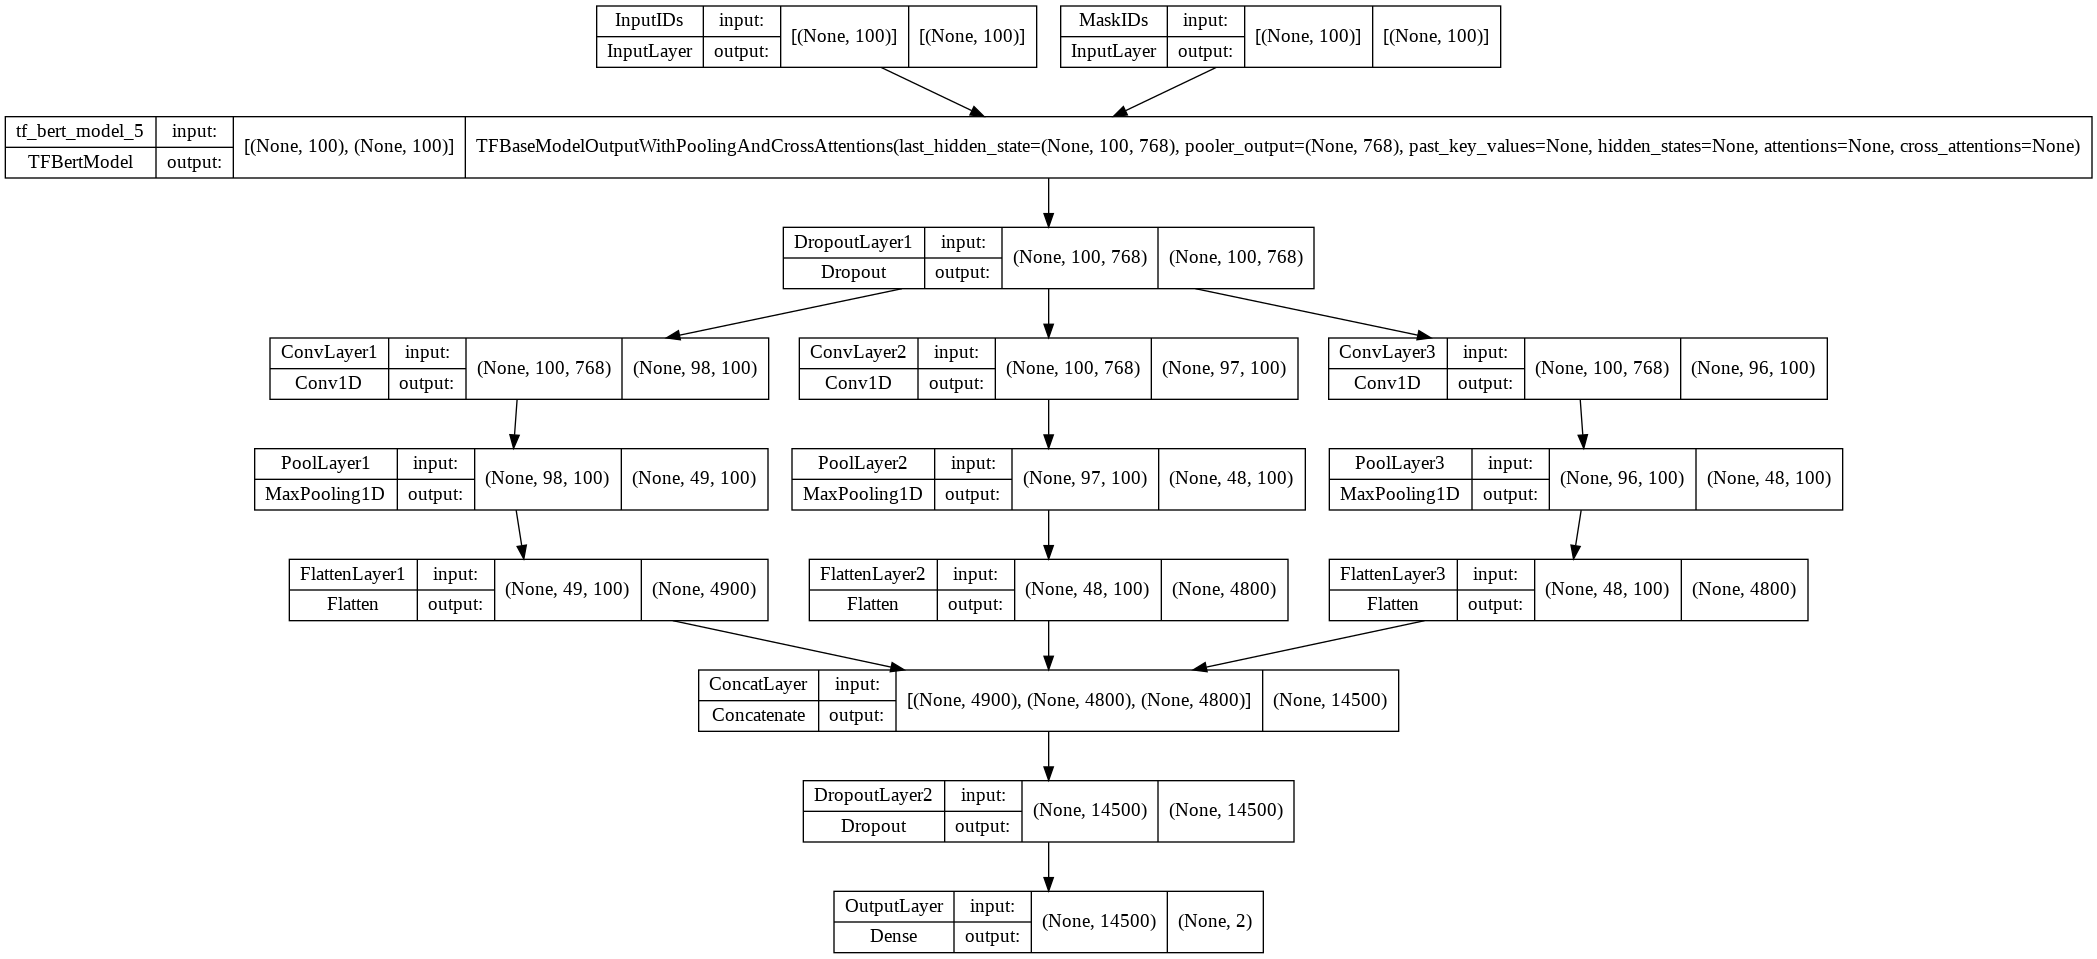

In [ ]:
# Plot the model
plot_model(cnn_bert_model, show_shapes=True, show_layer_names=True)

**Train the CNN Model**

The model will be compiled using Adam with weight decay (AdamW) as the preferred optimizer, Categorical Crossentropy as a loss function and Accuracy as a performance metric. The model is then trained on the training subset, saving the training history to be used for plotting performance metrics.


In [ ]:
# Train the Model
# Specify loss function, optimizer, and performance metrics
cnn_bert_model.compile(optimizer=AdamW(weight_decay=0.001, learning_rate=5e-5),
                  loss='categorical_crossentropy', metrics=['acc'])

# Train the model and store the history
cnn_bert_history = cnn_bert_model.fit([tr_input_ids,tr_masks], y_train_bert, batch_size=batch_size,
                            epochs=num_epochs, validation_split=val_pct)

Epoch 1/4
54/54 [==============================] - 25s 225ms/step - loss: 0.6089 - acc: 0.6772 - val_loss: 0.5266 - val_acc: 0.7225
Epoch 2/4
54/54 [==============================] - 9s 168ms/step - loss: 0.4945 - acc: 0.7636 - val_loss: 0.4956 - val_acc: 0.7592
Epoch 3/4
54/54 [==============================] - 9s 168ms/step - loss: 0.4478 - acc: 0.7928 - val_loss: 0.4868 - val_acc: 0.7696
Epoch 4/4
54/54 [==============================] - 9s 167ms/step - loss: 0.4181 - acc: 0.8062 - val_loss: 0.4796 - val_acc: 0.7592


**Test the CNN model**

The trained model will be tested on the test subset, measuring its performance using the Confusion Matrix, Precision, Recall, Accuracy, and F1 Score.

Evaluate on test data


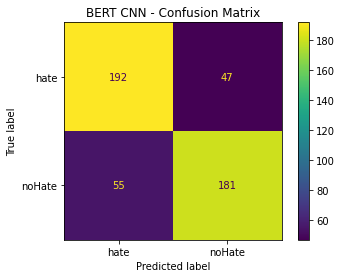

BERT CNN Hate Precision:0.78 BERT CNN No Hate Precision:0.79
BERT CNN Hate Recall:0.8 BERT CNN No Hate Recall:0.77
BERT CNN Hate F1 Score:0.79 BERT CNN No Hate F1 Score:0.78
BERT CNN Hate Accuracy:0.8 BERT CNN No Hate Accuracy:0.77
BERT CNN Overall Accuracy:0.79


In [ ]:
# Evaluate the model on the test subset
print("Evaluate on test data")
# Store the predictions
cnn_bert_pred = cnn_bert_model.predict([ts_input_ids,ts_masks])
# Convert pred to boolean
y_pred_bool_bert = np.argmax(cnn_bert_pred, axis=1)

# Print the Confusion Matrix
cm = confusion_matrix(y_test_bert_num, y_pred_bool_bert) # Calculate CM
# Generate CM Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['hate', 'noHate']) # Generate CM Display
disp.plot()
plt.title('BERT CNN - Confusion Matrix') # Set Title
# Show the plot
plt.show()

# Calculate Precision and Recall Scores
pc_scr = np.ndarray.round(precision_score(y_test_bert_num, y_pred_bool_bert, average=None),2)
rc_scr = np.ndarray.round(recall_score(y_test_bert_num, y_pred_bool_bert, average=None),2)
# Print Precision and Recall Scores
print("BERT CNN Hate Precision:"+str(pc_scr[0])+" BERT CNN No Hate Precision:"
+str(pc_scr[1])+"\nBERT CNN Hate Recall:"+str(rc_scr[0])
+" BERT CNN No Hate Recall:"+str(rc_scr[1]))
# Calculate the F1 Scores
f1_scr = np.ndarray.round(f1_score(y_test_bert_num, y_pred_bool_bert, average=None),2)
# Print F1 Scores
print("BERT CNN Hate F1 Score:"+str(f1_scr[0])+" BERT CNN No Hate F1 Score:"+str(f1_scr[1]))
# Calculate Accuracy
class_acc = (cm.diagonal()/cm.sum(axis=1)).round(2) # Class Accuracy
all_acc = round(accuracy_score(y_test_bert_num, y_pred_bool_bert),2) # Overall Accuracy
# Print Accuracy
print("BERT CNN Hate Accuracy:"+str(class_acc[0])+" BERT CNN No Hate Accuracy:"
+str(class_acc[1])+"\nBERT CNN Overall Accuracy:"+str(all_acc))

Using BERT's last hidden layer as input for the CNN model further improved the model's performance compared to the CNN model with randomly initialized word embeddings. The model returned an overall accuracy of 79%, a Hate accuracy of 80%, and a No Hate accuracy of 77%, outperforming all the other variations of the CNN model. The model also required much fewer epochs to train, which is one of the advantages of using BERT and Transfer Learning.

#### Test the Long Short-Term Memory Model with BERT

**Set up Hyperparameters**

In [ ]:
# Percentage of the training data to use for validation
val_pct = 0.1
# The units of the LSTM layer (dimension)
lstm_dim = 120
# Dropout keep probability
dropout_prob = 0.2
# Batch Size
batch_size = 32
# Number of training epochs
num_epochs = 2

**Build the Model**

In [ ]:
# Set up parameters for Keras layers
sequence_length = tr_input_ids.shape[1] # Length of input sequences
input_shape = (sequence_length,) # Shape of the Input layer
num_classes = y_train_bert.shape[1] # Number of classes for the output layer

# Print layer information
print("Sequence Length: {}".format(sequence_length))
print("Input Shape: {}".format(input_shape))
print("Number of Classes: {}".format(num_classes))

# Create Keras Model Layers with BERT 
# The Custom Input Layer
input_ids = Input(shape=input_shape, dtype='int32', name='InputIDs') # Layer for Input IDs
masks = Input(shape=input_shape, dtype='int32', name='MaskIDs') # Layer for Mask IDs
inputBert = [input_ids, masks] # Input for BERT Model
# The Bert Layer
bert_out = bert_trained(inputBert) # Pass data through Bert
bert_out = bert_out[0] # Get the last hidden layer
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer1')(bert_out)
# One LSTM Layer of size 128
lstmLayer = LSTM(lstm_dim,name='LSTMLayer')(dropLayer)
# One Dropout Layer
dropLayer = Dropout(dropout_prob, name='DropoutLayer2')(lstmLayer)
# The Output layer
outputLayer = Dense(num_classes, activation='softmax', name='OutputLayer')(dropLayer)

# Group layers into the Model object
lstm_bert_model = Model(inputBert, outputLayer)
# Print model summary
lstm_bert_model.summary()

Sequence Length: 100
Input Shape: (100,)
Number of Classes: 2
Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputIDs (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 MaskIDs (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model_5 (TFBertModel)  TFBaseModelOutputWi  109482240   ['InputIDs[0][0]',               
                                thPoolingAndCrossAt               'MaskIDs[0][0]']                
                                tentions(last_hidde                                               
                             

**Visualise the LSTM Model**

The Keras model can be visualised using the plot_model function from Keras Visualisation Utilities. Visualising the model is a good practice as it helps to confirm layers' order and shapes.

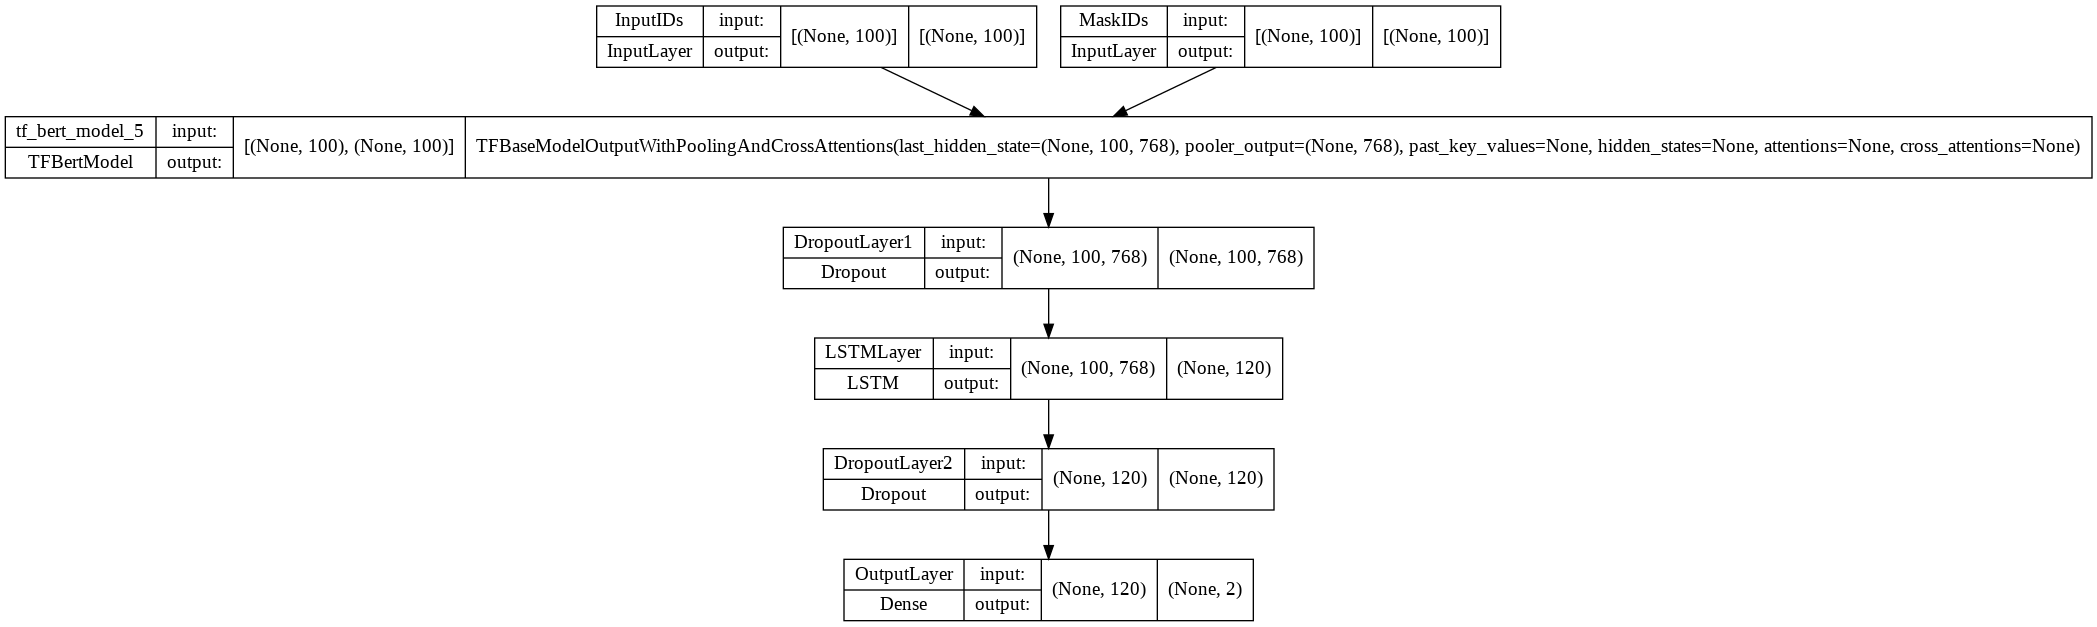

In [ ]:
# Plot the model
plot_model(lstm_bert_model, show_shapes=True, show_layer_names=True)

**Train the LSTM Model**

The model will be compiled using Adam with weight decay (AdamW) as the preferred optimizer, Categorical Crossentropy as a loss function and Accuracy as a performance metric. The model is then trained on the training subset, saving the training history to be used for plotting performance metrics.

In [ ]:
# Train the Model
# Specify loss function, optimizer, and performance metrics
lstm_bert_model.compile(optimizer=AdamW(weight_decay=0.001, learning_rate=3e-4),
                  loss='categorical_crossentropy', metrics=['acc'])

# Train the model and store the history
lstm_bert_history = lstm_bert_model.fit([tr_input_ids,tr_masks], y_train_bert, batch_size=batch_size,
                            epochs=num_epochs, validation_split=val_pct)

Epoch 1/2
54/54 [==============================] - 26s 234ms/step - loss: 0.5296 - acc: 0.7385 - val_loss: 0.4306 - val_acc: 0.8010
Epoch 2/2
54/54 [==============================] - 9s 170ms/step - loss: 0.4390 - acc: 0.7945 - val_loss: 0.4279 - val_acc: 0.7801


**Test the LSTM model**

The trained model will be tested on the test subset, measuring its performance using the Confusion Matrix, Precision, Recall, Accuracy, and F1 Score.

Evaluate on test data


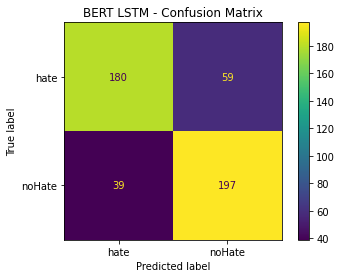

BERT LSTM Hate Precision:0.82 BERT LSTM No Hate Precision:0.77
BERT LSTM Hate Recall:0.75 BERT LSTM No Hate Recall:0.83
BERT LSTM Hate F1 Score:0.79 BERT LSTM No Hate F1 Score:0.8
BERT LSTM Hate Accuracy:0.75 BERT LSTM No Hate Accuracy:0.83
BERT LSTM Overall Accuracy:0.79


In [ ]:
# Evaluate the model on the test subset
print("Evaluate on test data")
# Store the predictions 
lstm_bert_pred = lstm_bert_model.predict([ts_input_ids,ts_masks])
# Convert pred to boolean
y_pred_bool_bert = np.argmax(lstm_bert_pred, axis=1)

# Print the Confusion Matrix
cm = confusion_matrix(y_test_bert_num, y_pred_bool_bert) # Calculate CM
# Generate CM Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['hate', 'noHate']) # Generate CM Display
disp.plot()
plt.title('BERT LSTM - Confusion Matrix') # Set Title
# Show the plot
plt.show()

# Calculate Precision and Recall Scores
pc_scr = np.ndarray.round(precision_score(y_test_bert_num, y_pred_bool_bert, average=None),2)
rc_scr = np.ndarray.round(recall_score(y_test_bert_num, y_pred_bool_bert, average=None),2)
# Print Precision and Recall Scores
print("BERT LSTM Hate Precision:"+str(pc_scr[0])+" BERT LSTM No Hate Precision:"
+str(pc_scr[1])+"\nBERT LSTM Hate Recall:"+str(rc_scr[0])
+" BERT LSTM No Hate Recall:"+str(rc_scr[1]))
# Calculate the F1 Scores
f1_scr = np.ndarray.round(f1_score(y_test_bert_num, y_pred_bool_bert, average=None),2)
# Print F1 Scores
print("BERT LSTM Hate F1 Score:"+str(f1_scr[0])+" BERT LSTM No Hate F1 Score:"+str(f1_scr[1]))
# Calculate Accuracy
class_acc = (cm.diagonal()/cm.sum(axis=1)).round(2) # Class Accuracy
all_acc = round(accuracy_score(y_test_bert_num, y_pred_bool_bert),2) # Overall Accuracy
# Print Accuracy
print("BERT LSTM Hate Accuracy:"+str(class_acc[0])+" BERT LSTM No Hate Accuracy:"
+str(class_acc[1])+"\nBERT LSTM Overall Accuracy:"+str(all_acc))

Using BERT's last hidden layer as input for the LSTM model significantly improved the model's performance compared to the LSTM model with randomly initialized word embeddings. The model returned an overall accuracy of 79%, a Hate accuracy of 75%, and a No Hate accuracy of 83%, outperforming all the other variations of the LSTM model. The model also required much fewer epochs to train, which is one of the advantages of using BERT and Transfer Learning.

#### BERT Embeddings Visualisation using t-SNE
The BERT embeddings and the similarity between objects will be visualised using the t-SNE method. This method takes a group of high-dimensional word vectors and compresses them down to two-dimensional coordinate pairs. Ideally, similar words will be close together on the plane, while dissimilar words will have a longer distance between them.

The top fifty most common words found in hate and no Hate sentences will be visualised in a two-dimensional plane, using colour to distinguish them based on their label.

In [ ]:
# Get hate speech sentences
hate_sentences = train_df[train_df['label']=='hate'].clean_sentence.to_list()
# Get noHate speech sentences
nohate_sentences = train_df[train_df['label']=='noHate'].clean_sentence.to_list()

clean_hate_words = [] # List to store clean hate words
clean_nohate_words = [] # List to store clean no hate words

# Store the words in a list
for sent in hate_sentences: # Hate Speech words
# Go through every word found in hate speech sentences
  for word in word_tokenize(sent):
    if word.isalpha() and word not in stop_words:
      clean_hate_words.append(word)
for sent in nohate_sentences: # no Hate Speech words
# Go through every word found in nohate speech sentences
  for word in word_tokenize(sent):
    if word.isalpha() and word not in stop_words:
      clean_nohate_words.append(word)

# Instantiate Counter
h_counter = Counter(clean_hate_words) # Hate Speech
nh_counter = Counter(clean_nohate_words) # No Hate Speech

# Get the 50 most common words
# Hate Speech Words
mc_hate_words = h_counter.most_common(50)
clean_hate_words = [] # Reset list of hate words
for i in range(len(mc_hate_words)): # Go through the top 50 most common words
  clean_hate_words.append(mc_hate_words[i][0]) # Store the word

# No Hate Speech Words
mc_nohate_words = nh_counter.most_common(50)
clean_nohate_words = [] # Reset list of no hate words
for i in range(len(mc_nohate_words)): # Go through the top 50 most common words
  clean_nohate_words.append(mc_nohate_words[i][0]) # Store the word

# BERT EMBEDDINGS PART
max_len = 100
# Prepare the Hate Speech Words
ht_input_ids = [] # encoded sentence list
ht_masks = [] # attention mask list
# For every sentence
for sent in train_df[train_df['label']=='hate'].clean_sentence.tolist():
  ht_enc_dict = tokenizer.encode_plus(sent, # The sentence
                                   add_special_tokens = True, # [CLS] and [SEP]
                                   truncation = True, # Truncate word
                                   max_length = max_len, # The max length
                                   padding='max_length', # Pad words
                                   return_attention_mask = True, # Attention Masks
                                   )
  # Add the encoded sentence to the list
  ht_input_ids.append(ht_enc_dict['input_ids'])
  # Add the attention mask
  ht_masks.append(ht_enc_dict['attention_mask'])

# Hate Speech feature matrix
ht_input_ids = np.array(ht_input_ids).astype('int32')
ht_masks = np.array(ht_masks).astype('int32')


# Prepare the no Hate Speech Words
noht_input_ids = [] # encoded sentence list
noht_masks = [] # attention mask list
# For every sentence
for sent in train_df[train_df['label']=='noHate'].clean_sentence.tolist():
  noht_enc_dict = tokenizer.encode_plus(sent, # The sentence
                                   add_special_tokens = True, # [CLS] and [SEP]
                                   truncation = True, # Truncate word
                                   max_length = max_len, # The max length
                                   padding='max_length', # Pad words
                                   return_attention_mask = True, # Attention Masks
                                   )
  # Add the encoded sentence to the list
  noht_input_ids.append(noht_enc_dict['input_ids'])
  # Add the attention mask
  noht_masks.append(noht_enc_dict['attention_mask'])

# No Hate Speech feature matrix
noht_input_ids = np.array(noht_input_ids).astype('int32')
noht_masks = np.array(noht_masks).astype('int32')

# Get Hate Vectors
hate_vectors = bert_trained(ht_input_ids,ht_masks)[0].numpy()
# Get no Hate Vectors
nohate_vectors = bert_trained(noht_input_ids,noht_masks)[0].numpy()

# Get vectors for most common hate words
hate_wv = []
hate_words = []
for word in clean_hate_words: # For every top word
  for i in range(hate_vectors.shape[0]): # Start searching each sentence
    # Tokenize the ith sentence
    tok_sent = tokenizer.tokenize(train_df[train_df['label']=='hate'].clean_sentence.iloc[i])
    # If the word is found in the sentence
    if word in tok_sent:
      hate_words.append(word)
      # Get the index of the word in the sentence list
      idx = tok_sent.index(word)
      # Get the words BERT vector
      # Locate where the words begin using the masks
      # Because the first vector is the CLS token, use idx + 1
      wv = hate_vectors[i][np.where(ht_masks[i]==1)][idx+1]
      hate_wv.append(wv) # Append to the list
      break # Start looking for the next word
    else: # If the word is not found in the sentence
      continue # Move to the next sentence
hate_class = len(hate_words)*['hate'] # Create Class for Hate Vectors
hate_wv = np.asarray(hate_wv) # List to numpy

# Get vectors for most common no hate words
nohate_wv = []
nohate_words = []
for word in clean_nohate_words: # For every top word
  for i in range(nohate_vectors.shape[0]): # Start searching each sentence
    # Tokenize the ith sentence
    tok_sent = tokenizer.tokenize(train_df[train_df['label']=='noHate'].clean_sentence.iloc[i])
    # If the word is found in the sentence
    if word in tok_sent:
      nohate_words.append(word)
      # Get the index of the word in the sentence list
      idx = tok_sent.index(word)
      # Get the words BERT vector
      # Locate where the words begin using the masks
      # Because the first vector is the CLS token, use idx + 1
      wv = nohate_vectors[i][np.where(noht_masks[i]==1)][idx+1]
      nohate_wv.append(wv) # Append to the list
      break # Start looking for the next word
    else: # If the word is not found in the sentence
      continue # Move to the next sentence
nohate_class = len(nohate_words)*['noHate'] # Create Class for noHate Vectors
nohate_wv = np.asarray(nohate_wv) # List to numpy

# Instantiate TSNE
tsne_model = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=seed_value)
# Get new vectors
new_vectors = tsne_model.fit_transform(np.concatenate((hate_wv,nohate_wv), axis=0))

# Create a DataFrame containing each word and its coordinates and its class
wordvc_df = pd.concat([pd.DataFrame(new_vectors, columns=['X','Y']),pd.DataFrame(hate_words+nohate_words, columns=['Word']),
                       pd.DataFrame(hate_class+nohate_class, columns=['Class'])], axis=1)

# Change label of duplicates to Both to indicate that the word is found in both classes
idx = wordvc_df[wordvc_df.duplicated(subset=['Word'], keep=False)].index
wordvc_df.loc[idx,'Class'] = "both"
# Remove duplicate
wordvc_df = wordvc_df.drop_duplicates(subset=['Word'], keep='first')

# Create Scatter Plot
fig = px.scatter(wordvc_df, x='X', y='Y', color='Class', text='Word',
                 color_discrete_sequence=['green','red','blue'],
                 title='BERT Word Embeddings')
fig.show() # Show Scatter

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Similar to the ELMo word embeddings, the pre-trained BERT word embeddings did a much better job at capturing the context of the words found in hate and no hate speech sentences, compared to the Word2Vec and GloVe word embeddings.

Like in the ELMo visualisation, words were also placed in several mini-groups based on the meaning or the type of the word, instead of being spread out. The difference with ELMo word embeddings is that BERT was able to group together all of the words that are found in hate speech sentences and can be used to offend a group of people (i.e. jew, jews, black, blacks, white, whites, race, negro).

This difference in the embeddings is also reflected in each of the models' accuracy, since all three models that used BERT word embeddings were able to outperform their Word2Vec, GloVe, and ELMo variations.

##Fine-Tune the BERT Models using Hyperband Tuner

Out of all fifteen models, the BERT variations of the CNN and LSTM models were the best performers, having similar results, with BERT CNN performing better in classifying Hate Sentences and BERT LSTM performing better in classifying No Hate Sentences. A third Hybrid BERT CNN-LSTM model will be created, combining the two architectures and their advantage in each of the two classes.

The purpose of this section is to fine-tune the three models using Keras Hyperband Tuner to find which of them performs best in the Hate Speech Classification Problem.

Hyperband Tuning is a tuning method introduced by Li, Lisha, and Kevin Jamieson in "Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization." Journal of Machine Learning Research 18 (2018): 1-52. Instead of using Bayesian Optimization to identify a good set of hyperparameters, Hyperband Tuning focuses on speeding up random search through adaptive resource allocation and early stopping. According to their paper, in Hyperband Tuning, "the hyperparameter optimization is formulated as a pure-exploration non-stochastic infinite-armed bandit problem where a predefined resource like iterations, data samples, or features is allocated to randomly sampled configurations".

The below implementation was inspired by Tensorflow's Keras Tuner tutorial: https://www.tensorflow.org/tutorials/keras/keras_tuner

###Prepare the dataset

**Tokenize sentences and prepare BERT input**

In [ ]:
# Load the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, padding_side = 'left')

# Load the pre-trained model
bert_trained = TFBertModel.from_pretrained('bert-base-uncased')
# Freeze the weights
bert_trained.trainable = False

# Set max sentence length to 100
max_sent_len = 100

# Prepare the Train subset
tr_input_ids = [] # encoded sentence list
tr_masks = [] # attention mask list
# For every sentence in the train dataframe
for sent in train_df.clean_sentence.to_list():
  tr_enc_dict = tokenizer.encode_plus(sent, # The sentence
                                   add_special_tokens = True, # [CLS] and [SEP]
                                   truncation = True, # Truncate sentences
                                   max_length = max_sent_len, # The max length
                                   padding='max_length', # Pad sentences
                                   return_attention_mask = True, # Attention Masks
                                   )
  # Add the encoded sentence to the list
  tr_input_ids.append(tr_enc_dict['input_ids'])
  # Add the attention mask
  tr_masks.append(tr_enc_dict['attention_mask'])

# Train feature matrix
tr_input_ids = np.array(tr_input_ids).astype('int32')
tr_masks = np.array(tr_masks).astype('int32')

# Prepare the Test subset
ts_input_ids = [] # encoded sentence list
ts_masks = [] # attention mask list
# For every sentence in the test dataframe
for sent in test_df.clean_sentence.to_list():
  ts_enc_dict = tokenizer.encode_plus(sent, # The sentence
                                   add_special_tokens = True, # [CLS] and [SEP]
                                   truncation = True, # Truncate sentences
                                   max_length = max_sent_len, # The max length
                                   padding='max_length', # Pad sentences
                                   return_attention_mask = True, # Attention Masks
                                   )
  # Add the encoded sentence to the list
  ts_input_ids.append(ts_enc_dict['input_ids'])
  # Add the attention mask
  ts_masks.append(ts_enc_dict['attention_mask'])

# Test feature matrix
ts_input_ids = np.array(ts_input_ids).astype('int32')
ts_masks = np.array(ts_masks).astype('int32')

# one hot encode train labels
y_train_bert = pd.get_dummies(train_df.label).values.astype('float32')
# Convert the categorical label to numeric
y_train_bert_num = train_df.label.replace(['hate','noHate'],[0,1]).astype('float32')

# one hot encode test labels
y_test_bert = pd.get_dummies(test_df.label).values.astype('float32')
# Convert the categorical label to numeric
y_test_bert_num = test_df.label.replace(['hate','noHate'],[0,1]).astype('float32')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### Fine-Tune the BERT Convolutional Neural Network

The CNN hyperparameters that the Tuner will focus on optimising are:
- The dropout keep probability of the Dropout Layer
- The number of filters in the three Convolution Layers
- The kernel sizes of the three Convolution Layers
- The decay rate of the AdamW Optimiser
- The learning rate of the AdamW Optimiser

#### Set up Hyperparameters

In [ ]:
# Percentage of the training data to use for validation
val_pct = 0.1
# Batch Size
batch_size = 64
# Number of training epochs
num_epochs = 4
# Set up parameters for Keras layers
sequence_length = tr_input_ids.shape[1] # Length of input sequences
input_shape = (sequence_length,) # Shape of the Input layer
num_classes = y_train_bert.shape[1] # Number of classes for the output layer

#### Define CNN Model Function

Keras Tuner requires a model-building function to be passed which specifies the hyperparameters which Keras Tuner has to tune and also builds the model.

In [ ]:
# Define the Model function for Hyperband Tuner
def build_bertCNN(hp):
  
  # Hyperband Tuning parameters
  # Dropout keep probability
  hp_cnn_dropout = hp.Float('dropout', min_value=0, max_value=0.5, step=0.1)
  # Number of filters in the Convolution Layers
  hp_cnn_filters = hp.Int('filters', min_value=32, max_value=128, step=32)
  # Kernel sizes
  hp_cnn_kernels = hp.Choice('kernel', values=[2,3])
  # Decay Rate for AdamW
  hp_cnn_decay = hp.Choice('decay', values=[0.001,0.25,0.5])
  # Learning Rate for AdamW
  hp_cnn_lr = hp.Choice('learning_rate', values=[6e-5,5e-4,1e-4,1e-3])

  # Create Keras Model Layers with BERT 
  # The Custom Input Layer
  input_ids = Input(shape=input_shape, dtype='int32', name='InputIDs') # Layer for Input IDs
  masks = Input(shape=input_shape, dtype='int32', name='MaskIDs') # Layer for Mask IDs
  inputBert = [input_ids, masks] # Input for BERT Model
  # The Bert Layer
  bert_out = bert_trained(inputBert) # Pass data through Bert
  bert_out = bert_out[0] # Get the last hidden layer
  # One Dropout Layer
  dropLayer = Dropout(hp_cnn_dropout, name='DropoutLayer1')(bert_out)
  # Three pairs of Convolution and Pool layers, each one flattened
  # First Pair
  pairOneLayer = Conv1D(hp_cnn_filters, hp_cnn_kernels, activation='relu',
                        name='ConvLayer1')(dropLayer) # Convolution Layer
  pairOneLayer = MaxPooling1D(name='PoolLayer1')(pairOneLayer) # Pooling Layer
  pairOneLayer = Flatten(name='FlattenLayer1')(pairOneLayer) # Flatten Layer
  # Second Pair
  pairTwoLayer = Conv1D(hp_cnn_filters, hp_cnn_kernels+1, activation='relu',
                        name='ConvLayer2')(dropLayer) # Convolution Layer
  pairTwoLayer = MaxPooling1D(name='PoolLayer2')(pairTwoLayer) # Pooling Layer
  pairTwoLayer = Flatten(name='FlattenLayer2')(pairTwoLayer) # Flatten Layer
  # Third Pair
  pairThreeLayer = Conv1D(hp_cnn_filters, hp_cnn_kernels+2, activation='relu',
                        name='ConvLayer3')(dropLayer) # Convolution Layer
  pairThreeLayer = MaxPooling1D(name='PoolLayer3')(pairThreeLayer) # Pooling Layer
  pairThreeLayer = Flatten(name='FlattenLayer3')(pairThreeLayer) # Flatten Layer
  # Concatenate the three pairs
  concLayer = Concatenate(name='ConcatLayer')([pairOneLayer,pairTwoLayer,pairThreeLayer])
  # One Dropout Layer
  dropLayer = Dropout(hp_cnn_dropout, name='DropoutLayer2')(concLayer)
  # The Output layer
  outputLayer = Dense(num_classes, activation='softmax', name='OutputLayer')(dropLayer)
  # Group layers into the Model object
  cnn_bert_model = Model(inputBert, outputLayer)
  # Specify loss function, optimizer, and performance metrics
  cnn_bert_model.compile(optimizer=AdamW(weight_decay=hp_cnn_decay, learning_rate=hp_cnn_lr),
                         loss='categorical_crossentropy', metrics=['acc'])
  return cnn_bert_model

#### Instantiate the Hyperband

In [ ]:
# Instantiate the Hyperband tune
cnn_tuner = kt.Hyperband(build_bertCNN, objective='val_loss',
                         max_epochs=num_epochs+2, directory='bert_cnn_dir', seed=seed_value)

#### Hyperband Tuner Search

In [ ]:
# Set early stopping criteria
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", patience=5, restore_best_weights=True)
# Begin the search
cnn_tuner.search([tr_input_ids,tr_masks], y_train_bert, batch_size=batch_size,
                 epochs=num_epochs, validation_split=val_pct, callbacks=[stop_early])

Trial 10 Complete [00h 00m 52s]
val_loss: 0.4515511989593506

Best val_loss So Far: 0.4515511989593506
Total elapsed time: 00h 06m 42s


In [ ]:
# Get the optimal hyperparameters
cnn_best_hps=cnn_tuner.get_best_hyperparameters(num_trials=1)[0]
# Build the model using the best hyperparameters
cnn_bert_tuned = cnn_tuner.hypermodel.build(cnn_best_hps)
# Show optimal hyperparameters
cnn_best_hps.values

{'dropout': 0.2,
 'filters': 64,
 'kernel': 2,
 'decay': 0.001,
 'learning_rate': 0.001,
 'tuner/epochs': 6,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

**Visualise the CNN Model**

The Keras model can be visualised using the plot_model function from Keras Visualisation Utilities. Visualising the model is a good practice as it helps to confirm layers' order and shapes.

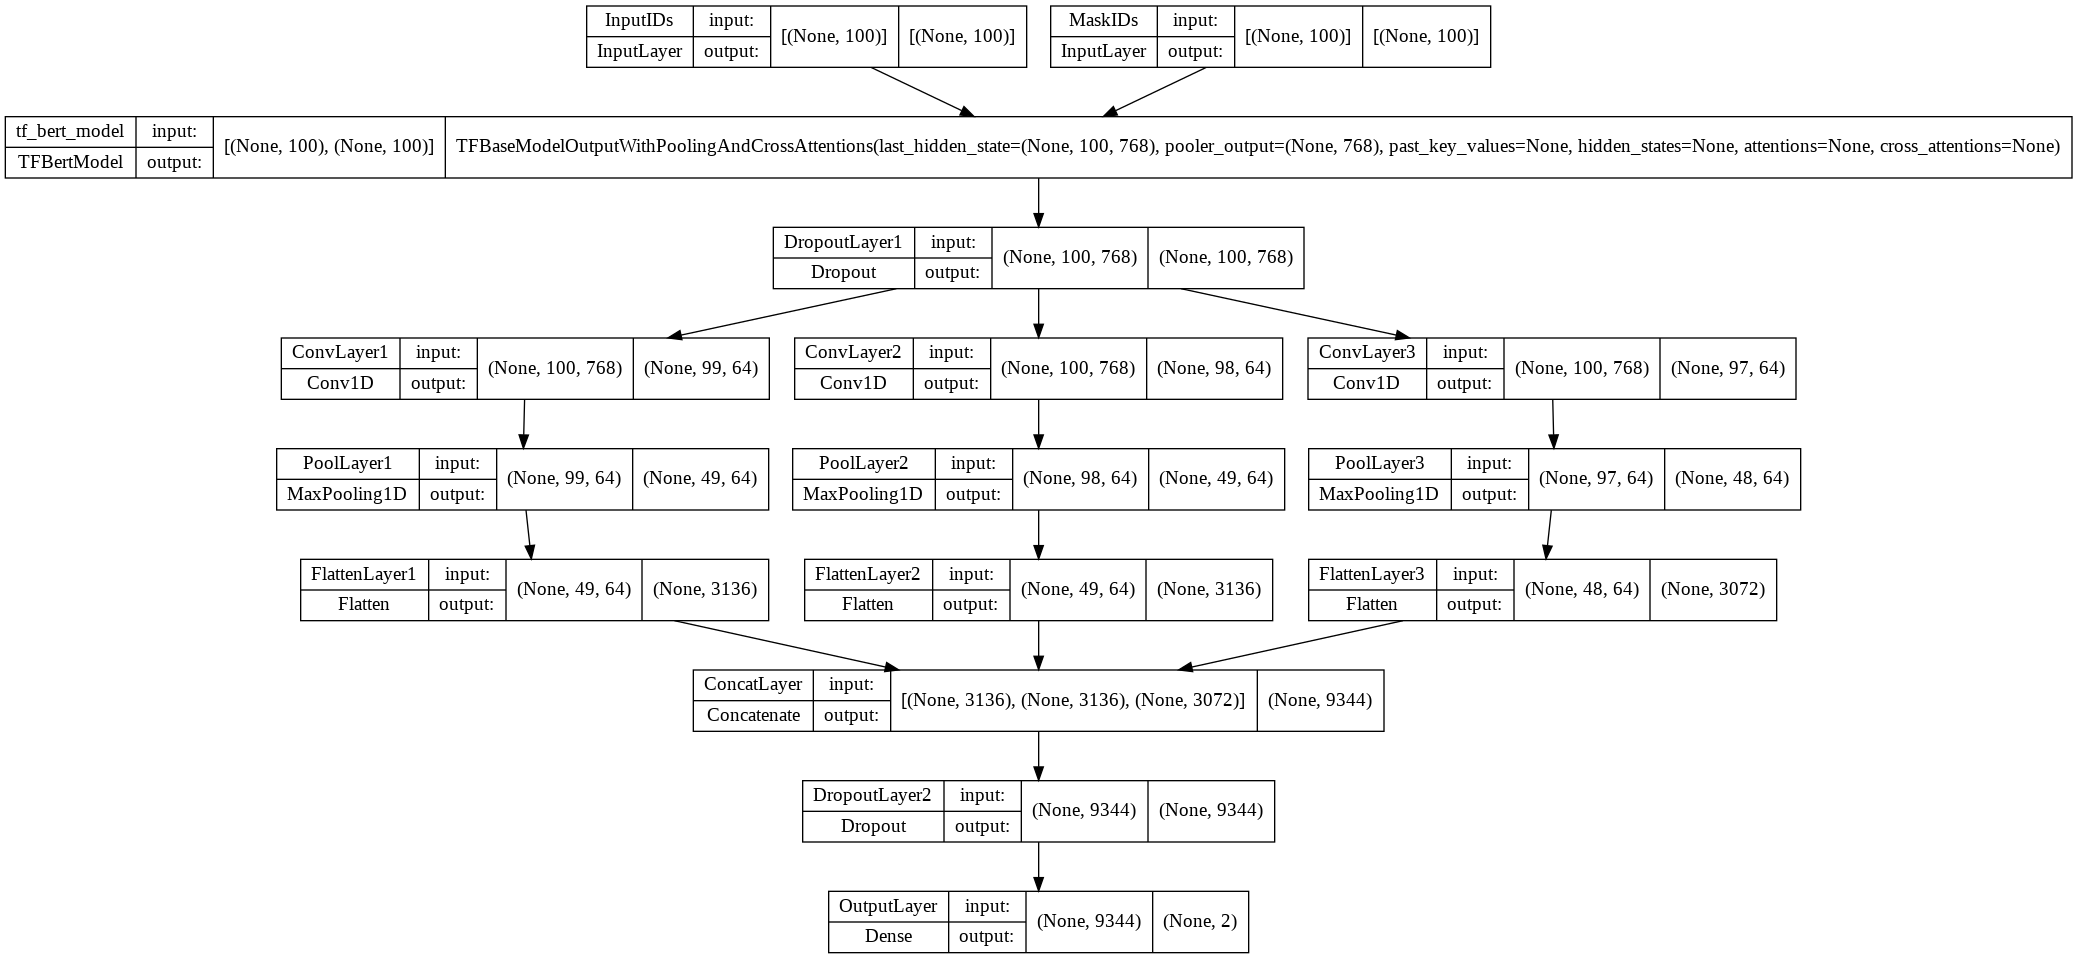

In [ ]:
# Plot the model
plot_model(cnn_bert_tuned, show_shapes=True, show_layer_names=True)

#### Train the BERT CNN model using the best Hyperparameters

In [ ]:
# Train the model and store the history
cnn_bert_tuned_history = cnn_bert_tuned.fit([tr_input_ids,tr_masks], y_train_bert, batch_size=batch_size,
                            epochs=num_epochs-2, validation_split=val_pct)

Epoch 1/2
27/27 [==============================] - 22s 300ms/step - loss: 0.7688 - acc: 0.6602 - val_loss: 0.4905 - val_acc: 0.7801
Epoch 2/2
27/27 [==============================] - 5s 173ms/step - loss: 0.4324 - acc: 0.8021 - val_loss: 0.4587 - val_acc: 0.7801


#### Test the Tuned BERT CNN Model get Performance Metrics

The trained model will be tested on the test subset, measuring its performance using the Confusion Matrix, Precision, Recall, Accuracy, and F1 Score.

Evaluate on test data


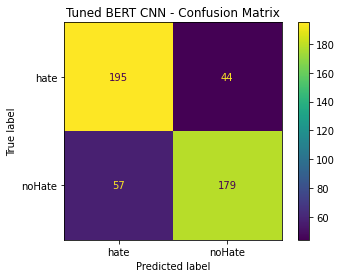

Tuned BERT CNN Hate Precision:0.77 Tuned BERT CNN No Hate Precision:0.8
Tuned BERT CNN Hate Recall:0.82 Tuned BERT CNN No Hate Recall:0.76
Tuned BERT CNN Hate F1 Score:0.79 Tuned BERT CNN No Hate F1 Score:0.78
Tuned BERT CNN Hate Accuracy:0.82 Tuned BERT CNN No Hate Accuracy:0.76
Tuned BERT CNN Overall Accuracy:0.79


In [ ]:
# Evaluate the model on the test subset
print("Evaluate on test data")
# Store the predictions
cnn_bert_tuned_pred = cnn_bert_tuned.predict([ts_input_ids,ts_masks])
# Convert pred to boolean
y_pred_bool_bert_tuned = np.argmax(cnn_bert_tuned_pred, axis=1)

# Print the Confusion Matrix
cm = confusion_matrix(y_test_bert_num, y_pred_bool_bert_tuned) # Calculate CM
# Generate CM Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['hate', 'noHate']) # Generate CM Display
disp.plot()
plt.title('Tuned BERT CNN - Confusion Matrix') # Set Title
# Show the plot
plt.show()

# Calculate Precision and Recall Scores
pc_scr = np.ndarray.round(precision_score(y_test_bert_num, y_pred_bool_bert_tuned, average=None),2)
rc_scr = np.ndarray.round(recall_score(y_test_bert_num, y_pred_bool_bert_tuned, average=None),2)
# Print Precision and Recall Scores
print("Tuned BERT CNN Hate Precision:"+str(pc_scr[0])+" Tuned BERT CNN No Hate Precision:"
+str(pc_scr[1])+"\nTuned BERT CNN Hate Recall:"+str(rc_scr[0])
+" Tuned BERT CNN No Hate Recall:"+str(rc_scr[1]))
# Calculate the F1 Scores
f1_scr = np.ndarray.round(f1_score(y_test_bert_num, y_pred_bool_bert_tuned, average=None),2)
# Print F1 Scores
print("Tuned BERT CNN Hate F1 Score:"+str(f1_scr[0])+" Tuned BERT CNN No Hate F1 Score:"+str(f1_scr[1]))
# Calculate Accuracy
class_acc = (cm.diagonal()/cm.sum(axis=1)).round(2) # Class Accuracy
all_acc = round(accuracy_score(y_test_bert_num, y_pred_bool_bert_tuned),2) # Overall Accuracy
# Print Accuracy
print("Tuned BERT CNN Hate Accuracy:"+str(class_acc[0])+" Tuned BERT CNN No Hate Accuracy:"
+str(class_acc[1])+"\nTuned BERT CNN Overall Accuracy:"+str(all_acc))

The Hyperband Tuner was able to increase the model's Hate Accuracy by 2%, achieving a Hate Accuracy of 82%. However, it also decreased the No Hate accuracy by 1%, dropping it down to 76%. The overall accuracy remained unchanged, sitting at 79%.

The hyperparameters that were used to achieve these results are:

- Dropout keep probability of the Dropout Layer: 0.2
- Number of filters in the three Convolution Layers: 64
- Kernel sizes of the three Convolution Layers: 2, 3, and 4
- Decay rate of the AdamW Optimiser: 0.001
- Learning rate of the AdamW Optimiser: 0.001

### Fine-Tune the BERT Long Short-Term Memory Model
The LSTM hyperparameters that the Tuner will focus on optimising are:

- The dropout keep probability of the Dropout Layer
- The number of the LSTM Layers
- The type of the LSTM Layers (Unidirectional/Bidirectional)
- The number of units in the LSTM Layers
- The decay rate of the AdamW Optimiser
- The learning rate of the AdamW Optimiser

#### Set up Hyperparameters

In [ ]:
# Percentage of the training data to use for validation
val_pct = 0.1
# Batch Size
batch_size = 64
# Number of training epochs
num_epochs = 4
# Set up parameters for Keras layers
sequence_length = tr_input_ids.shape[1] # Length of input sequences
input_shape = (sequence_length,) # Shape of the Input layer
num_classes = y_train_bert.shape[1] # Number of classes for the output layer

#### Define LSTM Model Function

Keras Tuner requires a model-building function to be passed which specifies the hyperparameters which Keras Tuner has to tune and also builds the model.

In [ ]:
def build_bertLSTM(hp):
  
  # Hyperband Tuning parameters
  # Dropout keep probability
  hp_lstm_dropout = hp.Float('dropout', min_value=0, max_value=0.5, step=0.1)
  # Bidirectional LSTM Flag
  hp_lstm_bidirectional = hp.Choice('bidirectional', values=[0,1])
  # Number of units in the LSTM Layer
  hp_lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
  # Number of LSTM Layers
  hp_lstm_layers = hp.Choice('lstm_layers', values=[1,2])
  # Decay Rate for AdamW
  hp_lstm_decay = hp.Choice('decay', values=[0.001,0.25,0.5])
  # Learning Rate for AdamW
  hp_lstm_lr = hp.Choice('learning_rate', values=[1e-4,6e-5,5e-4,1e-3])

  # Create Keras Model Layers with BERT 
  # The Custom Input Layer
  input_ids = Input(shape=input_shape, dtype='int32', name='InputIDs') # Layer for Input IDs
  masks = Input(shape=input_shape, dtype='int32', name='MaskIDs') # Layer for Mask IDs
  inputBert = [input_ids, masks] # Input for BERT Model
  # The Bert Layer
  bert_out = bert_trained(inputBert) # Pass data through Bert
  bert_out = bert_out[0] # Get the last hidden layer
  # One Dropout Layer
  dropLayer = Dropout(hp_lstm_dropout, name='DropoutLayer1')(bert_out)
  
  # The LSTM Layers
  if hp_lstm_bidirectional==0: # Unidirectional LSTM
    if hp_lstm_layers==1: # For one LSTM Layer
      # One LSTM Layer
      lstmLayer = LSTM(hp_lstm_units,name='LSTMLayer')(dropLayer)
    else: # Two LSTM Layers
      # First LSTM Layer
      lstmLayer0 = LSTM(hp_lstm_units, name='LSTMLayer0',
                        return_sequences=True)(dropLayer)
      # Second LSTM Layer
      lstmLayer = LSTM(hp_lstm_units,name='LSTMLayer')(lstmLayer0)
  else: # Bidirectional LSTM
    if hp_lstm_layers==1: # For one LSTM Layer
      # One BiLSTM Layer
      lstmLayer = Bidirectional(LSTM(hp_lstm_units,name='LSTMLayer'))(dropLayer)
    else: # Two BiLSTM Layers
      # First LSTM Layer
      lstmLayer0 = Bidirectional(LSTM(hp_lstm_units, name='LSTMLayer0',
                        return_sequences=True))(dropLayer)
      # Second LSTM Layer
      lstmLayer = Bidirectional(LSTM(hp_lstm_units,name='LSTMLayer'))(lstmLayer0)

  # One Dropout Layer
  dropLayer = Dropout(hp_lstm_dropout, name='DropoutLayer2')(lstmLayer)
  # The Output layer
  outputLayer = Dense(num_classes, activation='softmax', name='OutputLayer')(dropLayer)
  # Group layers into the Model object
  lstm_bert_model = Model(inputBert, outputLayer)
  # Specify loss function, optimizer, and performance metrics
  lstm_bert_model.compile(optimizer=AdamW(weight_decay=hp_lstm_decay, learning_rate=hp_lstm_lr),
                          loss='categorical_crossentropy', metrics=['acc'])
  return lstm_bert_model

#### Instantiate the Hyperband

In [ ]:
# Instantiate the Hyperband tune
lstm_tuner = kt.Hyperband(build_bertLSTM, objective='val_loss',
                         max_epochs=num_epochs+2, directory='bert_lstm_dir', seed=seed_value)

#### Hyperband Tuner Search

In [ ]:
# Set early stopping criteria
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", patience=5, restore_best_weights=True)
# Begin the search
lstm_tuner.search([tr_input_ids,tr_masks], y_train_bert, batch_size=batch_size,
                 epochs=num_epochs, validation_split=val_pct, callbacks=[stop_early])

Trial 10 Complete [00h 01m 13s]
val_loss: 0.43275123834609985

Best val_loss So Far: 0.43275123834609985
Total elapsed time: 00h 08m 29s


In [ ]:
# Get the optimal hyperparameters
lstm_best_hps=lstm_tuner.get_best_hyperparameters(num_trials=1)[0]
# Build the model using the best hyperparameters
lstm_bert_tuned = lstm_tuner.hypermodel.build(lstm_best_hps)
# Show optimal hyperparameters
lstm_best_hps.values

{'dropout': 0.2,
 'bidirectional': 1,
 'lstm_units': 32,
 'lstm_layers': 2,
 'decay': 0.001,
 'learning_rate': 0.0005,
 'tuner/epochs': 8,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

**Visualise the LSTM Model**

The Keras model can be visualised using the plot_model function from Keras Visualisation Utilities. Visualising the model is a good practice as it helps to confirm layers' order and shapes.

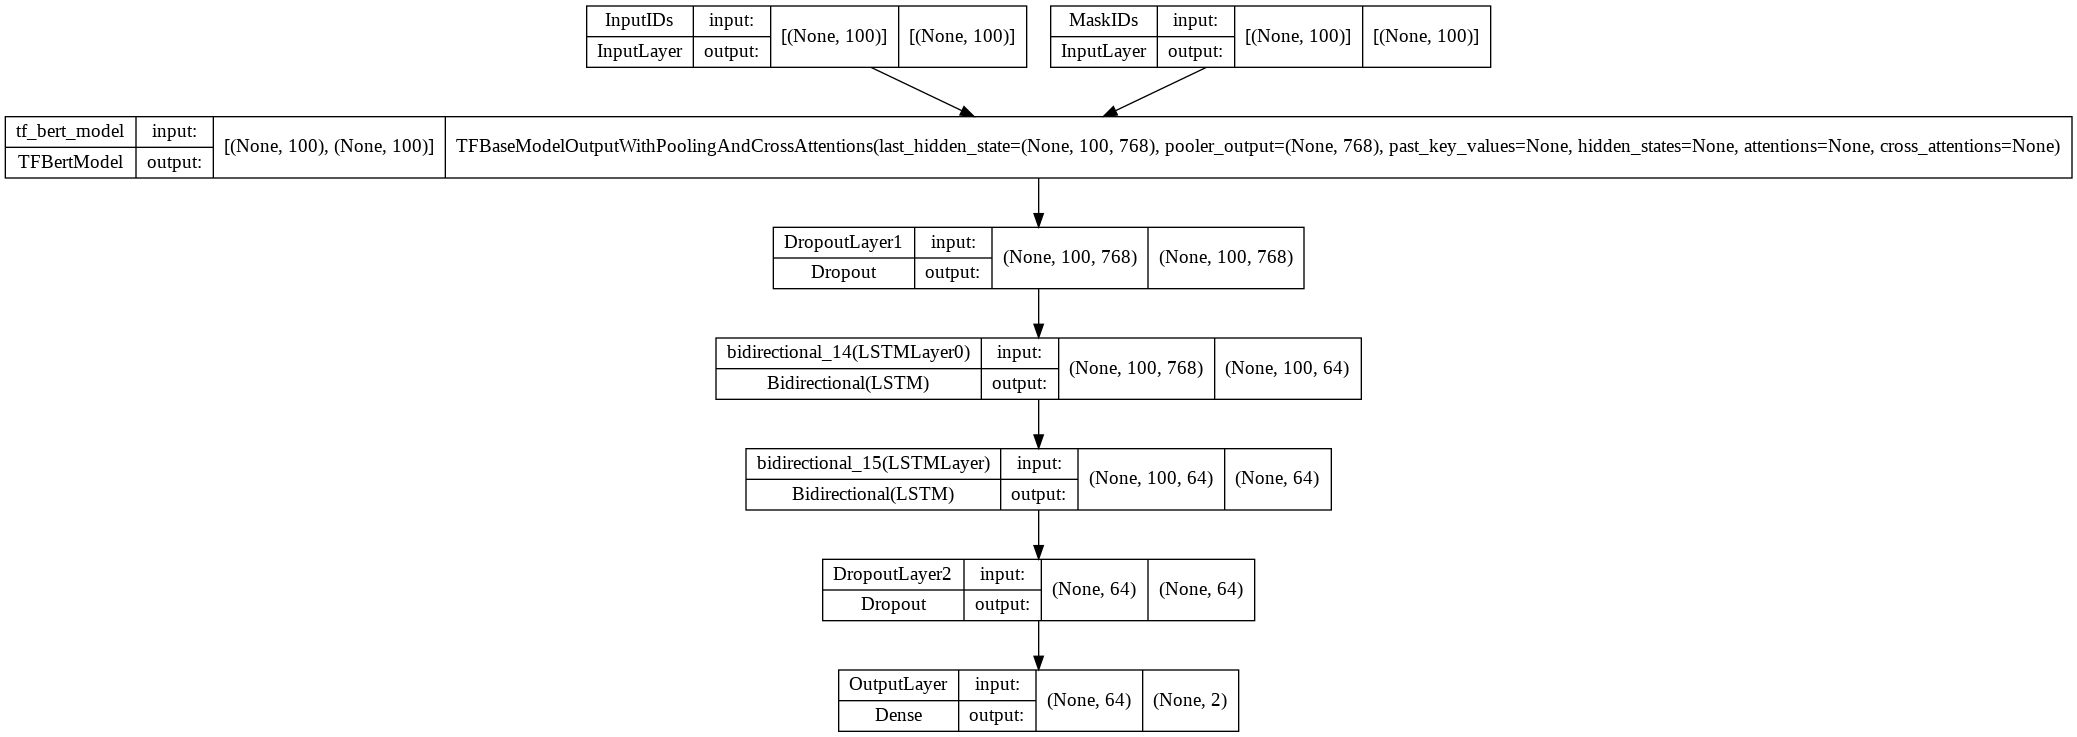

In [ ]:
# Plot the model
plot_model(lstm_bert_tuned, show_shapes=True, show_layer_names=True)

#### Train the BERT LSTM model using the best Hyperparameters

In [ ]:
# Train the model and store the history
lstm_bert_tuned_history = lstm_bert_tuned.fit([tr_input_ids,tr_masks], y_train_bert, batch_size=batch_size,
                            epochs=num_epochs-2, validation_split=val_pct)

Epoch 1/2
27/27 [==============================] - 30s 368ms/step - loss: 0.5713 - acc: 0.7023 - val_loss: 0.4670 - val_acc: 0.7539
Epoch 2/2
27/27 [==============================] - 5s 191ms/step - loss: 0.4569 - acc: 0.7910 - val_loss: 0.4342 - val_acc: 0.8010


#### Test the Tuned BERT LSTM Model get Performance Metrics

The trained model will be tested on the test subset, measuring its performance using the Confusion Matrix, Precision, Recall, Accuracy, and F1 Score.

Evaluate on test data


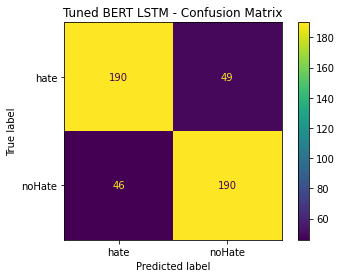

Tuned BERT LSTM Hate Precision:0.81 Tuned BERT LSTM No Hate Precision:0.79
Tuned BERT LSTM Hate Recall:0.79 Tuned BERT LSTM No Hate Recall:0.81
Tuned BERT LSTM Hate F1 Score:0.8 Tuned BERT LSTM No Hate F1 Score:0.8
Tuned BERT LSTM Hate Accuracy:0.79 Tuned BERT LSTM No Hate Accuracy:0.81
Tuned BERT LSTM Overall Accuracy:0.8


In [ ]:
# Evaluate the model on the test subset
print("Evaluate on test data")
# Store the predictions
lstm_bert_tuned_pred = lstm_bert_tuned.predict([ts_input_ids,ts_masks])
# Convert pred to boolean
y_pred_bool_bert_tuned = np.argmax(lstm_bert_tuned_pred, axis=1)

# Print the Confusion Matrix
cm = confusion_matrix(y_test_bert_num, y_pred_bool_bert_tuned) # Calculate CM
# Generate CM Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['hate', 'noHate']) # Generate CM Display
disp.plot()
plt.title('Tuned BERT LSTM - Confusion Matrix') # Set Title
# Show the plot
plt.show()

# Calculate Precision and Recall Scores
pc_scr = np.ndarray.round(precision_score(y_test_bert_num, y_pred_bool_bert_tuned, average=None),2)
rc_scr = np.ndarray.round(recall_score(y_test_bert_num, y_pred_bool_bert_tuned, average=None),2)
# Print Precision and Recall Scores
print("Tuned BERT LSTM Hate Precision:"+str(pc_scr[0])+" Tuned BERT LSTM No Hate Precision:"
+str(pc_scr[1])+"\nTuned BERT LSTM Hate Recall:"+str(rc_scr[0])
+" Tuned BERT LSTM No Hate Recall:"+str(rc_scr[1]))
# Calculate the F1 Scores
f1_scr = np.ndarray.round(f1_score(y_test_bert_num, y_pred_bool_bert_tuned, average=None),2)
# Print F1 Scores
print("Tuned BERT LSTM Hate F1 Score:"+str(f1_scr[0])+" Tuned BERT LSTM No Hate F1 Score:"+str(f1_scr[1]))
# Calculate Accuracy
class_acc = (cm.diagonal()/cm.sum(axis=1)).round(2) # Class Accuracy
all_acc = round(accuracy_score(y_test_bert_num, y_pred_bool_bert_tuned),2) # Overall Accuracy
# Print Accuracy
print("Tuned BERT LSTM Hate Accuracy:"+str(class_acc[0])+" Tuned BERT LSTM No Hate Accuracy:"
+str(class_acc[1])+"\nTuned BERT LSTM Overall Accuracy:"+str(all_acc))

The Hyperband Tuner was able to increase the model's Hate Accuracy by 4%, achieving a Hate Accuracy of 79%. However, it also decreased the No Hate accuracy by 2%, dropping it down to 81%. The overall accuracy also increased by 1%, reaching 80%.

The hyperparameters that were used to achieve these results are:

- Dropout keep probability of the Dropout Layer: 0.2
- Number of the LSTM Layers: 2
- Type of the LSTM Layers: Bidirectional
- Number of units in the LSTM Layers: 32
- Decay rate of the AdamW Optimiser: 0.001
- Learning rate of the AdamW Optimiser: 0.0005

### Fine-Tune the BERT Hybrid CNN-LSTM

A new hybrid model will be tuned and tested, combining both CNN and LSTM architectures. Two Convolution layers with kernel size two and three will take BERT's output, capturing features of two and three consecutive words respectively. Each of the two layers' output will then be pooled and passed to one LSTM layer. The two LSTM layers will then be concatenated together, followed by a Dense layer for classification.

The Hybrid CNN-LSTM hyperparameters that the Tuner will focus on optimising are:

- The dropout keep probability of the Dropout Layer
- The number of filters in the two Convolution Layers
- The type of the LSTM Layers (Unidirectional/Bidirectional)
- The number of units in the LSTM Layers
- The decay rate of the AdamW Optimiser
- The learning rate of the AdamW Optimiser

#### Set up Hyperparameters

In [ ]:
# Percentage of the training data to use for validation
val_pct = 0.1
# Batch Size
batch_size = 64
# Number of training epochs
num_epochs = 4
# Set up parameters for Keras layers
sequence_length = tr_input_ids.shape[1] # Length of input sequences
input_shape = (sequence_length,) # Shape of the Input layer
num_classes = y_train_bert.shape[1] # Number of classes for the output layer

#### Define Hybrid CNN-LSTM Model Function

Keras Tuner requires a model-building function to be passed which specifies the hyperparameters which Keras Tuner has to tune and also builds the model.

In [ ]:
# Define the Model function for Hyperband Tuner
def build_bertHybrid(hp):
  
  # Hyperband Tuning parameters
  # Dropout keep probability
  hp_hyb_dropout = hp.Float('dropout', min_value=0, max_value=0.5, step=0.1)
  # Number of filters in the Convolution Layers
  hp_hyb_filters = hp.Int('filters', min_value=32, max_value=128, step=32)
  # Bidirectional LSTM Flag
  hp_hyb_bidirectional = hp.Choice('bidirectional', values=[0,1])
  # Number of units in the LSTM Layer
  hp_hyb_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
  # Decay Rate for AdamW
  hp_hyb_decay = hp.Choice('decay', values=[0.001,0.25,0.5])
  # Learning Rate for AdamW
  hp_hyb_lr = hp.Choice('learning_rate', values=[6e-5,5e-4,1e-4,1e-3])

  # Create Keras Model Layers with BERT 
  # The Custom Input Layer
  input_ids = Input(shape=input_shape, dtype='int32', name='InputIDs') # Layer for Input IDs
  masks = Input(shape=input_shape, dtype='int32', name='MaskIDs') # Layer for Mask IDs
  inputBert = [input_ids, masks] # Input for BERT Model
  # The Bert Layer
  bert_out = bert_trained(inputBert) # Pass data through Bert
  bert_out = bert_out[0] # Get the last hidden layer
  # One Dropout Layer
  #dropLayer = Dropout(hp_hyb_dropout, name='DropoutLayer1')(bert_out)
  # Two pairs of Convolution and Pool layers
  # First Pair, with kernel size 2
  pairOneLayer = Conv1D(hp_hyb_filters, 2, activation='relu',
                        name='ConvLayer1')(bert_out) # Convolution Layer
  pairOneLayer = MaxPooling1D(name='PoolLayer1')(pairOneLayer) # Pooling Layer
  dropLayer1 = Dropout(hp_hyb_dropout, name='DropoutLayer1', seed=seed_value)(pairOneLayer)
  # Second Pair, with kernel size 3
  pairTwoLayer = Conv1D(hp_hyb_filters, 3, activation='relu',
                        name='ConvLayer2')(bert_out) # Convolution Layer
  pairTwoLayer = MaxPooling1D(name='PoolLayer2')(pairTwoLayer) # Pooling Layer
  dropLayer2 = Dropout(hp_hyb_dropout, name='DropoutLayer2', seed=seed_value)(pairTwoLayer)
  
  # The LSTM Layers
  if hp_hyb_bidirectional==0: # Unidirectional LSTM
    # First LSTM Layer
    lstmLayer1 = LSTM(hp_hyb_units,name='LSTMLayer1')(dropLayer1)
    # Second LSTM Layer
    lstmLayer2 = LSTM(hp_hyb_units,name='LSTMLayer2')(dropLayer2)
  else: # Bidirectional LSTM
    # First LSTM Layer
    lstmLayer1 = Bidirectional(LSTM(hp_hyb_units,name='BiLSTMLayer1'))(dropLayer1)
    # Second LSTM Layer
    lstmLayer2 = Bidirectional(LSTM(hp_hyb_units,name='BiLSTMLayer2'))(dropLayer2) 

  # Concatenate the two pairs
  concLayer = Concatenate(name='ConcatLayer')([lstmLayer1,lstmLayer2])
  # One Dropout Layer
  dropLayer3 = Dropout(hp_hyb_dropout, name='DropoutLayer3', seed=seed_value)(concLayer)

  # The Output layer
  outputLayer = Dense(num_classes, activation='softmax', name='OutputLayer')(dropLayer3)
  # Group layers into the Model object
  hyb_bert_model = Model(inputBert, outputLayer)
  # Specify loss function, optimizer, and performance metrics
  hyb_bert_model.compile(optimizer=AdamW(weight_decay=hp_hyb_decay, learning_rate=hp_hyb_lr),
                         loss='categorical_crossentropy', metrics=['acc'])
  return hyb_bert_model

#### Instantiate the Hyperband

In [ ]:
# Instantiate the Hyperband tune
hyb_tuner = kt.Hyperband(build_bertHybrid, objective='val_loss',
                         max_epochs=num_epochs+2, directory='bert_hyb_dir3', seed=seed_value)

#### Hyperband Tuner Search

In [ ]:
# Set early stopping criteria
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", patience=5, restore_best_weights=True)
# Begin the search
hyb_tuner.search([tr_input_ids,tr_masks], y_train_bert, batch_size=batch_size,
                 epochs=num_epochs, validation_split=val_pct, callbacks=[stop_early])

Trial 10 Complete [00h 00m 58s]
val_loss: 0.43223536014556885

Best val_loss So Far: 0.4160133898258209
Total elapsed time: 00h 07m 50s


In [ ]:
# Get the optimal hyperparameters
hyb_best_hps=hyb_tuner.get_best_hyperparameters(num_trials=1)[0]
# Build the model using the best hyperparameters
hyb_bert_tuned = hyb_tuner.hypermodel.build(hyb_best_hps)
# Show optimal hyperparameters
hyb_best_hps.values

{'dropout': 0.30000000000000004,
 'filters': 64,
 'bidirectional': 0,
 'lstm_units': 128,
 'decay': 0.001,
 'learning_rate': 0.0005,
 'tuner/epochs': 6,
 'tuner/initial_epoch': 2,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0002'}

**Visualise the Hybrid CNN-LSTM Model**

The Keras model can be visualised using the plot_model function from Keras Visualisation Utilities. Visualising the model is a good practice as it helps to confirm layers' order and shapes.

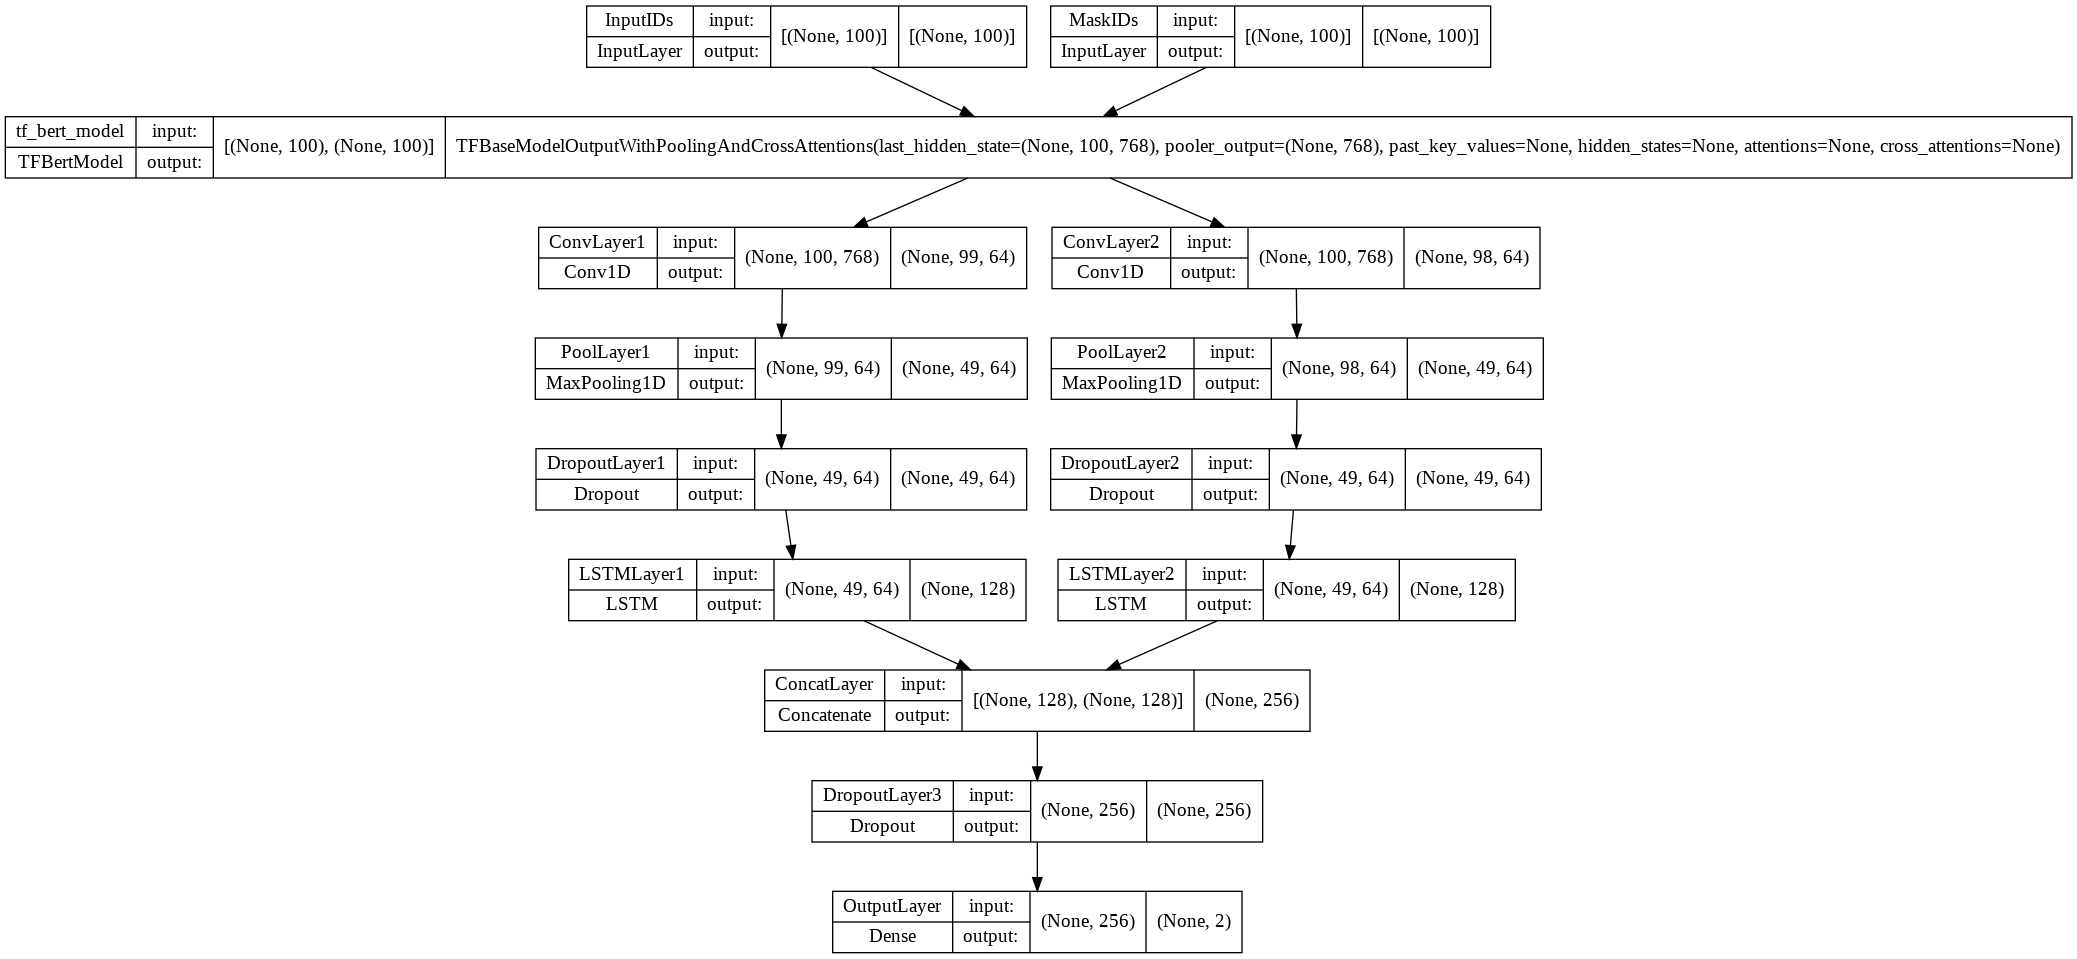

In [ ]:
# Plot the model
plot_model(hyb_bert_tuned, show_shapes=True, show_layer_names=True)

#### Train the Hybrid BERT CNN-LSTM model using the best Hyperparameters

In [ ]:
# Train the model and store the history
hyb_bert_tuned_history = hyb_bert_tuned.fit([tr_input_ids,tr_masks], y_train_bert, batch_size=batch_size,
                            epochs=num_epochs-2, validation_split=val_pct)

Epoch 1/2
27/27 [==============================] - 25s 332ms/step - loss: 0.5628 - acc: 0.6988 - val_loss: 0.4405 - val_acc: 0.7853
Epoch 2/2
27/27 [==============================] - 5s 181ms/step - loss: 0.4496 - acc: 0.7910 - val_loss: 0.4122 - val_acc: 0.8168


#### Test the Tuned Hybrid BERT CNN-LSTM Model get Performance Metrics

The trained model will be tested on the test subset, measuring its performance using the Confusion Matrix, Precision, Recall, Accuracy, and F1 Score.

Evaluate on test data


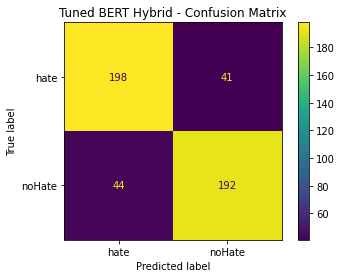

Tuned BERT Hybrid Hate Precision:0.82 Tuned BERT Hybrid No Hate Precision:0.82
Tuned BERT Hybrid Hate Recall:0.83 Tuned BERT Hybrid No Hate Recall:0.81
Tuned BERT Hybrid Hate F1 Score:0.82 Tuned BERT Hybrid No Hate F1 Score:0.82
Tuned BERT Hybrid Hate Accuracy:0.83 Tuned BERT Hybrid No Hate Accuracy:0.81
Tuned BERT Hybrid Overall Accuracy:0.82


In [ ]:
# Evaluate the model on the test subset
print("Evaluate on test data")
# Store the predictions
hyb_bert_tuned_pred = hyb_bert_tuned.predict([ts_input_ids,ts_masks])
# Convert pred to boolean
y_pred_bool_bert_tuned = np.argmax(hyb_bert_tuned_pred, axis=1)

# Print the Confusion Matrix
cm = confusion_matrix(y_test_bert_num, y_pred_bool_bert_tuned) # Calculate CM
# Generate CM Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['hate', 'noHate']) # Generate CM Display
disp.plot()
plt.title('Tuned BERT Hybrid - Confusion Matrix') # Set Title
# Show the plot
plt.show()

# Calculate Precision and Recall Scores
pc_scr = np.ndarray.round(precision_score(y_test_bert_num, y_pred_bool_bert_tuned, average=None),2)
rc_scr = np.ndarray.round(recall_score(y_test_bert_num, y_pred_bool_bert_tuned, average=None),2)
# Print Precision and Recall Scores
print("Tuned BERT Hybrid Hate Precision:"+str(pc_scr[0])+" Tuned BERT Hybrid No Hate Precision:"
+str(pc_scr[1])+"\nTuned BERT Hybrid Hate Recall:"+str(rc_scr[0])
+" Tuned BERT Hybrid No Hate Recall:"+str(rc_scr[1]))
# Calculate the F1 Scores
f1_scr = np.ndarray.round(f1_score(y_test_bert_num, y_pred_bool_bert_tuned, average=None),2)
# Print F1 Scores
print("Tuned BERT Hybrid Hate F1 Score:"+str(f1_scr[0])+" Tuned BERT Hybrid No Hate F1 Score:"+str(f1_scr[1]))
# Calculate Accuracy
class_acc = (cm.diagonal()/cm.sum(axis=1)).round(2) # Class Accuracy
all_acc = round(accuracy_score(y_test_bert_num, y_pred_bool_bert_tuned),2) # Overall Accuracy
# Print Accuracy
print("Tuned BERT Hybrid Hate Accuracy:"+str(class_acc[0])+" Tuned BERT Hybrid No Hate Accuracy:"
+str(class_acc[1])+"\nTuned BERT Hybrid Overall Accuracy:"+str(all_acc))

The Hybrid model that Hyperband Tuner created returned an overall accuracy of 82%, with a Hate Accuracy of 83% and a No Hate Accuracy of 81%, ranking it as the number one model, when comparing its performance metrics with those of every other model in this study.

The hyperparameters that were used to achieve these results are:
- Dropout keep probability of the Dropout Layer: 0.3
- Number of filters in the two Convolution Layers: 64
- Type of the LSTM Layers: Unidirectional
- Number of units in the LSTM Layers: 128
- Decay rate of the AdamW Optimiser: 0.001
- Learning rate of the AdamW Optimiser: 0.0005

### Save the best tuned Keras Model

In [ ]:
# Save model
hyb_bert_tuned.save('hyb_bert_tuned_test.keras')
# Copy model to drive
#!cp -r /content/data/hyb_bert_tuned.keras /content/drive/MyDrive/Colab_Notebooks/hyb_bert_tuned.keras

# Transfer Learning

## Load the Tuned Hybrid BERT CNN-LSTM Model

In [ ]:
# Load the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, padding_side = 'left')

# Load the pre-trained model
bert_trained = TFBertModel.from_pretrained('bert-base-uncased')
# Freeze the weights
bert_trained.trainable = False

# Load the model from file
hyb_bert_tuned = load_model('hyb_bert_tuned.keras', compile=False, custom_objects={'TFBertModel': bert_trained})

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


## Test Twitter Data with the best tuned model

To test the robustness of the model and if it qualifies for Transfer Learning, a second test will be conducted using a bigger, combined dataset containing tweets that can be classified as either Hate or No Hate. The datasets are downloaded from the repositories for the papers "Automated Hate Speech Detection and the Problem of Offensive Language", ICWSM 2017 and "Large Scale Crowdsourcing and Characterization of Twitter Abusive Behavior" respectively.

(source: https://github.com/t-davidson/hate-speech-and-offensive-language and https://dataverse.mpi-sws.org/dataset.xhtml?persistentId=doi:10.5072/FK2/ZDTEMN&version=1.0)

### Load the datasets from file

#### Load the first Tweets Dataset

In [ ]:
# Load the first tweets to a pandas dataframe
tweets_1_df = pd.read_csv("hate-speech-twitter/labeled_data.csv", index_col=0)
# View the first five rows
tweets_1_df.head(5)

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


The DataFrame has six columns: count, hate_speech, offensive_language, neither, class, and tweet. Only the class and tweet columns are required for this test, the rest will be dropped.

In [ ]:
# Drop columns that are not required
tweets_1_df.drop(columns=['count','hate_speech','offensive_language','neither'], inplace=True)

In [ ]:
# Get DF Info
print('Number of Tweets: '+str(tweets_1_df['class'].size))
print('Value of Classes: '+str(tweets_1_df['class'].unique()))

Number of Tweets: 24783
Value of Classes: [2 1 0]


The DataFrame contains 24783 Tweets and three classes. Class 0 is hate speech, Class 1 is offensive language, and Class 2 is Neither. Since this research is focused on classifying if a sentence (or Tweet) is Hate Speech or not, tweets that belong to class 1 will be dropped altogether, to make this a binary classification problem.

In [ ]:
# Keep sentences classified only as Hate and no hate
tweets_1_df = tweets_1_df[(tweets_1_df['class'] != 1)]
# Reset index
tweets_1_df = tweets_1_df.reset_index(drop=True)

In [ ]:
# Replace 0 with hate and 2 with noHate
tweets_1_df['class'] = tweets_1_df['class'].replace([0,2],['hate','noHate'])

In [ ]:
# Get DF Info
print('Number of Tweets after removing offensive class: '+str(tweets_1_df['class'].size))
print('Value of Classes: '+str(tweets_1_df['class'].unique()))

Number of Tweets after removing offensive class: 5593
Value of Classes: ['noHate' 'hate']


A total of 5593 tweets classify as either Hate or No hate. The number of remaining tweets is considerably smaller after the removal of the class 1 however, the dataset can still be considered a good benchmark for the tuned model since it is more than double the size of the dataset used for training the model.

#### Load the second Tweets Dataset

In [ ]:
# Load the tweets to a pandas dataframe
big_tweets_df = pd.read_csv("hate-speech-twitter/hatespeechtwitter.csv")
# View the first five rows
big_tweets_df.head(5)

,tweet_id,maj_label
0,849667487180259329,abusive
1,850490912954351616,abusive
2,848791766853668864,abusive
3,848306464892604416,abusive
4,850010509969465344,normal


The DataFrame has two columns: tweet_id (the id that will be used to fetch the tweet), and maj_label(the label of each tweet).

**Keep classes required for binary classification problem**

In [ ]:
big_tweets_df.maj_label.unique()

array(['abusive', 'normal', 'hateful', 'spam', nan], dtype=object)

The dataset has five classes: abusive, normal, hateful, spam and nan. Since the model is trained on a binary classification problem, only the classes normal and hateful will be kept.

In [ ]:
# Keep sentences classified only as Hate and no hate
big_tweets_df = big_tweets_df[(big_tweets_df['maj_label'] == 'normal') | (big_tweets_df['maj_label'] == 'hateful')]
# Reset index
big_tweets_df = big_tweets_df.reset_index(drop=True)
big_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56470 entries, 0 to 56469
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   56470 non-null  int64 
 1   maj_label  56470 non-null  object
dtypes: int64(1), object(1)
memory usage: 882.5+ KB


The DataFrame contains 56470 Tweet IDs that classify as either normal or hateful.

**Define function to fetch tweets with tweet ID**

Twitter API will be used to fetch each tweet using the tweet ID. A Twitter developer account had to be created to get the required tokens. The functions below are provided as sample code in the Twitter Developer repository, and have been adapted to work with this study.

source: https://github.com/twitterdev/Twitter-API-v2-sample-code/blob/main/Tweet-Lookup/get_tweets_with_bearer_token.py

In [ ]:
import requests
import os
import json

# assign the values accordingly
#api_key = "zeieeFvUQOYeAqMNo3N9cw9FE"
#api_secret = "Ni1HjyNJj5A7sn5sn9BStSbmQin4BMRGyDnEtDPWweWQZlKi1c"
bearer_token = "AAAAAAAAAAAAAAAAAAAAAGdrggEAAAAAcR9oH%2BYlxjB2HQd8FEQAT%2BFF084%3DKC4YsBrJ5JmGyjjnQ8JoBWSQZ6C55wswDmtd8ZYAGF7cmZNeaF"
#access_token = "1565289659336384513-BVpjBEcdb0Zx7IMsv6A2sIY20LYORW"
#access_token_secret = "vaGw10JQ7ARg01naZ8mQ2ZZMbPQ5nYDolojO54NBNSgDm"

def create_url(twid):
    tweet_fields = "tweet.fields=lang,author_id"
    # Tweet fields are adjustable.
    # Options include:
    # attachments, author_id, context_annotations,
    # conversation_id, created_at, entities, geo, id,
    # in_reply_to_user_id, lang, non_public_metrics, organic_metrics,
    # possibly_sensitive, promoted_metrics, public_metrics, referenced_tweets,
    # source, text, and withheld
    ids = "ids="+str(twid)
    # You can adjust ids to include a single Tweets.
    # Or you can add to up to 100 comma-separated IDs
    url = "https://api.twitter.com/2/tweets?{}&{}".format(ids, tweet_fields)
    return url

def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2TweetLookupPython"
    return r

def connect_to_endpoint(url):
    response = requests.request("GET", url, auth=bearer_oauth)
    #print(response.status_code)
    if response.status_code != 200:
        raise Exception(
            "Request returned an error: {} {}".format(
                response.status_code, response.text
            )
        )
    return response.json()

def get_tweet(twid):
  url = create_url(twid)
  twdict = connect_to_endpoint(url)
  return twdict['data'][0]['text']

**Fetch tweets using the tweet ID**

This process took over two hours to finish in Google Colab Pro+. For this reason, the results were saved to a csv file for fast access. The below code is therefore commented out.

In [ ]:
#tweets_list = [] # List to save the tweets
#tweets_class = [] # List to save the class
## For all tweet ids in the dataset
#for i in range(len(big_tweets_df.tweet_id.tolist())):
#  # Store current tweet ID
#  twid = big_tweets_df.tweet_id[i]
#  # Store current class
#  twclass = big_tweets_df.maj_label[i]
#  try: # If tweet still exists
#    tweets_list.append(get_tweet(twid))
#    tweets_class.append(twclass)
#  except: # If tweet not available anymore
#    continue # Continue to the next ID

## Create a Dataframe from the returned lists
#big_tweets_text = pd.DataFrame(tweets_list,columns=['tweet'])
#big_tweets_label = pd.DataFrame(tweets_class,columns=['label'])
#tweets_2_df = pd.concat([big_tweets_text, big_tweets_label], axis=1, join="inner")
## Write to csv
#tweets_2_df.to_csv('tweets_2_df.csv', header=True, index=False)

# Load the result csv from file to a Pandas DataFrame
tweets_2_df = pd.read_csv('hate-speech-twitter/tweets_2_df.csv')
tweets_2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3846 entries, 0 to 3845
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   3846 non-null   object
 1   label   3845 non-null   object
dtypes: object(2)
memory usage: 60.2+ KB


The API was able to fetch 3846 tweets out of 56470. The rest of the tweets were either deleted by their users or taken down.

In [ ]:
# Prepare the second dataset to concatenate it with the first 
tweets_2_df = tweets_2_df[['label','tweet']]
# Rename label to class
tweets_2_df = tweets_2_df.rename(columns={"label": "class"})
# Replace hateful with hate and normal with noHate
tweets_2_df['class'] = tweets_2_df['class'].replace(['hateful','normal'],['hate','noHate'])
# Drop columns with NaN
tweets_2_df.dropna(inplace=True)

### Combine the two Twitter Datasets

In [ ]:
# Concatenate the two dataframes together
tweets_df = pd.concat([tweets_1_df,tweets_2_df])
tweets_df = tweets_df.reset_index(drop=True)

### EDA and Text Pre-Processing

#### Generate Tweets WordCloud

**Tweets Classified as Hate Speech**

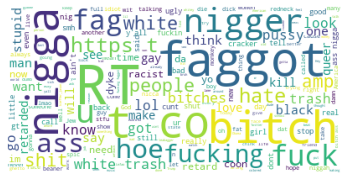

In [ ]:
# WordCloud for tweets classified as hate
wc_hate_tweets = WordCloud(background_color='white').generate(' '.join(tweets_df['tweet'][tweets_df['class']=='hate']))
# Generate plot
plt.imshow(wc_hate_tweets)
plt.axis("off")
plt.show()

**Tweets Classified as no Hate Speech**

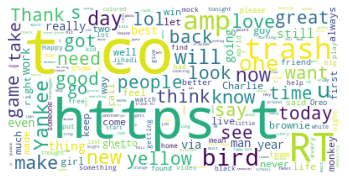

In [ ]:
# WordCloud for tweets classified as noHate
wc_noHate_tweets = WordCloud(background_color='white').generate(' '.join(tweets_df['tweet'][tweets_df['class']=='noHate']))
# Generate plot
plt.imshow(wc_noHate_tweets)
plt.axis("off")
plt.show()

The above WordClouds show the most common words found in tweets classified as Hate Speech and No Hate Speech. 

Words like "bitch", "white", "nigger", "faggot", and "nigga" are a few of the most common words found in the WordCloud of Hate tweets, words that are used in hate speech-language. While words like "yellow" or "trash" also appear in the WordCloud of No Hate tweets, their meaning is not necessarily hate speech related, as they are among other seemingly "innocent" words like "bird", "people", "game", "ghetto" and others. Some of these words might be offensive to some people but do not qualify as Hate Speech.

While the Hate Tweet Wordcloud is not the same as the Hate Forum Wordcloud, many of these words have a similar meaning, which could be a good benchmark to see if the tuned BERT model understands the context of these words, with the help of BERT.

#### Plot Class Distribution using a Pie Chart

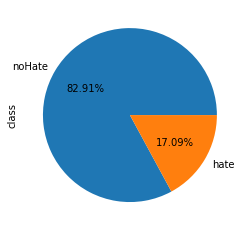

In [ ]:
# Plot the class distribution of Tweets
plot_tweets = tweets_df['class'].value_counts().plot(kind='pie',autopct='%1.2f%%')

The dataset is imbalanced, with 82.91% of the total tweets not being related to Hate Speech and 17.09% of them qualifying as Hate Speech. 

#### Text Pre-Processing using NLTK
Before feeding the tweets into the tuned model, they need to be pre-processed. Apart from standard techniques like .lower() and .isalpha(), tweet-specific preprocessing needs to be applied, like the removal of hashtags and username tags using regular expressions.

A new "clean_tweet" column will be created, containing each processed tweet, using NLTK and applying a lambda function to the "tweet" column.

**Pre-Process the Tweets**

In [ ]:
# Define patterns for regular expressions
pattern_url = "((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)" # pattern to remove urls
pattern_user1 = '@[^\s]+' # pattern to remove usernames starting with @
pattern_user2 = '-[^\s]+' # pattern to remove usernames starting with -
pattern_hashtag = '#[^\s]+' # pattern to remove hashtags

# Apply regular expressions patterns to tweets
tweets_df['tweet'] = tweets_df['tweet'].apply(lambda x: re.sub('RT','', x)) # Remove RTs
tweets_df['tweet'] = tweets_df['tweet'].apply(lambda x: re.sub('&amp','', x)) # Remove ampersand character
tweets_df['tweet'] = tweets_df['tweet'].apply(lambda x: re.sub(pattern_url,'', x)) # Remove url pattern
tweets_df['tweet'] = tweets_df['tweet'].apply(lambda x: re.sub(pattern_user1,'', x)) # Remove user Pattern 1
tweets_df['tweet'] = tweets_df['tweet'].apply(lambda x: re.sub(pattern_user2,'', x)) # Remove user Pattern 1
tweets_df['tweet'] = tweets_df['tweet'].apply(lambda x: re.sub(pattern_hashtag,'', x)) # Remove hashtag Pattern

# Create new column and apply pre-processing using nltk
tweets_df['clean_tweet'] = tweets_df.tweet.apply(
    lambda text: 
        " ".join(
            word.lower() for word in word_tokenize(text) if word.isalpha()
        )
)

**Drop rows where the *clean_tweet* is an empty string**

In [ ]:
# Drop rows where 'clean_tweet' is an empty string
# Get index
idx = tweets_df[tweets_df['clean_tweet'] == ''].index
# Drop rows based on index
tweets_df.drop(index=idx, inplace=True)

# Reset index
tweets_df = tweets_df.reset_index(drop=True)

**Undersample the dataset to have a balanced test set**

In [ ]:
# Instantiate RandomUnderSampler
under_sampler = RandomUnderSampler()
X_tweets = tweets_df.clean_tweet.to_numpy().reshape(-1,1) # Get clean tweets
y_tweets = tweets_df['class'].to_numpy().reshape(-1,1) # Get tweets labels
# Under sample
X_tweets_bal, y_tweets_bal = under_sampler.fit_resample(X_tweets, y_tweets)

In [ ]:
# Transform back to Pandas DataFrame
df1 = pd.DataFrame(X_tweets_bal, columns=['clean_tweet'])
df2 = pd.DataFrame(y_tweets_bal, columns=['class'])
tweets_df = pd.concat([df1, df2], axis=1, join="inner")

### Prepare the dataset

The max tweet length is 32


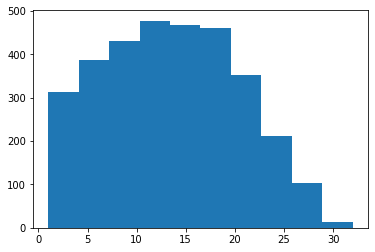

In [ ]:
# Get the length of each tweet
tweets_len = [len(tweet.split(" ")) for tweet in tweets_df.clean_tweet.to_list()]
# Histogram on the tweets length
len_hist=plt.hist(tweets_len)
# Print the max tweets length
print('The max tweet length is '+ str(max(tweets_len)))

In [ ]:
# Set max sentence length
max_sent_len = 100

# Prepare the Tweets dataset
tw_input_ids = [] # encoded sentence list
tw_masks = [] # attention mask list
# For every tweet in the tweets dataframe
for tweet in tweets_df.clean_tweet.to_list():
  tw_enc_dict = tokenizer.encode_plus(tweet, # The tweet
                                   add_special_tokens = True, # [CLS] and [SEP]
                                   truncation = True, # Truncate tweets
                                   max_length = max_sent_len, # The max length
                                   padding='max_length', # Pad tweets
                                   return_attention_mask = True, # Attention Masks
                                   )
  # Add the encoded tweet to the list
  tw_input_ids.append(tw_enc_dict['input_ids'])
  # Add the attention mask
  tw_masks.append(tw_enc_dict['attention_mask'])

# Tweets feature matrix
tw_input_ids = np.array(tw_input_ids).astype('int32')
tw_masks = np.array(tw_masks).astype('int32')

# Convert the categorical label to numeric
y_tweets_bert_num = tweets_df['class'].replace(['hate','noHate'],[0,1]).astype('float32')

### Test the model and get performance metrics

Evaluate on twitter data


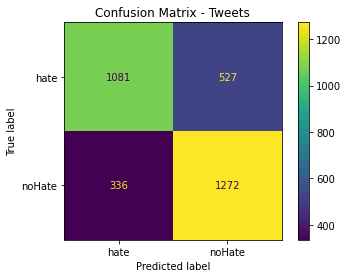

Tweets Hate Precision:0.76 Tweets No Hate Precision:0.71
Tweets Hate Recall:0.67 Tweets No Hate Recall:0.79
Tweets Hate F1 Score:0.71 Tweets No Hate F1 Score:0.75
Tweets Hate Accuracy:0.67 Tweets No Hate Accuracy:0.79
Tweets Overall Accuracy:0.73


In [ ]:
# Evaluate the model
print("Evaluate on twitter data")
# Store the predictions
hyb_bert_tuned_pred = hyb_bert_tuned.predict([tw_input_ids,tw_masks])
# Convert pred to boolean
y_pred_bool_bert_tuned = np.argmax(hyb_bert_tuned_pred, axis=1)

# Print the Confusion Matrix
cm = confusion_matrix(y_tweets_bert_num, y_pred_bool_bert_tuned) # Calculate CM
# Generate CM Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['hate', 'noHate']) # Generate CM Display
disp.plot()
plt.title('Confusion Matrix - Tweets') # Set Title
# Show the plot
plt.show()

# Calculate Precision and Recall Scores
pc_scr = np.ndarray.round(precision_score(y_tweets_bert_num, y_pred_bool_bert_tuned, average=None),2)
rc_scr = np.ndarray.round(recall_score(y_tweets_bert_num, y_pred_bool_bert_tuned, average=None),2)
# Print Precision and Recall Scores
print("Tweets Hate Precision:"+str(pc_scr[0])+" Tweets No Hate Precision:"
+str(pc_scr[1])+"\nTweets Hate Recall:"+str(rc_scr[0])
+" Tweets No Hate Recall:"+str(rc_scr[1]))
# Calculate the F1 Scores
f1_scr = np.ndarray.round(f1_score(y_tweets_bert_num, y_pred_bool_bert_tuned, average=None),2)
# Print F1 Scores
print("Tweets Hate F1 Score:"+str(f1_scr[0])+" Tweets No Hate F1 Score:"+str(f1_scr[1]))
# Calculate Accuracy
class_acc = (cm.diagonal()/cm.sum(axis=1)).round(2) # Class Accuracy
all_acc = round(accuracy_score(y_tweets_bert_num, y_pred_bool_bert_tuned),2) # Overall Accuracy
# Print Accuracy
print("Tweets Hate Accuracy:"+str(class_acc[0])+" Tweets No Hate Accuracy:"
+str(class_acc[1])+"\nTweets Overall Accuracy:"+str(all_acc))

The tuned pre-trained model correctly classified 67% of tweets containing hate speech and 79% of tweets containing no hate speech. While the model's performance on this dataset is decent, it is poorer than the original dataset, having an overall accuracy of 73% compared to 82%. There are three explanations for this:

- First, the model was trained with a sentence length of 100, while most tweets have a sentence length of 5 to 20. This extreme padding and the addition of zeros can potentially "confuse" the model, making it unable to identify the small changes in the vectors of each sentence.
- Second, Twitter users might use a different vocabulary or writing style than the users of the white supremacist forum.
- Third, the Twitter datasets do not use the same annotation guidelines as the white supremacy forum dataset. Words that classify as hate speech in the white supremacy forum dataset might not be considered hate speech in the Twitter datasets and vice versa.

## Fine-Tune the Loaded Model Using the Twitter Data

The above scores and Confusion Matrix suggest that the model qualifies for Transfer Learning. A final test will be done using the combined Twitter Dataset but this time, it will be fine-tuned for one epoch first.

### Load a trainable version of the Tuned Hybrid BERT CNN-LSTM Model

Load the model again without including the compile=False flag.

In [ ]:
# Load a trainable version of the model from file
hyb_bert_trainable = load_model('hyb_bert_tuned.keras',custom_objects={'TFBertModel': bert_trained})

### Prepare the Dataset

Split the dataset to train and test sets and prepare them accordingly.

In [ ]:
# Split the twitter dataset for training and testing
X_tw_train, X_tw_test, y_tw_train, y_tw_test = train_test_split(tweets_df.clean_tweet,tweets_df['class'], test_size=0.2)

# one hot encode train labels
y_tw_train = pd.get_dummies(y_tw_train).values.astype('float32')
# Convert the categorical label to numeric
y_test_num = y_tw_test.replace(['hate','noHate'],[0,1]).astype('float32')

# Set max sentence length
max_sent_len = 100

# Training Data
# Prepare the Tweets dataset
tr_tw_input_ids = [] # encoded sentence list
tr_tw_masks = [] # attention mask list
# For every tweet in the tweets dataframe
for tweet in X_tw_train.to_list():
  tr_tw_enc_dict = tokenizer.encode_plus(tweet, # The tweet
                                   add_special_tokens = True, # [CLS] and [SEP]
                                   truncation = True, # Truncate tweets
                                   max_length = max_sent_len, # The max length
                                   padding='max_length', # Pad tweets
                                   return_attention_mask = True, # Attention Masks
                                   )
  # Add the encoded tweet to the list
  tr_tw_input_ids.append(tr_tw_enc_dict['input_ids'])
  # Add the attention mask
  tr_tw_masks.append(tr_tw_enc_dict['attention_mask'])

# Tweets feature matrix
tr_tw_input_ids = np.array(tr_tw_input_ids).astype('int32')
tr_tw_masks = np.array(tr_tw_masks).astype('int32')

# Test Data
# Prepare the Tweets dataset
ts_tw_input_ids = [] # encoded sentence list
ts_tw_masks = [] # attention mask list
# For every tweet in the tweets dataframe
for tweet in X_tw_test.to_list():
  ts_tw_enc_dict = tokenizer.encode_plus(tweet, # The tweet
                                   add_special_tokens = True, # [CLS] and [SEP]
                                   truncation = True, # Truncate tweets
                                   max_length = max_sent_len, # The max length
                                   padding='max_length', # Pad tweets
                                   return_attention_mask = True, # Attention Masks
                                   )
  # Add the encoded tweet to the list
  ts_tw_input_ids.append(ts_tw_enc_dict['input_ids'])
  # Add the attention mask
  ts_tw_masks.append(ts_tw_enc_dict['attention_mask'])

# Tweets feature matrix
ts_tw_input_ids = np.array(ts_tw_input_ids).astype('int32')
ts_tw_masks = np.array(ts_tw_masks).astype('int32')

### Fine-Tune the Loaded Model for One Epoch

In [ ]:
# Fine-Tune the model for one epoch
hyb_bert_trainable_history = hyb_bert_trainable.fit([tr_tw_input_ids,tr_tw_masks], y_tw_train, batch_size=64,
                            epochs=1, validation_split=0.1)

37/37 [==============================] - 35s 545ms/step - loss: 0.6210 - acc: 0.7692 - val_loss: 0.3937 - val_acc: 0.8488


### Test the Loaded Model on the Test Set

Use the test set with the non fine-tuned version of the loaded hybrid model and get performance metrics for comparison reasons.

Evaluate on twitter data


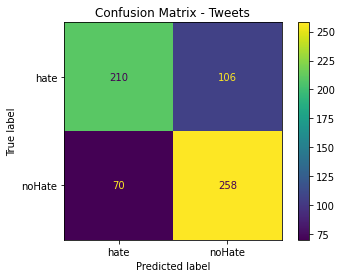

Tweets Hate Precision:0.75 Tweets No Hate Precision:0.71
Tweets Hate Recall:0.66 Tweets No Hate Recall:0.79
Tweets Hate F1 Score:0.7 Tweets No Hate F1 Score:0.75
Tweets Hate Accuracy:0.66 Tweets No Hate Accuracy:0.79
Tweets Overall Accuracy:0.73


In [ ]:
# Evaluate the model
print("Evaluate on twitter data")
# Store the predictions
hyb_bert_tuned_pred = hyb_bert_tuned.predict([ts_tw_input_ids,ts_tw_masks])
# Convert pred to boolean
y_pred_bool_bert_tuned = np.argmax(hyb_bert_tuned_pred, axis=1)

# Print the Confusion Matrix
cm = confusion_matrix(y_test_num, y_pred_bool_bert_tuned) # Calculate CM
# Generate CM Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['hate', 'noHate']) # Generate CM Display
disp.plot()
plt.title('Confusion Matrix - Tweets') # Set Title
# Show the plot
plt.show()

# Calculate Precision and Recall Scores
pc_scr = np.ndarray.round(precision_score(y_test_num, y_pred_bool_bert_tuned, average=None),2)
rc_scr = np.ndarray.round(recall_score(y_test_num, y_pred_bool_bert_tuned, average=None),2)
# Print Precision and Recall Scores
print("Tweets Hate Precision:"+str(pc_scr[0])+" Tweets No Hate Precision:"
+str(pc_scr[1])+"\nTweets Hate Recall:"+str(rc_scr[0])
+" Tweets No Hate Recall:"+str(rc_scr[1]))
# Calculate the F1 Scores
f1_scr = np.ndarray.round(f1_score(y_test_num, y_pred_bool_bert_tuned, average=None),2)
# Print F1 Scores
print("Tweets Hate F1 Score:"+str(f1_scr[0])+" Tweets No Hate F1 Score:"+str(f1_scr[1]))
# Calculate Accuracy
class_acc = (cm.diagonal()/cm.sum(axis=1)).round(2) # Class Accuracy
all_acc = round(accuracy_score(y_test_num, y_pred_bool_bert_tuned),2) # Overall Accuracy
# Print Accuracy
print("Tweets Hate Accuracy:"+str(class_acc[0])+" Tweets No Hate Accuracy:"
+str(class_acc[1])+"\nTweets Overall Accuracy:"+str(all_acc))

As expected, the non fine-tuned model's performance on the test set is almost identical to the performance on the whole Twitter Dataset.

### Test the Fine-Tuned Model on the Test Set

Use the test set with the new fine-tuned version of the loaded hybrid model and get performance metrics.

Evaluate on twitter data


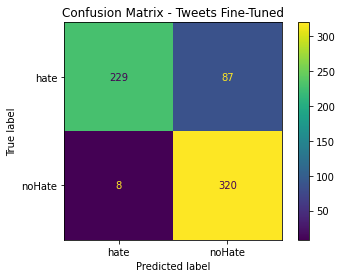

FT Tweets Hate Precision:0.97 FT Tweets No Hate Precision:0.79
FT Tweets Hate Recall:0.72 FT Tweets No Hate Recall:0.98
FT Tweets Hate F1 Score:0.83 FT Tweets No Hate F1 Score:0.87
FT Tweets Hate Accuracy:0.72 FT Tweets No Hate Accuracy:0.98
FT Tweets Overall Accuracy:0.85


In [ ]:
# Evaluate the model
print("Evaluate on twitter data")
# Store the predictions
hyb_bert_tuned_pred = hyb_bert_trainable.predict([ts_tw_input_ids,ts_tw_masks])
# Convert pred to boolean
y_pred_bool_bert_tuned = np.argmax(hyb_bert_tuned_pred, axis=1)

# Print the Confusion Matrix
cm = confusion_matrix(y_test_num, y_pred_bool_bert_tuned) # Calculate CM
# Generate CM Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['hate', 'noHate']) # Generate CM Display
disp.plot()
plt.title('Confusion Matrix - Tweets Fine-Tuned') # Set Title
# Show the plot
plt.show()

# Calculate Precision and Recall Scores
pc_scr = np.ndarray.round(precision_score(y_test_num, y_pred_bool_bert_tuned, average=None),2)
rc_scr = np.ndarray.round(recall_score(y_test_num, y_pred_bool_bert_tuned, average=None),2)
# Print Precision and Recall Scores
print("FT Tweets Hate Precision:"+str(pc_scr[0])+" FT Tweets No Hate Precision:"
+str(pc_scr[1])+"\nFT Tweets Hate Recall:"+str(rc_scr[0])
+" FT Tweets No Hate Recall:"+str(rc_scr[1]))
# Calculate the F1 Scores
f1_scr = np.ndarray.round(f1_score(y_test_num, y_pred_bool_bert_tuned, average=None),2)
# Print F1 Scores
print("FT Tweets Hate F1 Score:"+str(f1_scr[0])+" FT Tweets No Hate F1 Score:"+str(f1_scr[1]))
# Calculate Accuracy
class_acc = (cm.diagonal()/cm.sum(axis=1)).round(2) # Class Accuracy
all_acc = round(accuracy_score(y_test_num, y_pred_bool_bert_tuned),2) # Overall Accuracy
# Print Accuracy
print("FT Tweets Hate Accuracy:"+str(class_acc[0])+" FT Tweets No Hate Accuracy:"
+str(class_acc[1])+"\nFT Tweets Overall Accuracy:"+str(all_acc))

Fine-tuning the model, even for one epoch, improved its performance across the board. While the Hate Accuracy saw a moderate increase of 6%, reaching 72%, the No Hate Accuracy increased by almost 20%, reaching an almost perfect accuracy score of 98%. The overall accuracy increased to 85% from 73%. At first glance, the No Hate Accuracy suggests that the model is overfitting the No Hate class. However, the F1 Scores of both classes are fairly close to each other, suggesting otherwise.

These results prove that the hybrid model can be used for Transfer Learning and applied to similar problems, and that its performance can be further improved even by training it for just one epoch.